# Idea
Do some training

In [1]:
SEED = 133
TIME_WINDOW = "50s"
DATA_FILE = '../../data/all_df_50s_Heqing_device2.csv'

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import pickle

assert Path(DATA_FILE).exists()

In [3]:
import sys
repo_base_path = Path("./../../../").resolve()
assert str(repo_base_path).endswith("csg_is"), f"{repo_base_path} is not a valid path to the CSG_IS repository" 

sys.path.append(str(repo_base_path))
sys.path.append("..")

# from py_dataset import get_all_files_df
# from py_dataset import read_in_files
from py_dataset import feature_plotting
# from py_dataset import feature_selection
# from py_dataset import net_feature_engineering
# from py_dataset import entropy_feature_engineering
# from py_dataset.classes import DataSource
from py_dataset import sys_func

from py_dataset.classes import DataSource



In [4]:
LOG_PATH = (repo_base_path / "training" / "official_logs")
LOG_NAME = f"single-layer_300_{TIME_WINDOW}"
LOG_NAME_EXPERIMENT_2 = f"single-layer_30_from_weights_{TIME_WINDOW}"
LOG_NAME_EXPERIMENT_3 = f"multi-layer_30_from_weights_{TIME_WINDOW}"

assert LOG_PATH.exists()
assert not (LOG_PATH / LOG_NAME).exists(), "are you sure to run this again?"
assert not (LOG_PATH / LOG_NAME_EXPERIMENT_2).exists(), "are you sure to run this again?"
assert not (LOG_PATH / LOG_NAME_EXPERIMENT_3).exists(), "are you sure to run this again?"

In [5]:
df = pd.read_csv(DATA_FILE)
df.set_index("timestamp", inplace=True)

In [6]:
assert df["label"].unique().shape == (10,)

### Preprocessings
- remove Null values
- drop timestamp
- labelEncode
- normalize

In [7]:
print(df.shape)
old_df = df.copy()
df.dropna(axis=0, how='any', inplace=True)

print(df.shape)

(17340, 306)
(13228, 306)


In [8]:
df.reset_index(inplace=True, drop=True)

In [9]:
label_encoder = sys_func.create_label_encoder_for_labels()
df['label'] = label_encoder.transform(df['label'])

In [10]:
df = feature_plotting.test_transform_all_to_numeric_columns(df)

In [11]:
cols_to_exclude_from_scaling = ["label"]
vectors = feature_plotting.minmax_scale_features(df,remove_outliers_iqr_all_columns=False,
                                                        cols_to_exclude_from_scaling=cols_to_exclude_from_scaling)
# print(vectors.shape)
# print(" with dropped null: ", vectors.dropna(axis=0, how='any', inplace=False).shape)

In [12]:
df["label"].unique(), vectors["label"].unique()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([0, 1, 2, 3, 4, 5, 6, 7, 8]))

### Setup

In [13]:
from torch.utils.data import Dataset, DataLoader
import torch

class CustomeDataset(Dataset):
    def __init__(self, some_df:pd.DataFrame):
        
        self.x = torch.tensor(some_df.drop(columns=["label"], inplace=False).values, dtype=torch.float32)
        self.labels = torch.tensor(some_df["label"].values, dtype=torch.uint8)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        # if torch.is_tensor(idx):
        #     idx = idx.tolist()
        # print(self.x[idx], self.labels[idx])
        return self.x[idx], self.labels[idx]

In [14]:
from mlp_single_layer import MalwaresModelLinearLayer
from torch.utils.data import DataLoader
import lightning
from sklearn.model_selection import train_test_split
from lightning import loggers as pl_loggers
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint

tensorboard = pl_loggers.TensorBoardLogger(save_dir=LOG_PATH, name=LOG_NAME)

# split into train and val
train, val = train_test_split(vectors, test_size=0.2, random_state=SEED)

train_dataset = CustomeDataset(train)
train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True, num_workers=7)

val_dataset = CustomeDataset(val)
val_dataloader = DataLoader(val_dataset, batch_size=500, shuffle=False, num_workers=7)

# trainer = lightning.Trainer(fast_dev_run=100)
monitor = "Validation/Accuracy"
early_stop_callback = EarlyStopping(monitor=monitor, patience=5, verbose=True, mode="max")
checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor=monitor, mode="max")

trainer = lightning.Trainer(max_epochs=150, callbacks=[early_stop_callback, checkpoint_callback], enable_checkpointing=True, logger=tensorboard) #logger=None, 


model = MalwaresModelLinearLayer(input_size = vectors.shape[1]-1, output_size = len(label_encoder.classes_), seed=SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:
trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                      | Params
------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0     
1 | val_metrics   | MetricCollection          | 0     
2 | test_metrics  | MetricCollection          | 0     
3 | cm            | MulticlassConfusionMatrix | 0     
4 | criterion     | CrossEntropyLoss          | 0     
5 | l1            | Linear                    | 2.8 K 
------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 0
ValidationEpoch/CM
 tensor([[102,   0,   0,   0,   0,  10,   0,   8,   0],
        [ 24,   0,   0,   0,  61,   4,   0,   0,   0],
        [122,   0,   0,   0,   0,   6,   0,   1,   0],
        [ 98,   0,   0,   0,   0,  14,   0,   4,   0],
        [ 49,   0,   0,   0,   0,  40,   0,  34,   0],
        [ 92,   0,   0,   0,   0,   0,   0,   0,   0],
        [108,   0,   0,   0,   0,   5,   0,   7,   0],
        [ 82,   0,   0,   0,   0,   0,   0,   0,   0],
        [ 58,   0,   0,   0,   0,   0,   0,  71,   0]])


/home/<User>/repos/csg_is/.venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 1
ValidationEpoch/CM
 tensor([[ 503,    0,  135,  497,  135,   44,  187,    9,    0],
        [  40, 1409,    0,    0,   95,    5,    0,    0,    0],
        [ 273,    3, 1073,   47,   52,  176,  229,    4,    0],
        [ 338,    2,  208,  660,   87,   58,  190,   13,    0],
        [ 239,    0,  144,  134,  728,  101,  160,   57,    0],
        [ 149,   15,  101,    0,    0, 1261,    0,    6,    0],
        [ 363,    0,  566,  108,   65,  124,  327,   12,    0],
        [ 143,    0,    0,    0,    0,    0,    0, 1379,    0],
        [  88,   60,    0,    0,    0,    0,    0,  101, 1325]])
Epoch end: Train, epoch number: 0
TrainEpoch/CM
 tensor([[ 503,    0,  135,  497,  135,   44,  187,    9,    0],
        [  40, 1409,    0,    0,   95,    5,    0,    0,    0],
        [ 273,    3, 1073,   47,   52,  176,  229,    4,    0],
        [ 338,    2,  208,  660,   87,   58,  190,   13,    0],
        [ 239,    0,  144,  134,  728,  101,  160,   57,   

Metric Validation/Accuracy improved. New best score: 0.715


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 2
ValidationEpoch/CM
 tensor([[ 895,    0,  187, 1182,  290,   44,  293,    9,    0],
        [  40, 2869,    0,    0,   95,    5,    0,    0,    0],
        [ 335,    3, 2501,  116,  117,  181,  328,    4,    0],
        [ 556,    2,  335, 1529,  213,   58,  285,   18,    0],
        [ 317,    0,  184,  324, 1746,  101,  274,   57,    0],
        [ 149,   20,  104,    0,    0, 2693,    0,    6,    0],
        [ 529,    0, 1166,  299,  172,  132,  700,   12,    0],
        [ 143,    0,    0,    0,    0,    0,    0, 2819,    0],
        [  88,   60,    0,    0,    0,    0,    0,  101, 2770]])
Epoch end: Train, epoch number: 1
TrainEpoch/CM
 tensor([[ 895,    0,  187, 1182,  290,   44,  293,    9,    0],
        [  40, 2869,    0,    0,   95,    5,    0,    0,    0],
        [ 335,    3, 2501,  116,  117,  181,  328,    4,    0],
        [ 556,    2,  335, 1529,  213,   58,  285,   18,    0],
        [ 317,    0,  184,  324, 1746,  101,  274,   57,   

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 3
ValidationEpoch/CM
 tensor([[1498,    0,  202, 1792,  314,   44,  431,    9,    0],
        [  40, 4329,    0,    0,   95,    5,    0,    0,    0],
        [ 380,    3, 4030,  147,  163,  184,  402,    4,    0],
        [ 774,    2,  450, 2526,  228,   58,  375,   23,    0],
        [ 339,    0,  209,  402, 2917,  101,  418,   57,    0],
        [ 149,   25,  105,    0,    0, 4127,    0,    6,    0],
        [ 650,    0, 1727,  492,  236,  136, 1202,   12,    0],
        [ 143,    0,    0,    0,    0,    0,    0, 4259,    0],
        [  88,   60,    0,    0,    0,    0,    0,  101, 4215]])


Metric Validation/Accuracy improved by 0.081 >= min_delta = 0.0. New best score: 0.796


Epoch end: Train, epoch number: 2
TrainEpoch/CM
 tensor([[1498,    0,  202, 1792,  314,   44,  431,    9,    0],
        [  40, 4329,    0,    0,   95,    5,    0,    0,    0],
        [ 380,    3, 4030,  147,  163,  184,  402,    4,    0],
        [ 774,    2,  450, 2526,  228,   58,  375,   23,    0],
        [ 339,    0,  209,  402, 2917,  101,  418,   57,    0],
        [ 149,   25,  105,    0,    0, 4127,    0,    6,    0],
        [ 650,    0, 1727,  492,  236,  136, 1202,   12,    0],
        [ 143,    0,    0,    0,    0,    0,    0, 4259,    0],
        [  88,   60,    0,    0,    0,    0,    0,  101, 4215]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 4
ValidationEpoch/CM
 tensor([[2380,    0,  216, 2165,  319,   44,  547,    9,    0],
        [  40, 5789,    0,    0,   95,    5,    0,    0,    0],
        [ 435,    3, 5504,  152,  209,  186,  548,    4,    0],
        [1126,    2,  521, 3427,  235,   58,  479,   28,    0],
        [ 369,    0,  218,  425, 4166,  101,  547,   57,    0],
        [ 149,   30,  109,    0,    0, 5558,    0,    6,    0],
        [ 799,    0, 2187,  621,  279,  138, 1864,   12,    0],
        [ 143,    0,    0,    0,    0,    0,    0, 5699,    0],
        [  88,   60,    0,    0,    0,    0,    0,  101, 5660]])
Epoch end: Train, epoch number: 3
TrainEpoch/CM
 tensor([[2380,    0,  216, 2165,  319,   44,  547,    9,    0],
        [  40, 5789,    0,    0,   95,    5,    0,    0,    0],
        [ 435,    3, 5504,  152,  209,  186,  548,    4,    0],
        [1126,    2,  521, 3427,  235,   58,  479,   28,    0],
        [ 369,    0,  218,  425, 4166,  101,  547,   57,   

Metric Validation/Accuracy improved by 0.042 >= min_delta = 0.0. New best score: 0.838


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 5
ValidationEpoch/CM
 tensor([[3289,    0,  220, 2556,  322,   44,  630,    9,    0],
        [  40, 7249,    0,    0,   95,    5,    0,    0,    0],
        [ 475,    3, 7007,  169,  247,  186,  678,    4,    0],
        [1518,    2,  569, 4321,  242,   58,  577,   29,    0],
        [ 399,    0,  220,  455, 5474,  101,  617,   57,    0],
        [ 149,   35,  114,    0,    0, 6988,    0,    6,    0],
        [ 927,    0, 2593,  752,  319,  138, 2604,   12,    0],
        [ 143,    0,    0,    0,    0,    0,    0, 7139,    0],
        [  88,   60,    0,    0,    0,    0,    0,  101, 7105]])
Epoch end: Train, epoch number: 4
TrainEpoch/CM
 tensor([[3289,    0,  220, 2556,  322,   44,  630,    9,    0],
        [  40, 7249,    0,    0,   95,    5,    0,    0,    0],
        [ 475,    3, 7007,  169,  247,  186,  678,    4,    0],
        [1518,    2,  569, 4321,  242,   58,  577,   29,    0],
        [ 399,    0,  220,  455, 5474,  101,  617,   57,   

Metric Validation/Accuracy improved by 0.017 >= min_delta = 0.0. New best score: 0.855


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 6
ValidationEpoch/CM
 tensor([[4111,    0,  222, 3037,  322,   44,  715,    9,    0],
        [  40, 8709,    0,    0,   95,    5,    0,    0,    0],
        [ 491,    3, 8431,  190,  272,  186,  920,    4,    0],
        [1860,    2,  626, 5284,  248,   58,  649,   29,    0],
        [ 419,    0,  226,  496, 6801,  101,  663,   57,    0],
        [ 149,   36,  119,    0,    0, 8422,    0,    6,    0],
        [1025,    0, 3009,  880,  350,  139, 3375,   12,    0],
        [ 143,    0,    0,    0,    0,    0,    0, 8579,    0],
        [  88,   60,    0,    0,    0,    0,    0,  101, 8550]])
Epoch end: Train, epoch number: 5
TrainEpoch/CM
 tensor([[4111,    0,  222, 3037,  322,   44,  715,    9,    0],
        [  40, 8709,    0,    0,   95,    5,    0,    0,    0],
        [ 491,    3, 8431,  190,  272,  186,  920,    4,    0],
        [1860,    2,  626, 5284,  248,   58,  649,   29,    0],
        [ 419,    0,  226,  496, 6801,  101,  663,   57,   

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 7
ValidationEpoch/CM
 tensor([[ 5103,     0,   228,  3366,   323,    44,   777,     9,     0],
        [   40, 10169,     0,     0,    95,     5,     0,     0,     0],
        [  512,     3,  9915,   201,   284,   186,  1120,     4,     0],
        [ 2127,     2,   664,  6353,   251,    58,   712,    29,     0],
        [  448,     0,   226,   524,  8160,   101,   687,    57,     0],
        [  149,    36,   124,     0,     0,  9857,     0,     6,     0],
        [ 1136,     0,  3435,  1009,   372,   140,  4131,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 10019,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101,  9995]])


Metric Validation/Accuracy improved by 0.015 >= min_delta = 0.0. New best score: 0.870


Epoch end: Train, epoch number: 6
TrainEpoch/CM
 tensor([[ 5103,     0,   228,  3366,   323,    44,   777,     9,     0],
        [   40, 10169,     0,     0,    95,     5,     0,     0,     0],
        [  512,     3,  9915,   201,   284,   186,  1120,     4,     0],
        [ 2127,     2,   664,  6353,   251,    58,   712,    29,     0],
        [  448,     0,   226,   524,  8160,   101,   687,    57,     0],
        [  149,    36,   124,     0,     0,  9857,     0,     6,     0],
        [ 1136,     0,  3435,  1009,   372,   140,  4131,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 10019,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101,  9995]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 8
ValidationEpoch/CM
 tensor([[ 6141,     0,   231,  3636,   324,    44,   855,     9,     0],
        [   40, 11629,     0,     0,    95,     5,     0,     0,     0],
        [  530,     3, 11414,   211,   286,   186,  1319,     4,     0],
        [ 2393,     2,   691,  7413,   253,    58,   797,    29,     0],
        [  467,     0,   228,   548,  9547,   101,   695,    57,     0],
        [  149,    36,   129,     0,     0, 11292,     0,     6,     0],
        [ 1221,     0,  3823,  1122,   393,   140,  4969,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 11459,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 11440]])
Epoch end: Train, epoch number: 7
TrainEpoch/CM
 tensor([[ 6141,     0,   231,  3636,   324,    44,   855,     9,     0],
        [   40, 11629,     0,     0,    95,     5,     0,     0,     0],
        [  530,     3, 11414,   211,   286,   186,  1319,     4,     0],
        [ 2393,

Metric Validation/Accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.877


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 9
ValidationEpoch/CM
 tensor([[ 7253,     0,   233,  3851,   324,    44,   916,     9,     0],
        [   40, 13089,     0,     0,    95,     5,     0,     0,     0],
        [  542,     3, 12923,   218,   287,   186,  1518,     4,     0],
        [ 2654,     2,   710,  8494,   256,    58,   873,    29,     0],
        [  481,     0,   228,   570, 10944,   101,   702,    57,     0],
        [  149,    36,   134,     0,     0, 12727,     0,     6,     0],
        [ 1301,     0,  4186,  1233,   412,   140,  5841,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 12899,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 12885]])


Metric Validation/Accuracy improved by 0.014 >= min_delta = 0.0. New best score: 0.890


Epoch end: Train, epoch number: 8
TrainEpoch/CM
 tensor([[ 7253,     0,   233,  3851,   324,    44,   916,     9,     0],
        [   40, 13089,     0,     0,    95,     5,     0,     0,     0],
        [  542,     3, 12923,   218,   287,   186,  1518,     4,     0],
        [ 2654,     2,   710,  8494,   256,    58,   873,    29,     0],
        [  481,     0,   228,   570, 10944,   101,   702,    57,     0],
        [  149,    36,   134,     0,     0, 12727,     0,     6,     0],
        [ 1301,     0,  4186,  1233,   412,   140,  5841,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 12899,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 12885]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 10
ValidationEpoch/CM
 tensor([[ 8328,     0,   233,  4115,   324,    44,   967,     9,     0],
        [   40, 14549,     0,     0,    95,     5,     0,     0,     0],
        [  557,     3, 14419,   219,   287,   186,  1734,     4,     0],
        [ 2867,     2,   727,  9629,   257,    58,   947,    29,     0],
        [  487,     0,   228,   575, 12368,   101,   707,    57,     0],
        [  149,    36,   139,     0,     0, 14162,     0,     6,     0],
        [ 1368,     0,  4547,  1340,   434,   140,  6729,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 14339,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 14330]])
Epoch end: Train, epoch number: 9
TrainEpoch/CM
 tensor([[ 8328,     0,   233,  4115,   324,    44,   967,     9,     0],
        [   40, 14549,     0,     0,    95,     5,     0,     0,     0],
        [  557,     3, 14419,   219,   287,   186,  1734,     4,     0],
        [ 2867

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 11
ValidationEpoch/CM
 tensor([[ 9401,     0,   233,  4384,   324,    44,  1015,     9,     0],
        [   40, 16009,     0,     0,    95,     5,     0,     0,     0],
        [  569,     3, 15906,   226,   287,   186,  1956,     4,     0],
        [ 3124,     2,   742, 10730,   258,    58,  1013,    29,     0],
        [  490,     0,   228,   591, 13789,   101,   707,    57,     0],
        [  149,    36,   144,     0,     0, 15597,     0,     6,     0],
        [ 1438,     0,  4887,  1454,   446,   140,  7638,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 15779,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 15775]])


Metric Validation/Accuracy improved by 0.010 >= min_delta = 0.0. New best score: 0.900


Epoch end: Train, epoch number: 10
TrainEpoch/CM
 tensor([[ 9401,     0,   233,  4384,   324,    44,  1015,     9,     0],
        [   40, 16009,     0,     0,    95,     5,     0,     0,     0],
        [  569,     3, 15906,   226,   287,   186,  1956,     4,     0],
        [ 3124,     2,   742, 10730,   258,    58,  1013,    29,     0],
        [  490,     0,   228,   591, 13789,   101,   707,    57,     0],
        [  149,    36,   144,     0,     0, 15597,     0,     6,     0],
        [ 1438,     0,  4887,  1454,   446,   140,  7638,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 15779,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 15775]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 12
ValidationEpoch/CM
 tensor([[10529,     0,   233,  4606,   324,    44,  1055,     9,     0],
        [   40, 17469,     0,     0,    95,     5,     0,     0,     0],
        [  581,     3, 17405,   227,   287,   186,  2172,     4,     0],
        [ 3344,     2,   755, 11891,   258,    58,  1059,    29,     0],
        [  493,     0,   228,   598, 15219,   101,   707,    57,     0],
        [  149,    36,   149,     0,     0, 17032,     0,     6,     0],
        [ 1503,     0,  5208,  1557,   464,   140,  8576,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 17219,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 17220]])
Epoch end: Train, epoch number: 11
TrainEpoch/CM
 tensor([[10529,     0,   233,  4606,   324,    44,  1055,     9,     0],
        [   40, 17469,     0,     0,    95,     5,     0,     0,     0],
        [  581,     3, 17405,   227,   287,   186,  2172,     4,     0],
        [ 334

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 13
ValidationEpoch/CM
 tensor([[11682,     0,   233,  4798,   324,    44,  1100,     9,     0],
        [   40, 18929,     0,     0,    95,     5,     0,     0,     0],
        [  593,     3, 18883,   230,   287,   186,  2407,     4,     0],
        [ 3548,     2,   766, 13061,   261,    58,  1111,    29,     0],
        [  506,     0,   228,   605, 16635,   101,   711,    57,     0],
        [  149,    36,   154,     0,     0, 18467,     0,     6,     0],
        [ 1565,     0,  5495,  1653,   474,   140,  9566,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 18659,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 18665]])
Epoch end: Train, epoch number: 12
TrainEpoch/CM
 tensor([[11682,     0,   233,  4798,   324,    44,  1100,     9,     0],
        [   40, 18929,     0,     0,    95,     5,     0,     0,     0],
        [  593,     3, 18883,   230,   287,   186,  2407,     4,     0],
        [ 354

Metric Validation/Accuracy improved by 0.007 >= min_delta = 0.0. New best score: 0.907


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 14
ValidationEpoch/CM
 tensor([[12893,     0,   233,  4940,   324,    44,  1137,     9,     0],
        [   40, 20389,     0,     0,    95,     5,     0,     0,     0],
        [  605,     3, 20348,   234,   287,   186,  2654,     4,     0],
        [ 3755,     2,   782, 14222,   261,    58,  1167,    29,     0],
        [  510,     0,   228,   610, 18064,   101,   713,    57,     0],
        [  149,    36,   159,     0,     0, 19902,     0,     6,     0],
        [ 1625,     0,  5799,  1746,   482,   140, 10546,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 20099,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 20110]])
Epoch end: Train, epoch number: 13
TrainEpoch/CM
 tensor([[12893,     0,   233,  4940,   324,    44,  1137,     9,     0],
        [   40, 20389,     0,     0,    95,     5,     0,     0,     0],
        [  605,     3, 20348,   234,   287,   186,  2654,     4,     0],
        [ 375

Metric Validation/Accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.912


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 15
ValidationEpoch/CM
 tensor([[14121,     0,   233,  5068,   324,    44,  1171,     9,     0],
        [   40, 21849,     0,     0,    95,     5,     0,     0,     0],
        [  617,     3, 21838,   234,   287,   186,  2880,     4,     0],
        [ 3956,     2,   795, 15398,   261,    58,  1217,    29,     0],
        [  510,     0,   228,   615, 19499,   101,   713,    57,     0],
        [  149,    36,   164,     0,     0, 21337,     0,     6,     0],
        [ 1683,     0,  6086,  1842,   493,   140, 11539,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 21539,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 21555]])


Metric Validation/Accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.918


Epoch end: Train, epoch number: 14
TrainEpoch/CM
 tensor([[14121,     0,   233,  5068,   324,    44,  1171,     9,     0],
        [   40, 21849,     0,     0,    95,     5,     0,     0,     0],
        [  617,     3, 21838,   234,   287,   186,  2880,     4,     0],
        [ 3956,     2,   795, 15398,   261,    58,  1217,    29,     0],
        [  510,     0,   228,   615, 19499,   101,   713,    57,     0],
        [  149,    36,   164,     0,     0, 21337,     0,     6,     0],
        [ 1683,     0,  6086,  1842,   493,   140, 11539,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 21539,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 21555]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 16
ValidationEpoch/CM
 tensor([[15334,     0,   233,  5206,   324,    44,  1210,     9,     0],
        [   40, 23309,     0,     0,    95,     5,     0,     0,     0],
        [  625,     3, 23365,   234,   287,   186,  3073,     4,     0],
        [ 4145,     2,   806, 16588,   261,    58,  1267,    29,     0],
        [  511,     0,   228,   620, 20933,   101,   713,    57,     0],
        [  149,    36,   169,     0,     0, 22772,     0,     6,     0],
        [ 1736,     0,  6390,  1936,   499,   140, 12527,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 22979,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 23000]])
Epoch end: Train, epoch number: 15
TrainEpoch/CM
 tensor([[15334,     0,   233,  5206,   324,    44,  1210,     9,     0],
        [   40, 23309,     0,     0,    95,     5,     0,     0,     0],
        [  625,     3, 23365,   234,   287,   186,  3073,     4,     0],
        [ 414

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 17
ValidationEpoch/CM
 tensor([[16522,     0,   233,  5368,   324,    44,  1250,     9,     0],
        [   40, 24769,     0,     0,    95,     5,     0,     0,     0],
        [  629,     3, 24889,   234,   287,   186,  3273,     4,     0],
        [ 4325,     2,   817, 17788,   261,    58,  1316,    29,     0],
        [  513,     0,   228,   624, 22367,   101,   713,    57,     0],
        [  149,    36,   174,     0,     0, 24207,     0,     6,     0],
        [ 1785,     0,  6679,  2030,   505,   140, 13534,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 24419,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 24445]])
Epoch end: Train, epoch number: 16
TrainEpoch/CM
 tensor([[16522,     0,   233,  5368,   324,    44,  1250,     9,     0],
        [   40, 24769,     0,     0,    95,     5,     0,     0,     0],
        [  629,     3, 24889,   234,   287,   186,  3273,     4,     0],
        [ 432

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 18
ValidationEpoch/CM
 tensor([[17748,     0,   233,  5495,   324,    44,  1287,     9,     0],
        [   40, 26229,     0,     0,    95,     5,     0,     0,     0],
        [  640,     3, 26361,   234,   287,   186,  3518,     4,     0],
        [ 4500,     2,   827, 19004,   261,    58,  1355,    29,     0],
        [  514,     0,   228,   629, 23799,   101,   715,    57,     0],
        [  149,    36,   176,     0,     0, 25645,     0,     6,     0],
        [ 1836,     0,  6957,  2117,   507,   140, 14561,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 25859,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 25890]])
Epoch end: Train, epoch number: 17
TrainEpoch/CM
 tensor([[17748,     0,   233,  5495,   324,    44,  1287,     9,     0],
        [   40, 26229,     0,     0,    95,     5,     0,     0,     0],
        [  640,     3, 26361,   234,   287,   186,  3518,     4,     0],
        [ 450

Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.920


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 19
ValidationEpoch/CM
 tensor([[18972,     0,   233,  5625,   324,    44,  1323,     9,     0],
        [   40, 27689,     0,     0,    95,     5,     0,     0,     0],
        [  650,     3, 27840,   236,   287,   186,  3755,     4,     0],
        [ 4663,     2,   834, 20233,   261,    58,  1396,    29,     0],
        [  514,     0,   228,   631, 25237,   101,   715,    57,     0],
        [  149,    36,   177,     0,     0, 27084,     0,     6,     0],
        [ 1883,     0,  7233,  2213,   513,   140, 15581,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 27299,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 27335]])
Epoch end: Train, epoch number: 18
TrainEpoch/CM
 tensor([[18972,     0,   233,  5625,   324,    44,  1323,     9,     0],
        [   40, 27689,     0,     0,    95,     5,     0,     0,     0],
        [  650,     3, 27840,   236,   287,   186,  3755,     4,     0],
        [ 466

Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.923


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 20
ValidationEpoch/CM
 tensor([[20238,     0,   233,  5721,   324,    44,  1351,     9,     0],
        [   40, 29149,     0,     0,    95,     5,     0,     0,     0],
        [  656,     3, 29355,   236,   287,   186,  3962,     4,     0],
        [ 4843,     2,   840, 21443,   261,    58,  1440,    29,     0],
        [  518,     0,   228,   636, 26668,   101,   715,    57,     0],
        [  149,    36,   180,     0,     0, 28521,     0,     6,     0],
        [ 1932,     0,  7490,  2300,   518,   140, 16628,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 28739,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 28780]])
Epoch end: Train, epoch number: 19
TrainEpoch/CM
 tensor([[20238,     0,   233,  5721,   324,    44,  1351,     9,     0],
        [   40, 29149,     0,     0,    95,     5,     0,     0,     0],
        [  656,     3, 29355,   236,   287,   186,  3962,     4,     0],
        [ 484

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.926


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 21
ValidationEpoch/CM
 tensor([[21515,     0,   233,  5801,   324,    44,  1384,     9,     0],
        [   40, 30609,     0,     0,    95,     5,     0,     0,     0],
        [  658,     3, 30844,   236,   287,   186,  4199,     4,     0],
        [ 5022,     2,   846, 22653,   261,    58,  1485,    29,     0],
        [  521,     0,   228,   639, 28102,   101,   715,    57,     0],
        [  149,    36,   185,     0,     0, 29956,     0,     6,     0],
        [ 1976,     0,  7753,  2386,   519,   140, 17679,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 30179,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 30225]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.927


Epoch end: Train, epoch number: 20
TrainEpoch/CM
 tensor([[21515,     0,   233,  5801,   324,    44,  1384,     9,     0],
        [   40, 30609,     0,     0,    95,     5,     0,     0,     0],
        [  658,     3, 30844,   236,   287,   186,  4199,     4,     0],
        [ 5022,     2,   846, 22653,   261,    58,  1485,    29,     0],
        [  521,     0,   228,   639, 28102,   101,   715,    57,     0],
        [  149,    36,   185,     0,     0, 29956,     0,     6,     0],
        [ 1976,     0,  7753,  2386,   519,   140, 17679,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 30179,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 30225]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 22
ValidationEpoch/CM
 tensor([[22793,     0,   233,  5891,   324,    44,  1406,     9,     0],
        [   40, 32069,     0,     0,    95,     5,     0,     0,     0],
        [  660,     3, 32358,   236,   287,   186,  4411,     4,     0],
        [ 5172,     2,   852, 23903,   261,    58,  1519,    29,     0],
        [  521,     0,   228,   644, 29537,   101,   715,    57,     0],
        [  149,    36,   190,     0,     0, 31391,     0,     6,     0],
        [ 2022,     0,  8029,  2473,   523,   140, 18711,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 31619,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 31670]])


Metric Validation/Accuracy improved by 0.007 >= min_delta = 0.0. New best score: 0.934


Epoch end: Train, epoch number: 21
TrainEpoch/CM
 tensor([[22793,     0,   233,  5891,   324,    44,  1406,     9,     0],
        [   40, 32069,     0,     0,    95,     5,     0,     0,     0],
        [  660,     3, 32358,   236,   287,   186,  4411,     4,     0],
        [ 5172,     2,   852, 23903,   261,    58,  1519,    29,     0],
        [  521,     0,   228,   644, 29537,   101,   715,    57,     0],
        [  149,    36,   190,     0,     0, 31391,     0,     6,     0],
        [ 2022,     0,  8029,  2473,   523,   140, 18711,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 31619,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 31670]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 23
ValidationEpoch/CM
 tensor([[24067,     0,   233,  5992,   324,    44,  1421,     9,     0],
        [   40, 33529,     0,     0,    95,     5,     0,     0,     0],
        [  664,     3, 33907,   236,   287,   186,  4586,     4,     0],
        [ 5295,     2,   858, 25182,   261,    58,  1551,    29,     0],
        [  521,     0,   228,   648, 30973,   101,   715,    57,     0],
        [  149,    36,   194,     0,     0, 32827,     0,     6,     0],
        [ 2063,     0,  8305,  2565,   527,   140, 19743,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 33059,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 33115]])
Epoch end: Train, epoch number: 22
TrainEpoch/CM
 tensor([[24067,     0,   233,  5992,   324,    44,  1421,     9,     0],
        [   40, 33529,     0,     0,    95,     5,     0,     0,     0],
        [  664,     3, 33907,   236,   287,   186,  4586,     4,     0],
        [ 529

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 24
ValidationEpoch/CM
 tensor([[25335,     0,   233,  6092,   324,    44,  1443,     9,     0],
        [   40, 34989,     0,     0,    95,     5,     0,     0,     0],
        [  666,     3, 35432,   236,   287,   186,  4787,     4,     0],
        [ 5433,     2,   864, 26441,   261,    58,  1588,    29,     0],
        [  521,     0,   228,   648, 32413,   101,   715,    57,     0],
        [  149,    36,   199,     0,     0, 34262,     0,     6,     0],
        [ 2102,     0,  8581,  2648,   530,   140, 20787,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 34499,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 34560]])
Epoch end: Train, epoch number: 23
TrainEpoch/CM
 tensor([[25335,     0,   233,  6092,   324,    44,  1443,     9,     0],
        [   40, 34989,     0,     0,    95,     5,     0,     0,     0],
        [  666,     3, 35432,   236,   287,   186,  4787,     4,     0],
        [ 543

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 25
ValidationEpoch/CM
 tensor([[26605,     0,   233,  6194,   324,    44,  1461,     9,     0],
        [   40, 36449,     0,     0,    95,     5,     0,     0,     0],
        [  667,     3, 36983,   236,   287,   186,  4963,     4,     0],
        [ 5550,     2,   869, 27728,   261,    58,  1619,    29,     0],
        [  521,     0,   228,   652, 33849,   101,   715,    57,     0],
        [  149,    36,   204,     0,     0, 35697,     0,     6,     0],
        [ 2138,     0,  8819,  2738,   532,   140, 21866,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 35939,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 36005]])
Epoch end: Train, epoch number: 24
TrainEpoch/CM
 tensor([[26605,     0,   233,  6194,   324,    44,  1461,     9,     0],
        [   40, 36449,     0,     0,    95,     5,     0,     0,     0],
        [  667,     3, 36983,   236,   287,   186,  4963,     4,     0],
        [ 555

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 26
ValidationEpoch/CM
 tensor([[27874,     0,   233,  6298,   324,    44,  1478,     9,     0],
        [   40, 37909,     0,     0,    95,     5,     0,     0,     0],
        [  667,     3, 38536,   236,   287,   186,  5138,     4,     0],
        [ 5659,     2,   874, 29024,   261,    58,  1649,    29,     0],
        [  521,     0,   228,   656, 35285,   101,   715,    57,     0],
        [  149,    36,   209,     0,     0, 37132,     0,     6,     0],
        [ 2173,     0,  9060,  2826,   533,   140, 22946,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 37379,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 37450]])


Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.937


Epoch end: Train, epoch number: 25
TrainEpoch/CM
 tensor([[27874,     0,   233,  6298,   324,    44,  1478,     9,     0],
        [   40, 37909,     0,     0,    95,     5,     0,     0,     0],
        [  667,     3, 38536,   236,   287,   186,  5138,     4,     0],
        [ 5659,     2,   874, 29024,   261,    58,  1649,    29,     0],
        [  521,     0,   228,   656, 35285,   101,   715,    57,     0],
        [  149,    36,   209,     0,     0, 37132,     0,     6,     0],
        [ 2173,     0,  9060,  2826,   533,   140, 22946,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 37379,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 37450]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 27
ValidationEpoch/CM
 tensor([[29196,     0,   233,  6353,   324,    44,  1491,     9,     0],
        [   40, 39369,     0,     0,    95,     5,     0,     0,     0],
        [  669,     3, 40072,   236,   287,   186,  5328,     4,     0],
        [ 5796,     2,   879, 30291,   261,    58,  1680,    29,     0],
        [  521,     0,   228,   657, 36724,   101,   715,    57,     0],
        [  149,    36,   214,     0,     0, 38567,     0,     6,     0],
        [ 2211,     0,  9291,  2908,   533,   140, 24040,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 38819,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 38895]])
Epoch end: Train, epoch number: 26
TrainEpoch/CM
 tensor([[29196,     0,   233,  6353,   324,    44,  1491,     9,     0],
        [   40, 39369,     0,     0,    95,     5,     0,     0,     0],
        [  669,     3, 40072,   236,   287,   186,  5328,     4,     0],
        [ 579

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 28
ValidationEpoch/CM
 tensor([[30489,     0,   233,  6435,   324,    44,  1506,     9,     0],
        [   40, 40829,     0,     0,    95,     5,     0,     0,     0],
        [  669,     3, 41614,   236,   287,   186,  5514,     4,     0],
        [ 5920,     2,   884, 31568,   261,    58,  1714,    29,     0],
        [  521,     0,   228,   657, 38164,   101,   715,    57,     0],
        [  149,    36,   219,     0,     0, 40002,     0,     6,     0],
        [ 2248,     0,  9506,  2988,   534,   140, 25152,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 40259,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 40340]])


Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.942


Epoch end: Train, epoch number: 27
TrainEpoch/CM
 tensor([[30489,     0,   233,  6435,   324,    44,  1506,     9,     0],
        [   40, 40829,     0,     0,    95,     5,     0,     0,     0],
        [  669,     3, 41614,   236,   287,   186,  5514,     4,     0],
        [ 5920,     2,   884, 31568,   261,    58,  1714,    29,     0],
        [  521,     0,   228,   657, 38164,   101,   715,    57,     0],
        [  149,    36,   219,     0,     0, 40002,     0,     6,     0],
        [ 2248,     0,  9506,  2988,   534,   140, 25152,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 40259,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 40340]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 29
ValidationEpoch/CM
 tensor([[31803,     0,   233,  6496,   324,    44,  1521,     9,     0],
        [   40, 42289,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 43175,   236,   287,   186,  5680,     4,     0],
        [ 6027,     2,   889, 32861,   261,    58,  1749,    29,     0],
        [  521,     0,   228,   660, 39601,   101,   715,    57,     0],
        [  149,    36,   224,     0,     0, 41437,     0,     6,     0],
        [ 2283,     0,  9744,  3075,   534,   140, 26237,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 41699,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 41785]])
Epoch end: Train, epoch number: 28
TrainEpoch/CM
 tensor([[31803,     0,   233,  6496,   324,    44,  1521,     9,     0],
        [   40, 42289,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 43175,   236,   287,   186,  5680,     4,     0],
        [ 602

Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.945


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 30
ValidationEpoch/CM
 tensor([[33113,     0,   233,  6559,   324,    44,  1538,     9,     0],
        [   40, 43749,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 44724,   236,   287,   186,  5859,     4,     0],
        [ 6142,     2,   894, 34143,   261,    58,  1787,    29,     0],
        [  521,     0,   228,   660, 41041,   101,   715,    57,     0],
        [  149,    36,   228,     0,     0, 42873,     0,     6,     0],
        [ 2325,     0,  9943,  3150,   534,   140, 27366,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 43139,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 43230]])
Epoch end: Train, epoch number: 29
TrainEpoch/CM
 tensor([[33113,     0,   233,  6559,   324,    44,  1538,     9,     0],
        [   40, 43749,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 44724,   236,   287,   186,  5859,     4,     0],
        [ 614

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 31
ValidationEpoch/CM
 tensor([[34447,     0,   233,  6605,   324,    44,  1548,     9,     0],
        [   40, 45209,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 46276,   236,   287,   186,  6035,     4,     0],
        [ 6244,     2,   899, 35449,   261,    58,  1814,    29,     0],
        [  521,     0,   228,   660, 42481,   101,   715,    57,     0],
        [  149,    36,   232,     0,     0, 44309,     0,     6,     0],
        [ 2363,     0, 10154,  3232,   534,   140, 28480,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 44579,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 44675]])
Epoch end: Train, epoch number: 30
TrainEpoch/CM
 tensor([[34447,     0,   233,  6605,   324,    44,  1548,     9,     0],
        [   40, 45209,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 46276,   236,   287,   186,  6035,     4,     0],
        [ 624

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 32
ValidationEpoch/CM
 tensor([[35795,     0,   233,  6641,   324,    44,  1554,     9,     0],
        [   40, 46669,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 47849,   236,   287,   186,  6190,     4,     0],
        [ 6331,     2,   904, 36776,   261,    58,  1835,    29,     0],
        [  521,     0,   228,   661, 43920,   101,   715,    57,     0],
        [  149,    36,   235,     0,     0, 45746,     0,     6,     0],
        [ 2398,     0, 10378,  3327,   534,   140, 29571,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 46019,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 46120]])
Epoch end: Train, epoch number: 31
TrainEpoch/CM
 tensor([[35795,     0,   233,  6641,   324,    44,  1554,     9,     0],
        [   40, 46669,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 47849,   236,   287,   186,  6190,     4,     0],
        [ 633

Metric Validation/Accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.952


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 33
ValidationEpoch/CM
 tensor([[37131,     0,   233,  6689,   324,    44,  1560,     9,     0],
        [   40, 48129,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 49432,   236,   287,   186,  6335,     4,     0],
        [ 6449,     2,   909, 38062,   261,    58,  1866,    29,     0],
        [  521,     0,   228,   661, 45360,   101,   715,    57,     0],
        [  149,    36,   240,     0,     0, 47181,     0,     6,     0],
        [ 2435,     0, 10597,  3410,   534,   140, 30677,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 47459,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 47565]])
Epoch end: Train, epoch number: 32
TrainEpoch/CM
 tensor([[37131,     0,   233,  6689,   324,    44,  1560,     9,     0],
        [   40, 48129,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 49432,   236,   287,   186,  6335,     4,     0],
        [ 644

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 34
ValidationEpoch/CM
 tensor([[38459,     0,   233,  6734,   324,    44,  1577,     9,     0],
        [   40, 49589,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 50985,   236,   287,   186,  6510,     4,     0],
        [ 6524,     2,   914, 39394,   261,    58,  1894,    29,     0],
        [  521,     0,   228,   661, 46800,   101,   715,    57,     0],
        [  149,    36,   242,     0,     0, 48619,     0,     6,     0],
        [ 2463,     0, 10782,  3493,   534,   140, 31826,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 48899,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 49010]])
Epoch end: Train, epoch number: 33
TrainEpoch/CM
 tensor([[38459,     0,   233,  6734,   324,    44,  1577,     9,     0],
        [   40, 49589,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 50985,   236,   287,   186,  6510,     4,     0],
        [ 652

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 35
ValidationEpoch/CM
 tensor([[39752,     0,   233,  6814,   324,    44,  1594,     9,     0],
        [   40, 51049,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 52551,   236,   287,   186,  6672,     4,     0],
        [ 6614,     2,   919, 40717,   261,    58,  1916,    29,     0],
        [  521,     0,   228,   661, 48240,   101,   715,    57,     0],
        [  149,    36,   246,     0,     0, 50055,     0,     6,     0],
        [ 2488,     0, 10988,  3578,   534,   140, 32955,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 50339,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 50455]])
Epoch end: Train, epoch number: 34
TrainEpoch/CM
 tensor([[39752,     0,   233,  6814,   324,    44,  1594,     9,     0],
        [   40, 51049,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 52551,   236,   287,   186,  6672,     4,     0],
        [ 661

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 36
ValidationEpoch/CM
 tensor([[41064,     0,   233,  6883,   324,    44,  1603,     9,     0],
        [   40, 52509,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 54159,   236,   287,   186,  6792,     4,     0],
        [ 6705,     2,   924, 42043,   261,    58,  1934,    29,     0],
        [  521,     0,   228,   661, 49680,   101,   715,    57,     0],
        [  149,    36,   250,     0,     0, 51491,     0,     6,     0],
        [ 2516,     0, 11211,  3660,   534,   140, 34067,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 51779,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 51900]])
Epoch end: Train, epoch number: 35
TrainEpoch/CM
 tensor([[41064,     0,   233,  6883,   324,    44,  1603,     9,     0],
        [   40, 52509,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 54159,   236,   287,   186,  6792,     4,     0],
        [ 670

Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.956


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 37
ValidationEpoch/CM
 tensor([[42410,     0,   233,  6916,   324,    44,  1614,     9,     0],
        [   40, 53969,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 55748,   236,   287,   186,  6931,     4,     0],
        [ 6770,     2,   929, 43386,   261,    58,  1961,    29,     0],
        [  521,     0,   228,   661, 51120,   101,   715,    57,     0],
        [  149,    36,   254,     0,     0, 52927,     0,     6,     0],
        [ 2546,     0, 11410,  3736,   534,   140, 35207,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 53219,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 53345]])
Epoch end: Train, epoch number: 36
TrainEpoch/CM
 tensor([[42410,     0,   233,  6916,   324,    44,  1614,     9,     0],
        [   40, 53969,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 55748,   236,   287,   186,  6931,     4,     0],
        [ 677

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 38
ValidationEpoch/CM
 tensor([[43774,     0,   233,  6936,   324,    44,  1620,     9,     0],
        [   40, 55429,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 57343,   236,   287,   186,  7064,     4,     0],
        [ 6833,     2,   934, 44737,   261,    58,  1982,    29,     0],
        [  521,     0,   228,   661, 52560,   101,   715,    57,     0],
        [  149,    36,   257,     0,     0, 54364,     0,     6,     0],
        [ 2571,     0, 11615,  3819,   534,   140, 36339,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 54659,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 54790]])
Epoch end: Train, epoch number: 37
TrainEpoch/CM
 tensor([[43774,     0,   233,  6936,   324,    44,  1620,     9,     0],
        [   40, 55429,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 57343,   236,   287,   186,  7064,     4,     0],
        [ 683

Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.959


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 39
ValidationEpoch/CM
 tensor([[45132,     0,   233,  6963,   324,    44,  1625,     9,     0],
        [   40, 56889,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 58943,   236,   287,   186,  7192,     4,     0],
        [ 6893,     2,   939, 46089,   261,    58,  2005,    29,     0],
        [  521,     0,   228,   661, 54000,   101,   715,    57,     0],
        [  149,    36,   260,     0,     0, 55801,     0,     6,     0],
        [ 2597,     0, 11808,  3900,   534,   140, 37484,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 56099,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 56235]])
Epoch end: Train, epoch number: 38
TrainEpoch/CM
 tensor([[45132,     0,   233,  6963,   324,    44,  1625,     9,     0],
        [   40, 56889,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 58943,   236,   287,   186,  7192,     4,     0],
        [ 689

Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.959


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 40
ValidationEpoch/CM
 tensor([[46483,     0,   233,  6993,   324,    44,  1634,     9,     0],
        [   40, 58349,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 60541,   236,   287,   186,  7322,     4,     0],
        [ 6945,     2,   944, 47450,   261,    58,  2027,    29,     0],
        [  521,     0,   228,   661, 55440,   101,   715,    57,     0],
        [  149,    36,   260,     0,     0, 57241,     0,     6,     0],
        [ 2626,     0, 11980,  3973,   534,   140, 38655,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 57539,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 57680]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.960


Epoch end: Train, epoch number: 39
TrainEpoch/CM
 tensor([[46483,     0,   233,  6993,   324,    44,  1634,     9,     0],
        [   40, 58349,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 60541,   236,   287,   186,  7322,     4,     0],
        [ 6945,     2,   944, 47450,   261,    58,  2027,    29,     0],
        [  521,     0,   228,   661, 55440,   101,   715,    57,     0],
        [  149,    36,   260,     0,     0, 57241,     0,     6,     0],
        [ 2626,     0, 11980,  3973,   534,   140, 38655,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 57539,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 57680]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 41
ValidationEpoch/CM
 tensor([[47843,     0,   233,  7015,   324,    44,  1642,     9,     0],
        [   40, 59809,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 62148,   236,   287,   186,  7443,     4,     0],
        [ 6986,     2,   949, 48824,   261,    58,  2047,    29,     0],
        [  521,     0,   228,   661, 56880,   101,   715,    57,     0],
        [  149,    36,   261,     0,     0, 58680,     0,     6,     0],
        [ 2648,     0, 12170,  4057,   534,   140, 39804,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 58979,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 59125]])
Epoch end: Train, epoch number: 40
TrainEpoch/CM
 tensor([[47843,     0,   233,  7015,   324,    44,  1642,     9,     0],
        [   40, 59809,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 62148,   236,   287,   186,  7443,     4,     0],
        [ 698

Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.963


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 42
ValidationEpoch/CM
 tensor([[49206,     0,   233,  7036,   324,    44,  1648,     9,     0],
        [   40, 61269,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 63741,   236,   287,   186,  7578,     4,     0],
        [ 7020,     2,   954, 50212,   261,    58,  2060,    29,     0],
        [  521,     0,   228,   661, 58320,   101,   715,    57,     0],
        [  149,    36,   262,     0,     0, 60119,     0,     6,     0],
        [ 2668,     0, 12341,  4144,   534,   140, 40971,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 60419,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 60570]])
Epoch end: Train, epoch number: 41
TrainEpoch/CM
 tensor([[49206,     0,   233,  7036,   324,    44,  1648,     9,     0],
        [   40, 61269,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 63741,   236,   287,   186,  7578,     4,     0],
        [ 702

Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.966


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 43
ValidationEpoch/CM
 tensor([[50575,     0,   233,  7049,   324,    44,  1656,     9,     0],
        [   40, 62729,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 65330,   236,   287,   186,  7717,     4,     0],
        [ 7058,     2,   958, 51596,   261,    58,  2074,    29,     0],
        [  521,     0,   228,   661, 59760,   101,   715,    57,     0],
        [  149,    36,   264,     0,     0, 61557,     0,     6,     0],
        [ 2690,     0, 12532,  4236,   534,   140, 42111,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 61859,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 62015]])
Epoch end: Train, epoch number: 42
TrainEpoch/CM
 tensor([[50575,     0,   233,  7049,   324,    44,  1656,     9,     0],
        [   40, 62729,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 65330,   236,   287,   186,  7717,     4,     0],
        [ 705

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 44
ValidationEpoch/CM
 tensor([[51945,     0,   233,  7063,   324,    44,  1662,     9,     0],
        [   40, 64189,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 66935,   236,   287,   186,  7840,     4,     0],
        [ 7097,     2,   963, 52975,   261,    58,  2091,    29,     0],
        [  521,     0,   228,   661, 61200,   101,   715,    57,     0],
        [  149,    36,   264,     0,     0, 62997,     0,     6,     0],
        [ 2719,     0, 12702,  4316,   534,   140, 43277,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 63299,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 63460]])
Epoch end: Train, epoch number: 43
TrainEpoch/CM
 tensor([[51945,     0,   233,  7063,   324,    44,  1662,     9,     0],
        [   40, 64189,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 66935,   236,   287,   186,  7840,     4,     0],
        [ 709

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 45
ValidationEpoch/CM
 tensor([[53314,     0,   233,  7078,   324,    44,  1668,     9,     0],
        [   40, 65649,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 68534,   236,   287,   186,  7969,     4,     0],
        [ 7143,     2,   968, 54353,   261,    58,  2102,    29,     0],
        [  521,     0,   228,   661, 62640,   101,   715,    57,     0],
        [  149,    36,   264,     0,     0, 64437,     0,     6,     0],
        [ 2748,     0, 12883,  4396,   534,   140, 44432,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 64739,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 64905]])
Epoch end: Train, epoch number: 44
TrainEpoch/CM
 tensor([[53314,     0,   233,  7078,   324,    44,  1668,     9,     0],
        [   40, 65649,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 68534,   236,   287,   186,  7969,     4,     0],
        [ 714

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 46
ValidationEpoch/CM
 tensor([[54678,     0,   233,  7100,   324,    44,  1672,     9,     0],
        [   40, 67109,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 70144,   236,   287,   186,  8087,     4,     0],
        [ 7198,     2,   973, 55723,   261,    58,  2112,    29,     0],
        [  521,     0,   228,   661, 64080,   101,   715,    57,     0],
        [  149,    36,   264,     0,     0, 65877,     0,     6,     0],
        [ 2776,     0, 13059,  4478,   534,   140, 45591,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 66179,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 66350]])
Epoch end: Train, epoch number: 45
TrainEpoch/CM
 tensor([[54678,     0,   233,  7100,   324,    44,  1672,     9,     0],
        [   40, 67109,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 70144,   236,   287,   186,  8087,     4,     0],
        [ 719

Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.966


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 47
ValidationEpoch/CM
 tensor([[56059,     0,   233,  7104,   324,    44,  1677,     9,     0],
        [   40, 68569,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 71743,   236,   287,   186,  8216,     4,     0],
        [ 7232,     2,   978, 57113,   261,    58,  2123,    29,     0],
        [  521,     0,   228,   661, 65520,   101,   715,    57,     0],
        [  149,    36,   264,     0,     0, 67317,     0,     6,     0],
        [ 2801,     0, 13207,  4560,   534,   140, 46781,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 67619,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 67795]])
Epoch end: Train, epoch number: 46
TrainEpoch/CM
 tensor([[56059,     0,   233,  7104,   324,    44,  1677,     9,     0],
        [   40, 68569,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 71743,   236,   287,   186,  8216,     4,     0],
        [ 723

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.968


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 48
ValidationEpoch/CM
 tensor([[57437,     0,   233,  7111,   324,    44,  1682,     9,     0],
        [   40, 70029,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 73366,   236,   287,   186,  8321,     4,     0],
        [ 7270,     2,   983, 58498,   261,    58,  2135,    29,     0],
        [  521,     0,   228,   661, 66960,   101,   715,    57,     0],
        [  149,    36,   264,     0,     0, 68757,     0,     6,     0],
        [ 2824,     0, 13366,  4647,   534,   140, 47957,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 69059,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 69240]])
Epoch end: Train, epoch number: 47
TrainEpoch/CM
 tensor([[57437,     0,   233,  7111,   324,    44,  1682,     9,     0],
        [   40, 70029,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 73366,   236,   287,   186,  8321,     4,     0],
        [ 727

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 49
ValidationEpoch/CM
 tensor([[58807,     0,   233,  7125,   324,    44,  1688,     9,     0],
        [   40, 71489,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 74962,   236,   287,   186,  8453,     4,     0],
        [ 7309,     2,   988, 59884,   261,    58,  2145,    29,     0],
        [  521,     0,   228,   661, 68400,   101,   715,    57,     0],
        [  149,    36,   265,     0,     0, 70196,     0,     6,     0],
        [ 2851,     0, 13521,  4726,   534,   140, 49141,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 70499,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 70685]])
Epoch end: Train, epoch number: 48
TrainEpoch/CM
 tensor([[58807,     0,   233,  7125,   324,    44,  1688,     9,     0],
        [   40, 71489,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 74962,   236,   287,   186,  8453,     4,     0],
        [ 730

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 50
ValidationEpoch/CM
 tensor([[60186,     0,   233,  7131,   324,    44,  1693,     9,     0],
        [   40, 72949,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 76566,   236,   287,   186,  8577,     4,     0],
        [ 7347,     2,   993, 61268,   261,    58,  2158,    29,     0],
        [  521,     0,   228,   661, 69840,   101,   715,    57,     0],
        [  149,    36,   265,     0,     0, 71636,     0,     6,     0],
        [ 2880,     0, 13672,  4804,   534,   140, 50328,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 71939,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 72130]])
Epoch end: Train, epoch number: 49
TrainEpoch/CM
 tensor([[60186,     0,   233,  7131,   324,    44,  1693,     9,     0],
        [   40, 72949,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 76566,   236,   287,   186,  8577,     4,     0],
        [ 734

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 51
ValidationEpoch/CM
 tensor([[61567,     0,   233,  7135,   324,    44,  1698,     9,     0],
        [   40, 74409,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 78183,   236,   287,   186,  8688,     4,     0],
        [ 7371,     2,   998, 62674,   261,    58,  2163,    29,     0],
        [  521,     0,   228,   661, 71280,   101,   715,    57,     0],
        [  149,    36,   266,     0,     0, 73075,     0,     6,     0],
        [ 2907,     0, 13838,  4889,   534,   140, 51495,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 73379,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 73575]])
Epoch end: Train, epoch number: 50
TrainEpoch/CM
 tensor([[61567,     0,   233,  7135,   324,    44,  1698,     9,     0],
        [   40, 74409,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 78183,   236,   287,   186,  8688,     4,     0],
        [ 737

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 52
ValidationEpoch/CM
 tensor([[62949,     0,   233,  7138,   324,    44,  1703,     9,     0],
        [   40, 75869,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 79797,   236,   287,   186,  8802,     4,     0],
        [ 7395,     2,  1003, 64079,   261,    58,  2169,    29,     0],
        [  521,     0,   228,   661, 72720,   101,   715,    57,     0],
        [  149,    36,   266,     0,     0, 74515,     0,     6,     0],
        [ 2934,     0, 14000,  4968,   534,   140, 52672,    12,     0],
        [  143,     0,     0,     0,     0,     0,     0, 74819,     0],
        [   88,    60,     0,     0,     0,     0,     0,   101, 75020]])
Epoch end: Train, epoch number: 51
TrainEpoch/CM
 tensor([[62949,     0,   233,  7138,   324,    44,  1703,     9,     0],
        [   40, 75869,     0,     0,    95,     5,     0,     0,     0],
        [  670,     3, 79797,   236,   287,   186,  8802,     4,     0],
        [ 739

Monitored metric Validation/Accuracy did not improve in the last 5 records. Best score: 0.968. Signaling Trainer to stop.


In [16]:
model.eval()

MalwaresModelLinearLayer(
  (train_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy()
    (MulticlassPrecision): MulticlassPrecision()
    (MulticlassRecall): MulticlassRecall()
    (MulticlassF1Score): MulticlassF1Score(),
    prefix=Train/
  )
  (val_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy()
    (MulticlassPrecision): MulticlassPrecision()
    (MulticlassRecall): MulticlassRecall()
    (MulticlassF1Score): MulticlassF1Score(),
    prefix=Validation/
  )
  (test_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy()
    (MulticlassPrecision): MulticlassPrecision()
    (MulticlassRecall): MulticlassRecall()
    (MulticlassF1Score): MulticlassF1Score(),
    prefix=Test/
  )
  (cm): MulticlassConfusionMatrix()
  (criterion): CrossEntropyLoss()
  (l1): Linear(in_features=305, out_features=9, bias=True)
)

In [17]:
print(checkpoint_callback.best_model_path)   # prints path to the best model's checkpoint
print(checkpoint_callback.best_model_score) # and prints it score
best_model = MalwaresModelLinearLayer.load_from_checkpoint(checkpoint_callback.best_model_path, input_size = vectors.shape[1]-1, output_size = len(label_encoder.classes_))

trainer.test(best_model, dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/<User>/repos/csg_is/training/official_logs/single-layer_300_50s/version_0/checkpoints/epoch=46-step=1034.ckpt
tensor(0.9679, device='cuda:0')


Testing: |          | 0/? [00:00<?, ?it/s]

Epoch end: Test, epoch number: 0
TestEpoch/CM
 tensor([[296,   0,   0,   0,   0,   0,   1,   0,   0],
        [  0, 271,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0, 327,   0,   0,   0,  35,   0,   0],
        [  1,   0,   1, 273,   0,   0,   4,   0,   0],
        [  0,   0,   0,   0, 314,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0, 249,   0,   0,   0],
        [  6,   0,  27,  16,   0,   0, 247,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0, 274,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0, 304]])
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      Test/Accuracy          0.967934787273407
      Test/F1Score          0.9671220183372498
        Test/Loss           0.1785883903503418
     Test/Precision         0.

[{'Test/Loss': 0.1785883903503418,
  'Test/Accuracy': 0.967934787273407,
  'Test/Precision': 0.9668720960617065,
  'Test/Recall': 0.967934787273407,
  'Test/F1Score': 0.9671220183372498,
  'TestEpoch/Accuracy': 0.9681002497673035,
  'TestEpoch/Precision': 0.9670320749282837,
  'TestEpoch/Recall': 0.9681002497673035,
  'TestEpoch/F1Score': 0.9674899578094482}]

In [18]:
# Extract the weights from the linear layer
weights = best_model.l1.weight.data

# Convert to numpy array for easier manipulation
weights_np = weights.numpy()

# Calculate the absolute values of the weights
abs_weights = abs(weights_np)

# Get the indices of the top features based on weight magnitude
top_features = abs_weights.argsort()[::-1]

# Print the top features
print("Feature importance based on weights:")
for i, feature_idx in enumerate(top_features[0]):
    feature_name = df.columns[feature_idx]
    print(f"Rank {i+1}: Feature {feature_idx}{feature_name} with weight {weights_np[0][feature_idx]}")


Feature importance based on weights:
Rank 1: Feature 227pipe2 with weight -0.2404422163963318
Rank 2: Feature 259exit_group with weight 0.17754817008972168
Rank 3: Feature 85sched:sched_process_free with weight -0.7627748847007751
Rank 4: Feature 216lstat64 with weight -0.4018964469432831
Rank 5: Feature 111ext4:ext4_releasepage_RES_data with weight -0.11490052938461304
Rank 6: Feature 121armv7_cortex_a15/l1d_cache_refill/ with weight -1.2272144556045532
Rank 7: Feature 249read with weight -0.7269622683525085
Rank 8: Feature 51ext4:ext4_da_update_reserve_space_FLS_data with weight 0.2048231065273285
Rank 9: Feature 268rmdir with weight 0.19163142144680023
Rank 10: Feature 24writeback:sb_clear_inode_writeback_FLS_data with weight 0.1829730123281479
Rank 11: Feature 128net_in with weight 0.22643423080444336
Rank 12: Feature 91timer:timer_start_KERN_data with weight -0.19433967769145966
Rank 13: Feature 82tcp:tcp_probe_KERN_data with weight 0.4542008638381958
Rank 14: Feature 217mprotect 

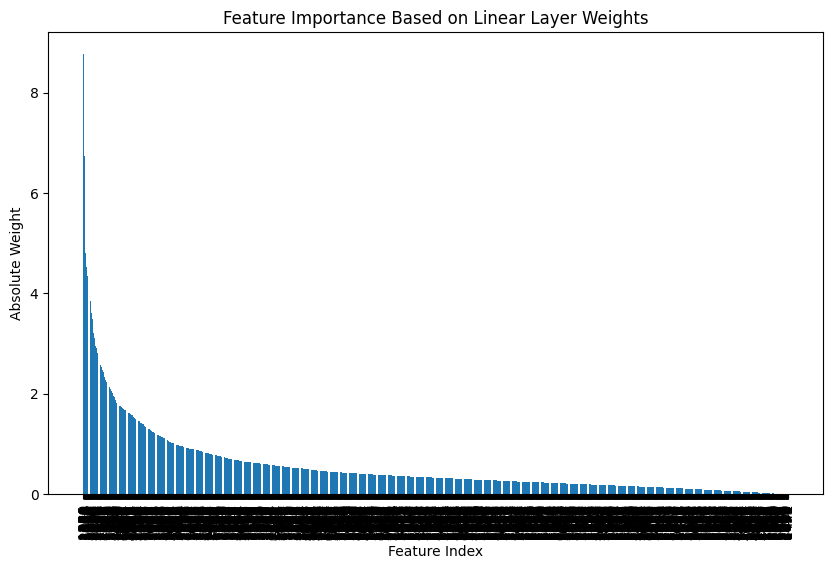

In [19]:
import matplotlib.pyplot as plt

# Convert to numpy array for easier manipulation
weights_np = weights.numpy().flatten()  # Flatten to 1D array

# Calculate the absolute values of the weights
abs_weights = np.abs(weights_np)

# Get the indices of the top features based on weight magnitude
top_features = abs_weights.argsort()[::-1]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(range(len(weights_np)), abs_weights[top_features])
plt.xlabel('Feature Index')
plt.ylabel('Absolute Weight')
plt.title('Feature Importance Based on Linear Layer Weights')
plt.xticks(range(len(weights_np)), top_features, rotation=90)
plt.show()

In [20]:
weights = best_model.l1.weight.data.numpy()
abs_weights = np.abs(weights.flatten())

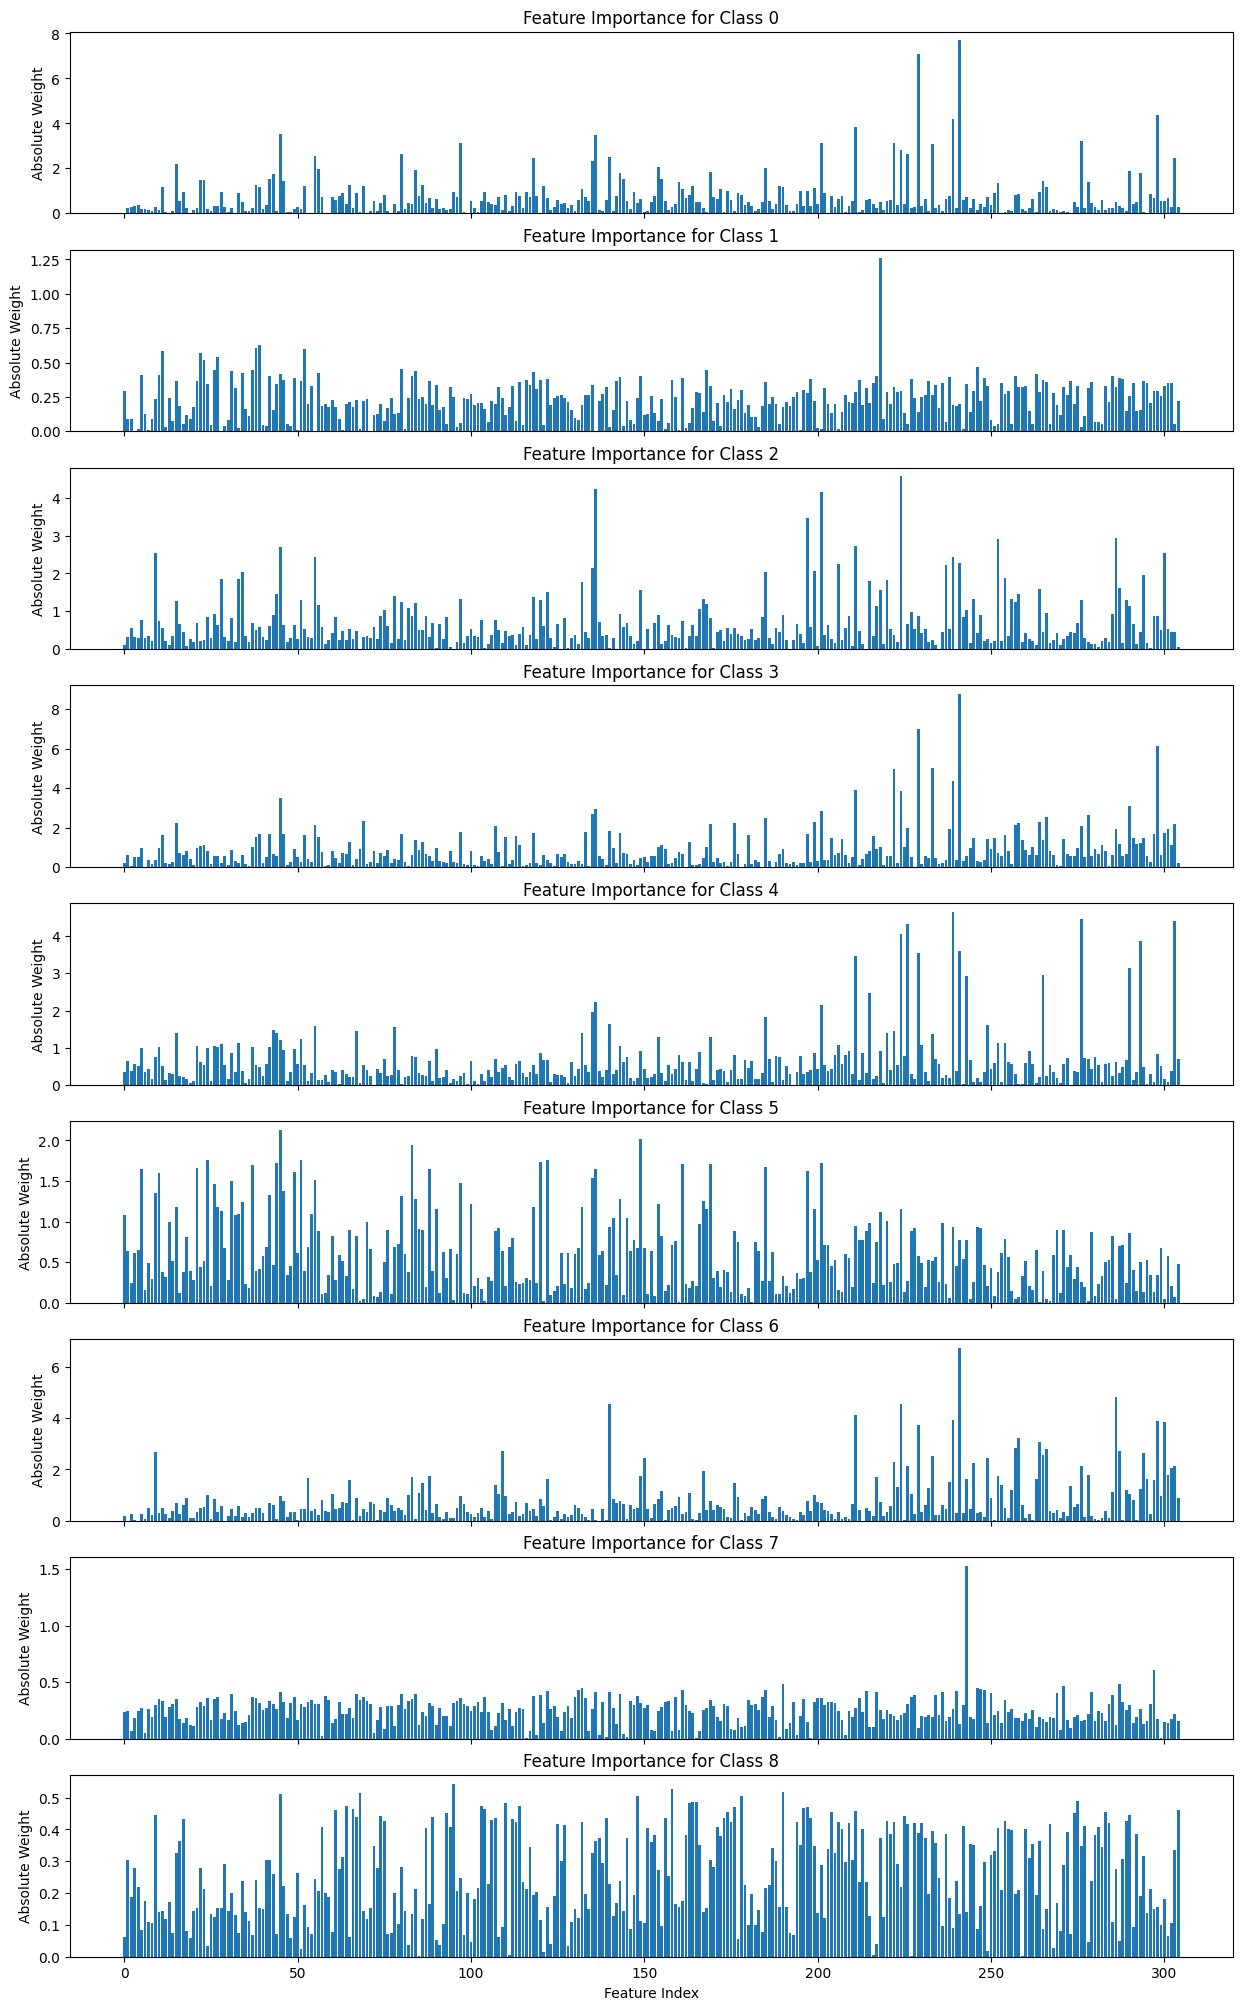

In [21]:
nrows = weights.shape[0]
xrows = weights.shape[1]

fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(15, 25), sharex=True)

for i in range(nrows):
    axes[i].bar(range(xrows), abs_weights[i*xrows:(i+1)*xrows])
    axes[i].set_title(f'Feature Importance for Class {i}')
    axes[i].set_ylabel('Absolute Weight')

plt.xlabel('Feature Index')
plt.show()

### Plotting Mean over Classes

In [22]:
from sklearn.preprocessing import minmax_scale

scaled_weights = minmax_scale(weights, axis=0)
weights_mean = np.abs(scaled_weights).mean(axis=0)

In [23]:
sorted_idx = weights_mean.argsort()[::-1]

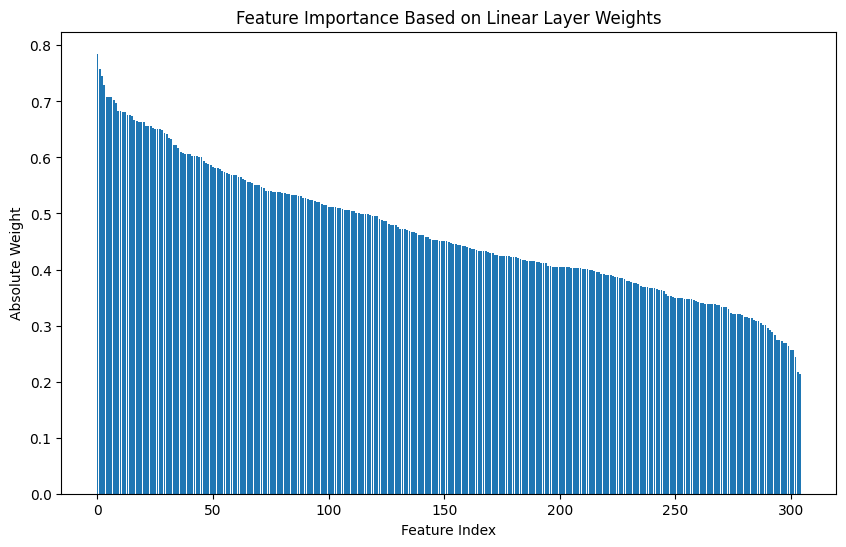

In [24]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(weights_mean[sorted_idx])), weights_mean[sorted_idx])
plt.xlabel('Feature Index')
plt.ylabel('Absolute Weight')
plt.title('Feature Importance Based on Linear Layer Weights')
# plt.xticks(sorted_idx, sorted_idx, rotation=90)
plt.show()

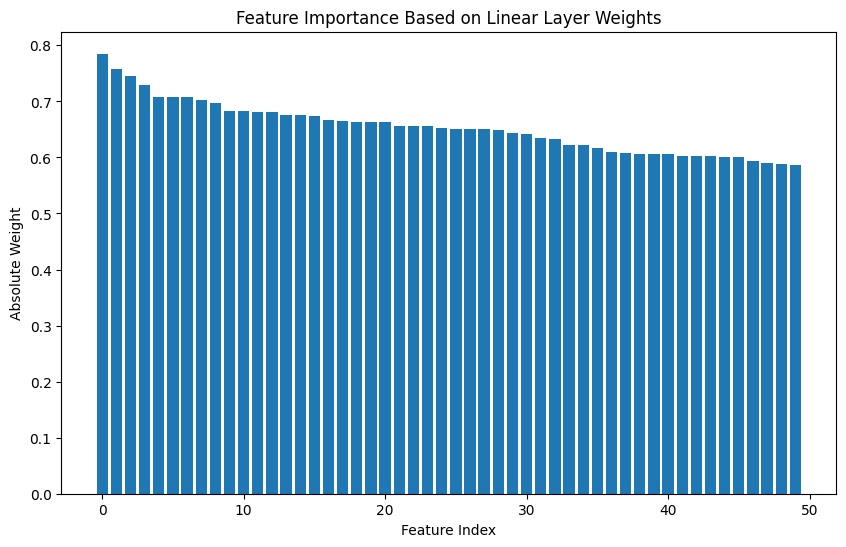

In [25]:
top_k = 50

plt.figure(figsize=(10, 6))
plt.bar(range(len(weights_mean[sorted_idx[:top_k]])), weights_mean[sorted_idx[:top_k]])
plt.xlabel('Feature Index')
plt.ylabel('Absolute Weight')
plt.title('Feature Importance Based on Linear Layer Weights')
# plt.xticks(sorted_idx[:20], sorted_idx[:20], rotation=90)
plt.show()

### Plotting top k per class

In [26]:
topk = 4

In [27]:
topk_indices = weights.argpartition( -topk, axis=1)[:, -topk:]
topk_indices.shape

(9, 4)

In [28]:
topk_indices_sorted = np.take_along_axis(topk_indices, np.argsort(-weights[np.arange(weights.shape[0])[:, None], topk_indices]), axis=1)
topk_indices_sorted.shape

(9, 4)

In [29]:
selected_features = np.array(list(set(topk_indices_sorted.flatten())))
selected_features.shape

(36,)

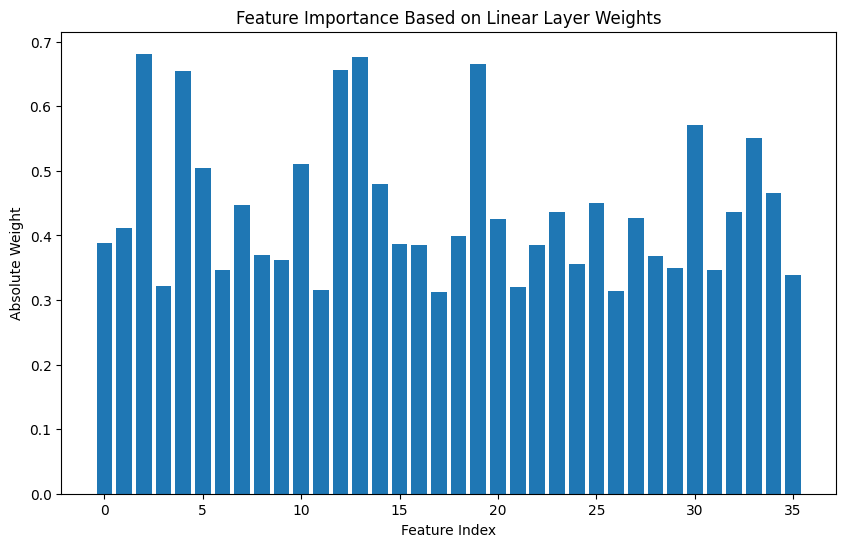

In [30]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(weights_mean[selected_features])), weights_mean[selected_features])
plt.xlabel('Feature Index')
plt.ylabel('Absolute Weight')
plt.title('Feature Importance Based on Linear Layer Weights')
# plt.xticks(sorted_idx[:20], sorted_idx[:20], rotation=90)
plt.show()

### Train again

In [31]:
vectors.iloc[:,selected_features].shape

(13228, 36)

In [32]:
subset = vectors.iloc[:,selected_features]
subset["label"] = df["label"]

/tmp/ipykernel_157994/650136668.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["label"] = df["label"]


In [33]:
# split into train and val
train, val = train_test_split(subset, test_size=0.2, random_state=SEED)

train_dataset = CustomeDataset(train)
train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True, num_workers=7)

val_dataset = CustomeDataset(val)
val_dataloader = DataLoader(val_dataset, batch_size=500, shuffle=False, num_workers=7)

# trainer = lightning.Trainer(fast_dev_run=100)
monitor = "Validation/Accuracy"
early_stop_callback = EarlyStopping(monitor=monitor, patience=5, verbose=True, mode="max")
checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor=monitor, mode="max")

tensorboard = pl_loggers.TensorBoardLogger(save_dir=LOG_PATH, name=LOG_NAME_EXPERIMENT_2)
trainer = lightning.Trainer(max_epochs=150, callbacks=[early_stop_callback, checkpoint_callback], enable_checkpointing=True, logger=tensorboard) #logger=None, 


model = MalwaresModelLinearLayer(input_size = subset.shape[1]-1, output_size = len(label_encoder.classes_), seed=SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [34]:
trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                      | Params
------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0     
1 | val_metrics   | MetricCollection          | 0     
2 | test_metrics  | MetricCollection          | 0     
3 | cm            | MulticlassConfusionMatrix | 0     
4 | criterion     | CrossEntropyLoss          | 0     
5 | l1            | Linear                    | 333   
------------------------------------------------------------
333       Trainable params
0         Non-trainable params
333       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 0
ValidationEpoch/CM
 tensor([[  0,   0,   0,   0,   0,   0, 120,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,  89],
        [  0,   0,   0,   0,   0,   0, 129,   0,   0],
        [  0,   0,   0,   0,   0,   0, 116,   0,   0],
        [  0,   0,   0,   0,   0,   0, 123,   0,   0],
        [  0,   0,   0,   0,   0,   0,  92,   0,   0],
        [  0,   0,   0,   0,   0,   0, 120,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,  82],
        [  2,   0,   0,   0,   0,   0, 127,   0,   0]])


/home/<User>/repos/csg_is/.venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 1
ValidationEpoch/CM
 tensor([[   0,   24,  941,    0,    6,   28,  474,   37,    0],
        [   0, 1267,    0,    0,    0,    0,    0,    0,  282],
        [   0,   10, 1029,    0,    0,   64,  551,  201,    2],
        [   0,   17, 1025,    0,    6,   16,  462,   30,    0],
        [   0,   39,  761,    0,  299,    2,  459,    3,    0],
        [   0,   84,   10,    0,    0,  517,  328,  593,    0],
        [   0,    6,  897,    0,    3,   59,  481,  119,    0],
        [   0,  198,    0,    0,    0,   87,    0,  973,  264],
        [   2,  246,    0,    0,    0,    0,  316,    0, 1010]])
Epoch end: Train, epoch number: 0
TrainEpoch/CM
 tensor([[   0,   24,  941,    0,    6,   28,  474,   37,    0],
        [   0, 1267,    0,    0,    0,    0,    0,    0,  282],
        [   0,   10, 1029,    0,    0,   64,  551,  201,    2],
        [   0,   17, 1025,    0,    6,   16,  462,   30,    0],
        [   0,   39,  761,    0,  299,    2,  459,    3,   

Metric Validation/Accuracy improved. New best score: 0.604


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 2
ValidationEpoch/CM
 tensor([[   0,   24, 2290,    0,   47,   28,  474,   37,    0],
        [   0, 2727,    0,    0,    0,    0,    0,    0,  282],
        [   0,   22, 2745,    0,    0,   64,  551,  201,    2],
        [   0,   17, 2416,    5,   46,   16,  466,   30,    0],
        [   0,   39,  894,    0, 1606,    2,  459,    3,    0],
        [   0,   97,  227,    0,    0, 1690,  328,  630,    0],
        [   0,    6, 2331,    0,   14,   59,  481,  119,    0],
        [   0,  198,    0,    0,    0,   87,    0, 2413,  264],
        [   2,  246,    0,    0,    0,    0,  316,    0, 2455]])


Metric Validation/Accuracy improved by 0.048 >= min_delta = 0.0. New best score: 0.652


Epoch end: Train, epoch number: 1
TrainEpoch/CM
 tensor([[   0,   24, 2290,    0,   47,   28,  474,   37,    0],
        [   0, 2727,    0,    0,    0,    0,    0,    0,  282],
        [   0,   22, 2745,    0,    0,   64,  551,  201,    2],
        [   0,   17, 2416,    5,   46,   16,  466,   30,    0],
        [   0,   39,  894,    0, 1606,    2,  459,    3,    0],
        [   0,   97,  227,    0,    0, 1690,  328,  630,    0],
        [   0,    6, 2331,    0,   14,   59,  481,  119,    0],
        [   0,  198,    0,    0,    0,   87,    0, 2413,  264],
        [   2,  246,    0,    0,    0,    0,  316,    0, 2455]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 3
ValidationEpoch/CM
 tensor([[ 207,   24, 2844,  622,   50,   28,  478,   37,    0],
        [   0, 4187,    0,    0,    0,    0,    0,    0,  282],
        [   0,   27, 4461,    0,    7,   64,  551,  201,    2],
        [  18,   17, 3084,  735,   65,   16,  471,   30,    0],
        [   0,   39,  936,    0, 3003,    3,  459,    3,    0],
        [   0,  103,  256,    0,    4, 3091,  328,  630,    0],
        [   0,    6, 3737,   27,   19,   59,  488,  119,    0],
        [   0,  198,    0,    0,    0,   87,    0, 3853,  264],
        [   2,  246,    0,    0,    0,    0,  316,    0, 3900]])
Epoch end: Train, epoch number: 2
TrainEpoch/CM
 tensor([[ 207,   24, 2844,  622,   50,   28,  478,   37,    0],
        [   0, 4187,    0,    0,    0,    0,    0,    0,  282],
        [   0,   27, 4461,    0,    7,   64,  551,  201,    2],
        [  18,   17, 3084,  735,   65,   16,  471,   30,    0],
        [   0,   39,  936,    0, 3003,    3,  459,    3,   

Metric Validation/Accuracy improved by 0.122 >= min_delta = 0.0. New best score: 0.774


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 4
ValidationEpoch/CM
 tensor([[ 865,   24, 2930, 1253,   61,   28,  482,   37,    0],
        [   0, 5647,    0,    0,    0,    0,    0,    0,  282],
        [   0,   27, 6177,    0,   19,   64,  551,  201,    2],
        [  68,   17, 3290, 1848,  131,   16,  476,   30,    0],
        [   0,   39,  936,    0, 4443,    3,  459,    3,    0],
        [   0,  108,  262,    0,    9, 4515,  328,  630,    0],
        [  10,    6, 5094,   87,   31,   59,  494,  119,    0],
        [   0,  198,    0,    0,    0,   87,    0, 5293,  264],
        [   2,  246,    0,    0,    0,    0,  316,    0, 5345]])


Metric Validation/Accuracy improved by 0.038 >= min_delta = 0.0. New best score: 0.812


Epoch end: Train, epoch number: 3
TrainEpoch/CM
 tensor([[ 865,   24, 2930, 1253,   61,   28,  482,   37,    0],
        [   0, 5647,    0,    0,    0,    0,    0,    0,  282],
        [   0,   27, 6177,    0,   19,   64,  551,  201,    2],
        [  68,   17, 3290, 1848,  131,   16,  476,   30,    0],
        [   0,   39,  936,    0, 4443,    3,  459,    3,    0],
        [   0,  108,  262,    0,    9, 4515,  328,  630,    0],
        [  10,    6, 5094,   87,   31,   59,  494,  119,    0],
        [   0,  198,    0,    0,    0,   87,    0, 5293,  264],
        [   2,  246,    0,    0,    0,    0,  316,    0, 5345]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 5
ValidationEpoch/CM
 tensor([[1832,   24, 2936, 1668,   61,   28,  484,   37,    0],
        [   0, 7105,    0,    0,    0,    2,    0,    0,  282],
        [   0,   27, 7886,    0,   31,   71,  551,  201,    2],
        [ 204,   17, 3333, 3064,  159,   16,  493,   30,    0],
        [   0,   39,  936,    0, 5883,    3,  459,    3,    0],
        [   0,  113,  262,    0,   14, 5945,  328,  630,    0],
        [  66,    6, 6304,  235,   34,   59,  522,  119,    0],
        [   0,  198,    0,    0,    0,   87,    0, 6733,  264],
        [   2,  246,    0,    0,    0,    0,  316,    0, 6790]])
Epoch end: Train, epoch number: 4


Metric Validation/Accuracy improved by 0.017 >= min_delta = 0.0. New best score: 0.829


TrainEpoch/CM
 tensor([[1832,   24, 2936, 1668,   61,   28,  484,   37,    0],
        [   0, 7105,    0,    0,    0,    2,    0,    0,  282],
        [   0,   27, 7886,    0,   31,   71,  551,  201,    2],
        [ 204,   17, 3333, 3064,  159,   16,  493,   30,    0],
        [   0,   39,  936,    0, 5883,    3,  459,    3,    0],
        [   0,  113,  262,    0,   14, 5945,  328,  630,    0],
        [  66,    6, 6304,  235,   34,   59,  522,  119,    0],
        [   0,  198,    0,    0,    0,   87,    0, 6733,  264],
        [   2,  246,    0,    0,    0,    0,  316,    0, 6790]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 6
ValidationEpoch/CM
 tensor([[2856,   24, 2938, 2032,   61,   28,  484,   37,    0],
        [   0, 8560,    0,    0,    0,    7,    0,    0,  282],
        [   0,   27, 9596,    0,   43,   77,  551,  201,    2],
        [ 325,   17, 3348, 4342,  179,   16,  499,   30,    0],
        [   0,   39,  936,    0, 7323,    3,  459,    3,    0],
        [   0,  118,  262,    0,   19, 7375,  328,  630,    0],
        [ 145,    6, 7447,  445,   38,   59,  531,  119,    0],
        [   0,  198,    0,    0,    0,   87,    0, 8173,  264],
        [   2,  246,    0,    0,    0,    0,  316,    0, 8235]])
Epoch end: Train, epoch number: 5
TrainEpoch/CM
 tensor([[2856,   24, 2938, 2032,   61,   28,  484,   37,    0],
        [   0, 8560,    0,    0,    0,    7,    0,    0,  282],
        [   0,   27, 9596,    0,   43,   77,  551,  201,    2],
        [ 325,   17, 3348, 4342,  179,   16,  499,   30,    0],
        [   0,   39,  936,    0, 7323,    3,  459,    3,   

Metric Validation/Accuracy improved by 0.016 >= min_delta = 0.0. New best score: 0.844


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 7
ValidationEpoch/CM
 tensor([[ 3710,    24,  2938,  2568,    61,    28,   484,    37,     0],
        [    0, 10015,     0,     0,     0,    12,     0,     0,   282],
        [    0,    27, 11301,     0,    55,    88,   551,   201,     2],
        [  380,    17,  3358,  5666,   213,    16,   516,    30,     0],
        [    0,    39,   936,     0,  8763,     3,   459,     3,     0],
        [    0,   123,   262,     0,    24,  8805,   328,   630,     0],
        [  191,     6,  8511,   703,    46,    59,   600,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0,  9613,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0,  9680]])
Epoch end: Train, epoch number: 6
TrainEpoch/CM
 tensor([[ 3710,    24,  2938,  2568,    61,    28,   484,    37,     0],
        [    0, 10015,     0,     0,     0,    12,     0,     0,   282],
        [    0,    27, 11301,     0,    55,    88,   551,   201,     2],
        [  380,

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 8
ValidationEpoch/CM
 tensor([[ 4655,    24,  2938,  3013,    61,    28,   484,    37,     0],
        [    0, 11470,     0,     0,     0,    17,     0,     0,   282],
        [    0,    27, 13011,     0,    67,    94,   551,   201,     2],
        [  475,    17,  3368,  6979,   228,    16,   523,    30,     0],
        [    0,    39,   936,     0, 10203,     3,   459,     3,     0],
        [    0,   128,   262,     0,    29, 10235,   328,   630,     0],
        [  269,     6,  9550,   992,    49,    59,   636,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 11053,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 11125]])


Metric Validation/Accuracy improved by 0.011 >= min_delta = 0.0. New best score: 0.855


Epoch end: Train, epoch number: 7
TrainEpoch/CM
 tensor([[ 4655,    24,  2938,  3013,    61,    28,   484,    37,     0],
        [    0, 11470,     0,     0,     0,    17,     0,     0,   282],
        [    0,    27, 13011,     0,    67,    94,   551,   201,     2],
        [  475,    17,  3368,  6979,   228,    16,   523,    30,     0],
        [    0,    39,   936,     0, 10203,     3,   459,     3,     0],
        [    0,   128,   262,     0,    29, 10235,   328,   630,     0],
        [  269,     6,  9550,   992,    49,    59,   636,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 11053,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 11125]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 9
ValidationEpoch/CM
 tensor([[ 5927,    24,  2938,  3131,    61,    28,   484,    37,     0],
        [    0, 12925,     0,     0,     0,    22,     0,     0,   282],
        [    0,    27, 14692,     0,    79,   115,   565,   201,     2],
        [  646,    17,  3375,  8199,   243,    16,   550,    30,     0],
        [    0,    39,   936,     0, 11643,     3,   459,     3,     0],
        [    0,   133,   262,     0,    34, 11665,   328,   630,     0],
        [  393,     6, 10504,  1215,    50,    62,   776,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 12493,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 12570]])


Metric Validation/Accuracy improved by 0.007 >= min_delta = 0.0. New best score: 0.861


Epoch end: Train, epoch number: 8
TrainEpoch/CM
 tensor([[ 5927,    24,  2938,  3131,    61,    28,   484,    37,     0],
        [    0, 12925,     0,     0,     0,    22,     0,     0,   282],
        [    0,    27, 14692,     0,    79,   115,   565,   201,     2],
        [  646,    17,  3375,  8199,   243,    16,   550,    30,     0],
        [    0,    39,   936,     0, 11643,     3,   459,     3,     0],
        [    0,   133,   262,     0,    34, 11665,   328,   630,     0],
        [  393,     6, 10504,  1215,    50,    62,   776,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 12493,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 12570]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 10
ValidationEpoch/CM
 tensor([[ 7093,    24,  2940,  3353,    61,    28,   484,    37,     0],
        [    0, 14380,     0,     0,     0,    27,     0,     0,   282],
        [    0,    27, 16394,     0,    91,   124,   570,   201,     2],
        [  771,    17,  3385,  9483,   258,    16,   556,    30,     0],
        [    0,    39,   936,     0, 13083,     3,   459,     3,     0],
        [    0,   138,   262,     0,    39, 13095,   328,   630,     0],
        [  494,     6, 11524,  1480,    50,    62,   835,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 13933,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 14015]])
Epoch end: Train, epoch number: 9
TrainEpoch/CM
 tensor([[ 7093,    24,  2940,  3353,    61,    28,   484,    37,     0],
        [    0, 14380,     0,     0,     0,    27,     0,     0,   282],
        [    0,    27, 16394,     0,    91,   124,   570,   201,     2],
        [  771

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 11
ValidationEpoch/CM
 tensor([[ 8280,    24,  2940,  3556,    61,    28,   484,    37,     0],
        [    0, 15835,     0,     0,     0,    32,     0,     0,   282],
        [    0,    27, 18086,     2,   103,   134,   582,   201,     2],
        [  892,    17,  3395, 10759,   273,    16,   574,    30,     0],
        [    0,    39,   936,     0, 14523,     3,   459,     3,     0],
        [    0,   143,   262,     0,    44, 14525,   328,   630,     0],
        [  598,     6, 12465,  1747,    53,    62,   965,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 15373,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 15460]])
Epoch end: Train, epoch number: 10
TrainEpoch/CM
 tensor([[ 8280,    24,  2940,  3556,    61,    28,   484,    37,     0],
        [    0, 15835,     0,     0,     0,    32,     0,     0,   282],
        [    0,    27, 18086,     2,   103,   134,   582,   201,     2],
        [  89

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 12
ValidationEpoch/CM
 tensor([[ 9498,    24,  2940,  3728,    61,    28,   484,    37,     0],
        [    0, 17293,     0,     0,     0,    34,     0,     0,   282],
        [    0,    27, 19766,     9,   115,   154,   591,   201,     2],
        [ 1034,    17,  3405, 12028,   286,    16,   580,    30,     0],
        [    0,    39,   936,     0, 15963,     3,   459,     3,     0],
        [    0,   148,   262,     0,    49, 15955,   328,   630,     0],
        [  729,     6, 13377,  2045,    55,    64,  1065,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 16813,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 16905]])


Metric Validation/Accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.868


Epoch end: Train, epoch number: 11
TrainEpoch/CM
 tensor([[ 9498,    24,  2940,  3728,    61,    28,   484,    37,     0],
        [    0, 17293,     0,     0,     0,    34,     0,     0,   282],
        [    0,    27, 19766,     9,   115,   154,   591,   201,     2],
        [ 1034,    17,  3405, 12028,   286,    16,   580,    30,     0],
        [    0,    39,   936,     0, 15963,     3,   459,     3,     0],
        [    0,   148,   262,     0,    49, 15955,   328,   630,     0],
        [  729,     6, 13377,  2045,    55,    64,  1065,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 16813,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 16905]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 13
ValidationEpoch/CM
 tensor([[10725,    24,  2940,  3891,    61,    28,   484,    37,     0],
        [    0, 18753,     0,     0,     0,    34,     0,     0,   282],
        [    0,    27, 21453,    19,   122,   166,   603,   201,     2],
        [ 1177,    17,  3413, 13298,   296,    16,   589,    30,     0],
        [    0,    39,   936,     0, 17403,     3,   459,     3,     0],
        [    0,   153,   262,     0,    54, 17385,   328,   630,     0],
        [  850,     6, 14268,  2337,    55,    64,  1206,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 18253,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 18350]])
Epoch end: Train, epoch number: 12
TrainEpoch/CM
 tensor([[10725,    24,  2940,  3891,    61,    28,   484,    37,     0],
        [    0, 18753,     0,     0,     0,    34,     0,     0,   282],
        [    0,    27, 21453,    19,   122,   166,   603,   201,     2],
        [ 117

Metric Validation/Accuracy improved by 0.007 >= min_delta = 0.0. New best score: 0.875


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 14
ValidationEpoch/CM
 tensor([[12063,    24,  2940,  3943,    61,    28,   484,    37,     0],
        [    0, 20213,     0,     0,     0,    34,     0,     0,   282],
        [    8,    27, 23140,    19,   131,   178,   615,   201,     2],
        [ 1376,    17,  3422, 14505,   309,    16,   601,    30,     0],
        [    0,    39,   936,     0, 18843,     3,   459,     3,     0],
        [    0,   158,   262,     0,    59, 18815,   328,   630,     0],
        [ 1026,     6, 15168,  2567,    56,    64,  1344,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 19693,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 19795]])
Epoch end: Train, epoch number: 13
TrainEpoch/CM
 tensor([[12063,    24,  2940,  3943,    61,    28,   484,    37,     0],
        [    0, 20213,     0,     0,     0,    34,     0,     0,   282],
        [    8,    27, 23140,    19,   131,   178,   615,   201,     2],
        [ 137

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 15
ValidationEpoch/CM
 tensor([[13379,    24,  2940,  4017,    61,    28,   484,    37,     0],
        [    0, 21673,     0,     0,     0,    34,     0,     0,   282],
        [    8,    27, 24832,    21,   131,   190,   637,   201,     2],
        [ 1550,    17,  3427, 15735,   319,    16,   622,    30,     0],
        [    0,    39,   936,     0, 20283,     3,   459,     3,     0],
        [    0,   163,   262,     0,    64, 20245,   328,   630,     0],
        [ 1148,     6, 15999,  2818,    56,    64,  1585,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 21133,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 21240]])


Metric Validation/Accuracy improved by 0.008 >= min_delta = 0.0. New best score: 0.883


Epoch end: Train, epoch number: 14
TrainEpoch/CM
 tensor([[13379,    24,  2940,  4017,    61,    28,   484,    37,     0],
        [    0, 21673,     0,     0,     0,    34,     0,     0,   282],
        [    8,    27, 24832,    21,   131,   190,   637,   201,     2],
        [ 1550,    17,  3427, 15735,   319,    16,   622,    30,     0],
        [    0,    39,   936,     0, 20283,     3,   459,     3,     0],
        [    0,   163,   262,     0,    64, 20245,   328,   630,     0],
        [ 1148,     6, 15999,  2818,    56,    64,  1585,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 21133,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 21240]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 16
ValidationEpoch/CM
 tensor([[14689,    24,  2940,  4097,    61,    28,   484,    37,     0],
        [    0, 23133,     0,     0,     0,    34,     0,     0,   282],
        [    8,    27, 26518,    21,   132,   204,   664,   201,     2],
        [ 1700,    17,  3433, 16989,   330,    16,   641,    30,     0],
        [    0,    39,   936,     0, 21723,     3,   459,     3,     0],
        [    0,   168,   262,     0,    69, 21675,   328,   630,     0],
        [ 1266,     6, 16816,  3080,    56,    64,  1833,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 22573,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 22685]])
Epoch end: Train, epoch number: 15
TrainEpoch/CM
 tensor([[14689,    24,  2940,  4097,    61,    28,   484,    37,     0],
        [    0, 23133,     0,     0,     0,    34,     0,     0,   282],
        [    8,    27, 26518,    21,   132,   204,   664,   201,     2],
        [ 170

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 17
ValidationEpoch/CM
 tensor([[15977,    24,  2940,  4199,    61,    28,   484,    37,     0],
        [    0, 24593,     0,     0,     0,    34,     0,     0,   282],
        [    8,    27, 28221,    26,   132,   216,   672,   201,     2],
        [ 1847,    17,  3442, 18256,   341,    16,   647,    30,     0],
        [    0,    39,   936,     0, 23163,     3,   459,     3,     0],
        [    0,   173,   262,     0,    74, 23105,   328,   630,     0],
        [ 1387,     6, 17720,  3347,    56,    64,  1986,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 24013,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 24130]])
Epoch end: Train, epoch number: 16
TrainEpoch/CM
 tensor([[15977,    24,  2940,  4199,    61,    28,   484,    37,     0],
        [    0, 24593,     0,     0,     0,    34,     0,     0,   282],
        [    8,    27, 28221,    26,   132,   216,   672,   201,     2],
        [ 184

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.884


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 18
ValidationEpoch/CM
 tensor([[17307,    24,  2940,  4259,    61,    28,   484,    37,     0],
        [    0, 26053,     0,     0,     0,    34,     0,     0,   282],
        [    8,    27, 29913,    26,   132,   228,   696,   201,     2],
        [ 2000,    17,  3448, 19508,   351,    16,   666,    30,     0],
        [    0,    39,   936,     0, 24603,     3,   459,     3,     0],
        [    0,   178,   262,     0,    79, 24535,   328,   630,     0],
        [ 1497,     6, 18562,  3598,    56,    64,  2228,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 25453,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 25575]])
Epoch end: Train, epoch number: 17
TrainEpoch/CM
 tensor([[17307,    24,  2940,  4259,    61,    28,   484,    37,     0],
        [    0, 26053,     0,     0,     0,    34,     0,     0,   282],
        [    8,    27, 29913,    26,   132,   228,   696,   201,     2],
        [ 200

Metric Validation/Accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.889


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 19
ValidationEpoch/CM
 tensor([[18648,    24,  2940,  4308,    61,    28,   484,    37,     0],
        [    0, 27513,     0,     0,     0,    34,     0,     0,   282],
        [    8,    27, 31571,    26,   132,   240,   754,   201,     2],
        [ 2171,    17,  3453, 20737,   361,    16,   691,    30,     0],
        [    0,    39,   936,     0, 26043,     3,   459,     3,     0],
        [    0,   183,   262,     0,    82, 25967,   328,   630,     0],
        [ 1595,     6, 19317,  3842,    56,    66,  2574,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 26893,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 27020]])
Epoch end: Train, epoch number: 18
TrainEpoch/CM
 tensor([[18648,    24,  2940,  4308,    61,    28,   484,    37,     0],
        [    0, 27513,     0,     0,     0,    34,     0,     0,   282],
        [    8,    27, 31571,    26,   132,   240,   754,   201,     2],
        [ 217

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 20
ValidationEpoch/CM
 tensor([[19982,    24,  2940,  4364,    61,    28,   484,    37,     0],
        [    0, 28973,     0,     0,     0,    34,     0,     0,   282],
        [   14,    27, 33254,    26,   132,   252,   781,   201,     2],
        [ 2327,    17,  3458, 21986,   371,    16,   711,    30,     0],
        [    0,    39,   936,     0, 27483,     3,   459,     3,     0],
        [    0,   188,   262,     0,    86, 27398,   328,   630,     0],
        [ 1702,     6, 20116,  4099,    56,    66,  2856,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 28333,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 28465]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.891


Epoch end: Train, epoch number: 19
TrainEpoch/CM
 tensor([[19982,    24,  2940,  4364,    61,    28,   484,    37,     0],
        [    0, 28973,     0,     0,     0,    34,     0,     0,   282],
        [   14,    27, 33254,    26,   132,   252,   781,   201,     2],
        [ 2327,    17,  3458, 21986,   371,    16,   711,    30,     0],
        [    0,    39,   936,     0, 27483,     3,   459,     3,     0],
        [    0,   188,   262,     0,    86, 27398,   328,   630,     0],
        [ 1702,     6, 20116,  4099,    56,    66,  2856,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 28333,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 28465]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 21
ValidationEpoch/CM
 tensor([[21315,    24,  2940,  4421,    61,    28,   484,    37,     0],
        [    0, 30433,     0,     0,     0,    34,     0,     0,   282],
        [   14,    27, 34937,    26,   132,   264,   814,   201,     2],
        [ 2477,    17,  3463, 23241,   381,    16,   731,    30,     0],
        [    0,    39,   936,     0, 28923,     3,   459,     3,     0],
        [    0,   193,   262,     0,    86, 28833,   328,   630,     0],
        [ 1799,     6, 20904,  4353,    56,    66,  3162,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 29773,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 29910]])
Epoch end: Train, epoch number: 20
TrainEpoch/CM
 tensor([[21315,    24,  2940,  4421,    61,    28,   484,    37,     0],
        [    0, 30433,     0,     0,     0,    34,     0,     0,   282],
        [   14,    27, 34937,    26,   132,   264,   814,   201,     2],
        [ 247

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.892


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 22
ValidationEpoch/CM
 tensor([[22643,    24,  2940,  4483,    61,    28,   484,    37,     0],
        [    0, 31893,     0,     0,     0,    34,     0,     0,   282],
        [   14,    27, 36581,    26,   132,   276,   886,   201,     2],
        [ 2613,    17,  3468, 24496,   391,    16,   765,    30,     0],
        [    0,    39,   936,     0, 30363,     3,   459,     3,     0],
        [    0,   198,   262,     0,    89, 30265,   328,   630,     0],
        [ 1874,     6, 21599,  4598,    56,    66,  3592,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 31213,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 31355]])
Epoch end: Train, epoch number: 21
TrainEpoch/CM
 tensor([[22643,    24,  2940,  4483,    61,    28,   484,    37,     0],
        [    0, 31893,     0,     0,     0,    34,     0,     0,   282],
        [   14,    27, 36581,    26,   132,   276,   886,   201,     2],
        [ 261

Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.892


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 23
ValidationEpoch/CM
 tensor([[24007,    24,  2940,  4509,    61,    28,   484,    37,     0],
        [    0, 33353,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 38259,    26,   132,   288,   918,   201,     2],
        [ 2796,    17,  3475, 25718,   401,    16,   783,    30,     0],
        [    0,    39,   936,     0, 31803,     3,   459,     3,     0],
        [    0,   203,   262,     0,    89, 31700,   328,   630,     0],
        [ 1992,     6, 22399,  4834,    56,    66,  3883,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 32653,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 32800]])


Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.895


Epoch end: Train, epoch number: 22
TrainEpoch/CM
 tensor([[24007,    24,  2940,  4509,    61,    28,   484,    37,     0],
        [    0, 33353,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 38259,    26,   132,   288,   918,   201,     2],
        [ 2796,    17,  3475, 25718,   401,    16,   783,    30,     0],
        [    0,    39,   936,     0, 31803,     3,   459,     3,     0],
        [    0,   203,   262,     0,    89, 31700,   328,   630,     0],
        [ 1992,     6, 22399,  4834,    56,    66,  3883,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 32653,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 32800]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 24
ValidationEpoch/CM
 tensor([[25317,    24,  2940,  4589,    61,    28,   484,    37,     0],
        [    0, 34813,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 39909,    26,   132,   300,   984,   201,     2],
        [ 2925,    17,  3480, 26991,   407,    16,   810,    30,     0],
        [    0,    39,   936,     0, 33243,     3,   459,     3,     0],
        [    0,   208,   262,     0,    89, 33135,   328,   630,     0],
        [ 2077,     6, 23119,  5096,    56,    66,  4261,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 34093,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 34245]])
Epoch end: Train, epoch number: 23
TrainEpoch/CM
 tensor([[25317,    24,  2940,  4589,    61,    28,   484,    37,     0],
        [    0, 34813,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 39909,    26,   132,   300,   984,   201,     2],
        [ 292

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 25
ValidationEpoch/CM
 tensor([[26690,    24,  2940,  4606,    61,    28,   484,    37,     0],
        [    0, 36273,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 41567,    26,   132,   312,  1042,   201,     2],
        [ 3127,    17,  3485, 28180,   417,    16,   844,    30,     0],
        [    0,    39,   936,     0, 34683,     3,   459,     3,     0],
        [    0,   213,   262,     0,    89, 34570,   328,   630,     0],
        [ 2160,     6, 23852,  5286,    56,    66,  4700,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 35533,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 35690]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.895


Epoch end: Train, epoch number: 24
TrainEpoch/CM
 tensor([[26690,    24,  2940,  4606,    61,    28,   484,    37,     0],
        [    0, 36273,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 41567,    26,   132,   312,  1042,   201,     2],
        [ 3127,    17,  3485, 28180,   417,    16,   844,    30,     0],
        [    0,    39,   936,     0, 34683,     3,   459,     3,     0],
        [    0,   213,   262,     0,    89, 34570,   328,   630,     0],
        [ 2160,     6, 23852,  5286,    56,    66,  4700,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 35533,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 35690]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 26
ValidationEpoch/CM
 tensor([[28031,    24,  2940,  4655,    61,    28,   484,    37,     0],
        [    0, 37733,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 43239,    26,   132,   324,  1086,   201,     2],
        [ 3271,    17,  3490, 29449,   422,    16,   861,    30,     0],
        [    0,    39,   936,     0, 36123,     3,   459,     3,     0],
        [    0,   218,   262,     0,    89, 36005,   328,   630,     0],
        [ 2247,     6, 24603,  5547,    56,    66,  5046,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 36973,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 37135]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.897


Epoch end: Train, epoch number: 25
TrainEpoch/CM
 tensor([[28031,    24,  2940,  4655,    61,    28,   484,    37,     0],
        [    0, 37733,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 43239,    26,   132,   324,  1086,   201,     2],
        [ 3271,    17,  3490, 29449,   422,    16,   861,    30,     0],
        [    0,    39,   936,     0, 36123,     3,   459,     3,     0],
        [    0,   218,   262,     0,    89, 36005,   328,   630,     0],
        [ 2247,     6, 24603,  5547,    56,    66,  5046,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 36973,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 37135]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 27
ValidationEpoch/CM
 tensor([[29374,    24,  2940,  4702,    61,    28,   484,    37,     0],
        [    0, 39193,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 44903,    26,   132,   336,  1138,   201,     2],
        [ 3410,    17,  3495, 30711,   427,    16,   890,    30,     0],
        [    0,    39,   936,     0, 37563,     3,   459,     3,     0],
        [    0,   223,   262,     0,    89, 37440,   328,   630,     0],
        [ 2324,     6, 25322,  5788,    56,    66,  5454,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 38413,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 38580]])
Epoch end: Train, epoch number: 26
TrainEpoch/CM
 tensor([[29374,    24,  2940,  4702,    61,    28,   484,    37,     0],
        [    0, 39193,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 44903,    26,   132,   336,  1138,   201,     2],
        [ 341

Metric Validation/Accuracy improved by 0.008 >= min_delta = 0.0. New best score: 0.905


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 28
ValidationEpoch/CM
 tensor([[30727,    24,  2940,  4739,    61,    28,   484,    37,     0],
        [    0, 40653,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 46540,    26,   132,   348,  1217,   201,     2],
        [ 3557,    17,  3500, 31950,   432,    16,   934,    30,     0],
        [    0,    39,   936,     0, 39003,     3,   459,     3,     0],
        [    0,   228,   262,     0,    89, 38875,   328,   630,     0],
        [ 2383,     6, 25973,  5990,    56,    66,  5987,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 39853,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 40025]])
Epoch end: Train, epoch number: 27
TrainEpoch/CM
 tensor([[30727,    24,  2940,  4739,    61,    28,   484,    37,     0],
        [    0, 40653,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 46540,    26,   132,   348,  1217,   201,     2],
        [ 355

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 29
ValidationEpoch/CM
 tensor([[32081,    24,  2940,  4775,    61,    28,   484,    37,     0],
        [    0, 42113,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 48201,    26,   132,   360,  1272,   201,     2],
        [ 3707,    17,  3505, 33197,   441,    16,   963,    30,     0],
        [    0,    39,   936,     0, 40443,     3,   459,     3,     0],
        [    0,   233,   262,     0,    89, 40310,   328,   630,     0],
        [ 2452,     6, 26684,  6215,    56,    66,  6427,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 41293,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 41470]])
Epoch end: Train, epoch number: 28
TrainEpoch/CM
 tensor([[32081,    24,  2940,  4775,    61,    28,   484,    37,     0],
        [    0, 42113,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 48201,    26,   132,   360,  1272,   201,     2],
        [ 370

Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.909


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 30
ValidationEpoch/CM
 tensor([[33429,    24,  2940,  4817,    61,    28,   484,    37,     0],
        [    0, 43573,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 49849,    26,   132,   372,  1340,   201,     2],
        [ 3836,    17,  3510, 34456,   446,    16,  1005,    30,     0],
        [    0,    39,   936,     0, 41883,     3,   459,     3,     0],
        [    0,   238,   262,     0,    89, 41745,   328,   630,     0],
        [ 2508,     6, 27334,  6426,    56,    66,  6955,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 42733,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 42915]])
Epoch end: Train, epoch number: 29
TrainEpoch/CM
 tensor([[33429,    24,  2940,  4817,    61,    28,   484,    37,     0],
        [    0, 43573,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 49849,    26,   132,   372,  1340,   201,     2],
        [ 383

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 31
ValidationEpoch/CM
 tensor([[34801,    24,  2940,  4835,    61,    28,   484,    37,     0],
        [    0, 45033,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 51494,    26,   132,   384,  1411,   201,     2],
        [ 3993,    17,  3515, 35682,   451,    16,  1052,    30,     0],
        [    0,    39,   936,     0, 43323,     3,   459,     3,     0],
        [    0,   243,   262,     0,    89, 43180,   328,   630,     0],
        [ 2567,     6, 27963,  6620,    56,    66,  7518,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 44173,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 44360]])
Epoch end: Train, epoch number: 30
TrainEpoch/CM
 tensor([[34801,    24,  2940,  4835,    61,    28,   484,    37,     0],
        [    0, 45033,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 51494,    26,   132,   384,  1411,   201,     2],
        [ 399

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 32
ValidationEpoch/CM
 tensor([[36165,    24,  2940,  4861,    61,    28,   484,    37,     0],
        [    0, 46493,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 53155,    26,   132,   396,  1466,   201,     2],
        [ 4138,    17,  3520, 36940,   456,    16,  1079,    30,     0],
        [    0,    39,   936,     0, 44763,     3,   459,     3,     0],
        [    0,   248,   262,     0,    89, 44615,   328,   630,     0],
        [ 2638,     6, 28630,  6843,    56,    66,  8002,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 45613,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 45805]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.910


Epoch end: Train, epoch number: 31
TrainEpoch/CM
 tensor([[36165,    24,  2940,  4861,    61,    28,   484,    37,     0],
        [    0, 46493,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 53155,    26,   132,   396,  1466,   201,     2],
        [ 4138,    17,  3520, 36940,   456,    16,  1079,    30,     0],
        [    0,    39,   936,     0, 44763,     3,   459,     3,     0],
        [    0,   248,   262,     0,    89, 44615,   328,   630,     0],
        [ 2638,     6, 28630,  6843,    56,    66,  8002,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 45613,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 45805]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 33
ValidationEpoch/CM
 tensor([[37535,    24,  2940,  4881,    61,    28,   484,    37,     0],
        [    0, 47953,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 54794,    26,   132,   408,  1543,   201,     2],
        [ 4287,    17,  3525, 38171,   461,    16,  1129,    30,     0],
        [    0,    39,   936,     0, 46203,     3,   459,     3,     0],
        [    0,   253,   262,     0,    89, 46050,   328,   630,     0],
        [ 2688,     6, 29246,  7019,    56,    66,  8605,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 47053,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 47250]])
Epoch end: Train, epoch number: 32


Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.913


TrainEpoch/CM
 tensor([[37535,    24,  2940,  4881,    61,    28,   484,    37,     0],
        [    0, 47953,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 54794,    26,   132,   408,  1543,   201,     2],
        [ 4287,    17,  3525, 38171,   461,    16,  1129,    30,     0],
        [    0,    39,   936,     0, 46203,     3,   459,     3,     0],
        [    0,   253,   262,     0,    89, 46050,   328,   630,     0],
        [ 2688,     6, 29246,  7019,    56,    66,  8605,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 47053,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 47250]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 34
ValidationEpoch/CM
 tensor([[38890,    24,  2940,  4916,    61,    28,   484,    37,     0],
        [    0, 49413,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 56432,    26,   132,   420,  1621,   201,     2],
        [ 4419,    17,  3530, 39428,   466,    16,  1170,    30,     0],
        [    0,    39,   936,     0, 47643,     3,   459,     3,     0],
        [    0,   258,   262,     0,    89, 47485,   328,   630,     0],
        [ 2739,     6, 29864,  7224,    56,    66,  9176,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 48493,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 48695]])
Epoch end: Train, epoch number: 33
TrainEpoch/CM
 tensor([[38890,    24,  2940,  4916,    61,    28,   484,    37,     0],
        [    0, 49413,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 56432,    26,   132,   420,  1621,   201,     2],
        [ 441

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 35
ValidationEpoch/CM
 tensor([[40260,    24,  2940,  4936,    61,    28,   484,    37,     0],
        [    0, 50873,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 58066,    26,   132,   432,  1703,   201,     2],
        [ 4548,    17,  3535, 40675,   471,    16,  1224,    30,     0],
        [    0,    39,   936,     0, 49083,     3,   459,     3,     0],
        [    0,   263,   262,     0,    89, 48920,   328,   630,     0],
        [ 2788,     6, 30442,  7390,    56,    66,  9828,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 49933,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 50140]])
Epoch end: Train, epoch number: 34
TrainEpoch/CM
 tensor([[40260,    24,  2940,  4936,    61,    28,   484,    37,     0],
        [    0, 50873,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 58066,    26,   132,   432,  1703,   201,     2],
        [ 454

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.915


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 36
ValidationEpoch/CM
 tensor([[41625,    24,  2940,  4961,    61,    28,   484,    37,     0],
        [    0, 52333,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 59718,    26,   132,   444,  1767,   201,     2],
        [ 4670,    17,  3540, 41934,   476,    16,  1273,    30,     0],
        [    0,    39,   936,     0, 50523,     3,   459,     3,     0],
        [    0,   268,   262,     0,    89, 50355,   328,   630,     0],
        [ 2838,     6, 31048,  7584,    56,    66, 10423,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 51373,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 51585]])
Epoch end: Train, epoch number: 35
TrainEpoch/CM
 tensor([[41625,    24,  2940,  4961,    61,    28,   484,    37,     0],
        [    0, 52333,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 59718,    26,   132,   444,  1767,   201,     2],
        [ 467

Metric Validation/Accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.920


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 37
ValidationEpoch/CM
 tensor([[42995,    24,  2940,  4981,    61,    28,   484,    37,     0],
        [    0, 53793,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 61351,    26,   132,   456,  1850,   201,     2],
        [ 4797,    17,  3545, 43188,   481,    16,  1322,    30,     0],
        [    0,    39,   936,     0, 51963,     3,   459,     3,     0],
        [    0,   273,   262,     0,    89, 51790,   328,   630,     0],
        [ 2886,     6, 31613,  7756,    56,    66, 11083,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 52813,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 53030]])
Epoch end: Train, epoch number: 36
TrainEpoch/CM
 tensor([[42995,    24,  2940,  4981,    61,    28,   484,    37,     0],
        [    0, 53793,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 61351,    26,   132,   456,  1850,   201,     2],
        [ 479

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.921


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 38
ValidationEpoch/CM
 tensor([[44368,    24,  2940,  4998,    61,    28,   484,    37,     0],
        [    0, 55253,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 62999,    26,   132,   468,  1918,   201,     2],
        [ 4921,    17,  3550, 44440,   486,    16,  1376,    30,     0],
        [    0,    39,   936,     0, 53403,     3,   459,     3,     0],
        [    0,   278,   262,     0,    89, 53225,   328,   630,     0],
        [ 2932,     6, 32195,  7922,    56,    66, 11734,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 54253,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 54475]])
Epoch end: Train, epoch number: 37
TrainEpoch/CM
 tensor([[44368,    24,  2940,  4998,    61,    28,   484,    37,     0],
        [    0, 55253,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 62999,    26,   132,   468,  1918,   201,     2],
        [ 492

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 39
ValidationEpoch/CM
 tensor([[45743,    24,  2940,  5013,    61,    28,   484,    37,     0],
        [    0, 56713,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 64646,    26,   132,   480,  1987,   201,     2],
        [ 5050,    17,  3555, 45699,   491,    16,  1418,    30,     0],
        [    0,    39,   936,     0, 54843,     3,   459,     3,     0],
        [    0,   283,   262,     0,    89, 54660,   328,   630,     0],
        [ 2980,     6, 32760,  8106,    56,    66, 12382,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 55693,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 55920]])
Epoch end: Train, epoch number: 38
TrainEpoch/CM
 tensor([[45743,    24,  2940,  5013,    61,    28,   484,    37,     0],
        [    0, 56713,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 64646,    26,   132,   480,  1987,   201,     2],
        [ 505

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.924


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 40
ValidationEpoch/CM
 tensor([[47113,    24,  2940,  5033,    61,    28,   484,    37,     0],
        [    0, 58173,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 66281,    26,   132,   492,  2068,   201,     2],
        [ 5164,    17,  3560, 46964,   496,    16,  1469,    30,     0],
        [    0,    39,   936,     0, 56283,     3,   459,     3,     0],
        [    0,   288,   262,     0,    89, 56095,   328,   630,     0],
        [ 3026,     6, 33292,  8274,    56,    66, 13081,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 57133,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 57365]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.925


Epoch end: Train, epoch number: 39
TrainEpoch/CM
 tensor([[47113,    24,  2940,  5033,    61,    28,   484,    37,     0],
        [    0, 58173,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 66281,    26,   132,   492,  2068,   201,     2],
        [ 5164,    17,  3560, 46964,   496,    16,  1469,    30,     0],
        [    0,    39,   936,     0, 56283,     3,   459,     3,     0],
        [    0,   288,   262,     0,    89, 56095,   328,   630,     0],
        [ 3026,     6, 33292,  8274,    56,    66, 13081,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 57133,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 57365]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 41
ValidationEpoch/CM
 tensor([[48488,    24,  2940,  5048,    61,    28,   484,    37,     0],
        [    0, 59633,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 67915,    26,   132,   504,  2150,   201,     2],
        [ 5286,    17,  3565, 48217,   501,    16,  1524,    30,     0],
        [    0,    39,   936,     0, 57723,     3,   459,     3,     0],
        [    0,   293,   262,     0,    89, 57530,   328,   630,     0],
        [ 3069,     6, 33808,  8438,    56,    66, 13803,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 58573,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 58810]])
Epoch end: Train, epoch number: 40
TrainEpoch/CM
 tensor([[48488,    24,  2940,  5048,    61,    28,   484,    37,     0],
        [    0, 59633,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 67915,    26,   132,   504,  2150,   201,     2],
        [ 528

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 42
ValidationEpoch/CM
 tensor([[49859,    24,  2940,  5067,    61,    28,   484,    37,     0],
        [    0, 61093,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 69556,    26,   132,   516,  2225,   201,     2],
        [ 5387,    17,  3570, 49500,   506,    16,  1570,    30,     0],
        [    0,    39,   936,     0, 59163,     3,   459,     3,     0],
        [    0,   298,   262,     0,    89, 58965,   328,   630,     0],
        [ 3115,     6, 34350,  8620,    56,    66, 14478,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 60013,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 60255]])
Epoch end: Train, epoch number: 41
TrainEpoch/CM
 tensor([[49859,    24,  2940,  5067,    61,    28,   484,    37,     0],
        [    0, 61093,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 69556,    26,   132,   516,  2225,   201,     2],
        [ 538

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 43
ValidationEpoch/CM
 tensor([[51231,    24,  2940,  5085,    61,    28,   484,    37,     0],
        [    0, 62553,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 71189,    26,   132,   528,  2308,   201,     2],
        [ 5488,    17,  3575, 50774,   511,    16,  1625,    30,     0],
        [    0,    39,   936,     0, 60603,     3,   459,     3,     0],
        [    0,   303,   262,     0,    89, 60400,   328,   630,     0],
        [ 3152,     6, 34826,  8781,    56,    66, 15249,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 61453,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 61700]])
Epoch end: Train, epoch number: 42
TrainEpoch/CM
 tensor([[51231,    24,  2940,  5085,    61,    28,   484,    37,     0],
        [    0, 62553,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 71189,    26,   132,   528,  2308,   201,     2],
        [ 548

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 44
ValidationEpoch/CM
 tensor([[52613,    24,  2940,  5093,    61,    28,   484,    37,     0],
        [    0, 64013,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 72834,    26,   132,   540,  2379,   201,     2],
        [ 5607,    17,  3580, 52031,   516,    16,  1679,    30,     0],
        [    0,    39,   936,     0, 62043,     3,   459,     3,     0],
        [    0,   308,   262,     0,    89, 61835,   328,   630,     0],
        [ 3197,     6, 35350,  8945,    56,    66, 15961,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 62893,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 63145]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.926


Epoch end: Train, epoch number: 43
TrainEpoch/CM
 tensor([[52613,    24,  2940,  5093,    61,    28,   484,    37,     0],
        [    0, 64013,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 72834,    26,   132,   540,  2379,   201,     2],
        [ 5607,    17,  3580, 52031,   516,    16,  1679,    30,     0],
        [    0,    39,   936,     0, 62043,     3,   459,     3,     0],
        [    0,   308,   262,     0,    89, 61835,   328,   630,     0],
        [ 3197,     6, 35350,  8945,    56,    66, 15961,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 62893,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 63145]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 45
ValidationEpoch/CM
 tensor([[53983,    24,  2940,  5113,    61,    28,   484,    37,     0],
        [    0, 65473,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 74493,    26,   132,   552,  2436,   201,     2],
        [ 5708,    17,  3585, 53314,   521,    16,  1725,    30,     0],
        [    0,    39,   936,     0, 63483,     3,   459,     3,     0],
        [    0,   313,   262,     0,    89, 63270,   328,   630,     0],
        [ 3240,     6, 35899,  9118,    56,    66, 16641,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 64333,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 64590]])


Metric Validation/Accuracy improved by 0.011 >= min_delta = 0.0. New best score: 0.936


Epoch end: Train, epoch number: 44
TrainEpoch/CM
 tensor([[53983,    24,  2940,  5113,    61,    28,   484,    37,     0],
        [    0, 65473,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 74493,    26,   132,   552,  2436,   201,     2],
        [ 5708,    17,  3585, 53314,   521,    16,  1725,    30,     0],
        [    0,    39,   936,     0, 63483,     3,   459,     3,     0],
        [    0,   313,   262,     0,    89, 63270,   328,   630,     0],
        [ 3240,     6, 35899,  9118,    56,    66, 16641,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 64333,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 64590]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 46
ValidationEpoch/CM
 tensor([[55361,    24,  2940,  5125,    61,    28,   484,    37,     0],
        [    0, 66933,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 76132,    26,   132,   564,  2513,   201,     2],
        [ 5808,    17,  3590, 54592,   526,    16,  1777,    30,     0],
        [    0,    39,   936,     0, 64923,     3,   459,     3,     0],
        [    0,   318,   262,     0,    89, 64705,   328,   630,     0],
        [ 3275,     6, 36341,  9281,    56,    66, 17446,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 65773,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 66035]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.937


Epoch end: Train, epoch number: 45
TrainEpoch/CM
 tensor([[55361,    24,  2940,  5125,    61,    28,   484,    37,     0],
        [    0, 66933,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 76132,    26,   132,   564,  2513,   201,     2],
        [ 5808,    17,  3590, 54592,   526,    16,  1777,    30,     0],
        [    0,    39,   936,     0, 64923,     3,   459,     3,     0],
        [    0,   318,   262,     0,    89, 64705,   328,   630,     0],
        [ 3275,     6, 36341,  9281,    56,    66, 17446,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 65773,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 66035]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 47
ValidationEpoch/CM
 tensor([[56737,    24,  2940,  5139,    61,    28,   484,    37,     0],
        [    0, 68393,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 77764,    26,   132,   576,  2597,   201,     2],
        [ 5908,    17,  3595, 55870,   531,    16,  1829,    30,     0],
        [    0,    39,   936,     0, 66363,     3,   459,     3,     0],
        [    0,   323,   262,     0,    89, 66140,   328,   630,     0],
        [ 3310,     6, 36761,  9445,    56,    66, 18272,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 67213,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 67480]])
Epoch end: Train, epoch number: 46
TrainEpoch/CM
 tensor([[56737,    24,  2940,  5139,    61,    28,   484,    37,     0],
        [    0, 68393,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 77764,    26,   132,   576,  2597,   201,     2],
        [ 590

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 48
ValidationEpoch/CM
 tensor([[58119,    24,  2940,  5147,    61,    28,   484,    37,     0],
        [    0, 69853,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 79410,    26,   132,   588,  2667,   201,     2],
        [ 6013,    17,  3600, 57141,   536,    16,  1883,    30,     0],
        [    0,    39,   936,     0, 67803,     3,   459,     3,     0],
        [    0,   328,   262,     0,    89, 67575,   328,   630,     0],
        [ 3345,     6, 37225,  9605,    56,    66, 19058,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 68653,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 68925]])
Epoch end: Train, epoch number: 47
TrainEpoch/CM
 tensor([[58119,    24,  2940,  5147,    61,    28,   484,    37,     0],
        [    0, 69853,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 79410,    26,   132,   588,  2667,   201,     2],
        [ 601

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 49
ValidationEpoch/CM
 tensor([[59501,    24,  2940,  5155,    61,    28,   484,    37,     0],
        [    0, 71313,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 81034,    26,   132,   600,  2759,   201,     2],
        [ 6114,    17,  3605, 58420,   541,    16,  1933,    30,     0],
        [    0,    39,   936,     0, 69243,     3,   459,     3,     0],
        [    0,   333,   262,     0,    89, 69010,   328,   630,     0],
        [ 3380,     6, 37629,  9769,    56,    66, 19900,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 70093,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 70370]])
Epoch end: Train, epoch number: 48
TrainEpoch/CM
 tensor([[59501,    24,  2940,  5155,    61,    28,   484,    37,     0],
        [    0, 71313,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 81034,    26,   132,   600,  2759,   201,     2],
        [ 611

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 50
ValidationEpoch/CM
 tensor([[60884,    24,  2940,  5162,    61,    28,   484,    37,     0],
        [    0, 72773,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 82672,    26,   132,   612,  2837,   201,     2],
        [ 6217,    17,  3610, 59695,   546,    16,  1985,    30,     0],
        [    0,    39,   936,     0, 70683,     3,   459,     3,     0],
        [    0,   338,   262,     0,    89, 70445,   328,   630,     0],
        [ 3415,     6, 38054,  9925,    56,    66, 20729,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 71533,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 71815]])


Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.940


Epoch end: Train, epoch number: 49
TrainEpoch/CM
 tensor([[60884,    24,  2940,  5162,    61,    28,   484,    37,     0],
        [    0, 72773,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 82672,    26,   132,   612,  2837,   201,     2],
        [ 6217,    17,  3610, 59695,   546,    16,  1985,    30,     0],
        [    0,    39,   936,     0, 70683,     3,   459,     3,     0],
        [    0,   338,   262,     0,    89, 70445,   328,   630,     0],
        [ 3415,     6, 38054,  9925,    56,    66, 20729,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 71533,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 71815]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 51
ValidationEpoch/CM
 tensor([[62265,    24,  2940,  5171,    61,    28,   484,    37,     0],
        [    0, 74233,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 84301,    26,   132,   624,  2924,   201,     2],
        [ 6317,    17,  3615, 60973,   551,    16,  2037,    30,     0],
        [    0,    39,   936,     0, 72123,     3,   459,     3,     0],
        [    0,   343,   262,     0,    89, 71880,   328,   630,     0],
        [ 3450,     6, 38454, 10082,    56,    66, 21582,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 72973,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 73260]])
Epoch end: Train, epoch number: 50
TrainEpoch/CM
 tensor([[62265,    24,  2940,  5171,    61,    28,   484,    37,     0],
        [    0, 74233,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 84301,    26,   132,   624,  2924,   201,     2],
        [ 631

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 52
ValidationEpoch/CM
 tensor([[63650,    24,  2940,  5176,    61,    28,   484,    37,     0],
        [    0, 75693,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 85957,    26,   132,   636,  2984,   201,     2],
        [ 6415,    17,  3620, 62257,   556,    16,  2085,    30,     0],
        [    0,    39,   936,     0, 73563,     3,   459,     3,     0],
        [    0,   348,   262,     0,    89, 73315,   328,   630,     0],
        [ 3485,     6, 38881, 10241,    56,    66, 22406,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 74413,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 74705]])
Epoch end: Train, epoch number: 51
TrainEpoch/CM
 tensor([[63650,    24,  2940,  5176,    61,    28,   484,    37,     0],
        [    0, 75693,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 85957,    26,   132,   636,  2984,   201,     2],
        [ 641

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.941


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 53
ValidationEpoch/CM
 tensor([[65035,    24,  2940,  5181,    61,    28,   484,    37,     0],
        [    0, 77153,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 87607,    26,   132,   648,  3050,   201,     2],
        [ 6519,    17,  3625, 63528,   561,    16,  2140,    30,     0],
        [    0,    39,   936,     0, 75003,     3,   459,     3,     0],
        [    0,   353,   262,     0,    89, 74750,   328,   630,     0],
        [ 3519,     6, 39309, 10391,    56,    66, 23239,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 75853,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 76150]])


Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.944


Epoch end: Train, epoch number: 52
TrainEpoch/CM
 tensor([[65035,    24,  2940,  5181,    61,    28,   484,    37,     0],
        [    0, 77153,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 87607,    26,   132,   648,  3050,   201,     2],
        [ 6519,    17,  3625, 63528,   561,    16,  2140,    30,     0],
        [    0,    39,   936,     0, 75003,     3,   459,     3,     0],
        [    0,   353,   262,     0,    89, 74750,   328,   630,     0],
        [ 3519,     6, 39309, 10391,    56,    66, 23239,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 75853,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 76150]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 54
ValidationEpoch/CM
 tensor([[66420,    24,  2940,  5186,    61,    28,   484,    37,     0],
        [    0, 78613,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 89234,    26,   132,   660,  3139,   201,     2],
        [ 6614,    17,  3630, 64810,   566,    16,  2193,    30,     0],
        [    0,    39,   936,     0, 76443,     3,   459,     3,     0],
        [    0,   358,   262,     0,    89, 76185,   328,   630,     0],
        [ 3553,     6, 39675, 10549,    56,    66, 24126,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 77293,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 77595]])
Epoch end: Train, epoch number: 53
TrainEpoch/CM
 tensor([[66420,    24,  2940,  5186,    61,    28,   484,    37,     0],
        [    0, 78613,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 89234,    26,   132,   660,  3139,   201,     2],
        [ 661

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 55
ValidationEpoch/CM
 tensor([[67805,    24,  2940,  5191,    61,    28,   484,    37,     0],
        [    0, 80073,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 90872,    26,   132,   672,  3217,   201,     2],
        [ 6711,    17,  3635, 66090,   571,    16,  2246,    30,     0],
        [    0,    39,   936,     0, 77883,     3,   459,     3,     0],
        [    0,   363,   262,     0,    89, 77620,   328,   630,     0],
        [ 3585,     6, 40063, 10701,    56,    66, 24999,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 78733,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 79040]])
Epoch end: Train, epoch number: 54
TrainEpoch/CM
 tensor([[67805,    24,  2940,  5191,    61,    28,   484,    37,     0],
        [    0, 80073,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 90872,    26,   132,   672,  3217,   201,     2],
        [ 671

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 56
ValidationEpoch/CM
 tensor([[69190,    24,  2940,  5196,    61,    28,   484,    37,     0],
        [    0, 81533,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 92526,    26,   132,   684,  3279,   201,     2],
        [ 6813,    17,  3640, 67363,   576,    16,  2301,    30,     0],
        [    0,    39,   936,     0, 79323,     3,   459,     3,     0],
        [    0,   368,   262,     0,    89, 79055,   328,   630,     0],
        [ 3617,     6, 40461, 10848,    56,    66, 25867,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 80173,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 80485]])
Epoch end: Train, epoch number: 55
TrainEpoch/CM
 tensor([[69190,    24,  2940,  5196,    61,    28,   484,    37,     0],
        [    0, 81533,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 92526,    26,   132,   684,  3279,   201,     2],
        [ 681

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 57
ValidationEpoch/CM
 tensor([[70571,    24,  2940,  5205,    61,    28,   484,    37,     0],
        [    0, 82993,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 94167,    26,   132,   696,  3354,   201,     2],
        [ 6908,    17,  3645, 68650,   581,    16,  2349,    30,     0],
        [    0,    39,   936,     0, 80763,     3,   459,     3,     0],
        [    0,   373,   262,     0,    89, 80490,   328,   630,     0],
        [ 3647,     6, 40830, 11002,    56,    66, 26759,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 81613,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 81930]])
Epoch end: Train, epoch number: 56
TrainEpoch/CM
 tensor([[70571,    24,  2940,  5205,    61,    28,   484,    37,     0],
        [    0, 82993,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 94167,    26,   132,   696,  3354,   201,     2],
        [ 690

Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.948


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 58
ValidationEpoch/CM
 tensor([[71956,    24,  2940,  5210,    61,    28,   484,    37,     0],
        [    0, 84453,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 95802,    26,   132,   708,  3435,   201,     2],
        [ 7007,    17,  3650, 69926,   586,    16,  2404,    30,     0],
        [    0,    39,   936,     0, 82203,     3,   459,     3,     0],
        [    0,   378,   262,     0,    89, 81925,   328,   630,     0],
        [ 3677,     6, 41188, 11146,    56,    66, 27672,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 83053,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 83375]])
Epoch end: Train, epoch number: 57
TrainEpoch/CM
 tensor([[71956,    24,  2940,  5210,    61,    28,   484,    37,     0],
        [    0, 84453,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 95802,    26,   132,   708,  3435,   201,     2],
        [ 700

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 59
ValidationEpoch/CM
 tensor([[73341,    24,  2940,  5215,    61,    28,   484,    37,     0],
        [    0, 85913,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 97442,    26,   132,   720,  3511,   201,     2],
        [ 7104,    17,  3655, 71208,   591,    16,  2455,    30,     0],
        [    0,    39,   936,     0, 83643,     3,   459,     3,     0],
        [    0,   383,   262,     0,    89, 83360,   328,   630,     0],
        [ 3707,     6, 41526, 11292,    56,    66, 28603,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 84493,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 84820]])


Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.948


Epoch end: Train, epoch number: 58
TrainEpoch/CM
 tensor([[73341,    24,  2940,  5215,    61,    28,   484,    37,     0],
        [    0, 85913,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 97442,    26,   132,   720,  3511,   201,     2],
        [ 7104,    17,  3655, 71208,   591,    16,  2455,    30,     0],
        [    0,    39,   936,     0, 83643,     3,   459,     3,     0],
        [    0,   383,   262,     0,    89, 83360,   328,   630,     0],
        [ 3707,     6, 41526, 11292,    56,    66, 28603,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 84493,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 84820]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 60
ValidationEpoch/CM
 tensor([[74726,    24,  2940,  5220,    61,    28,   484,    37,     0],
        [    0, 87373,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 99108,    26,   132,   732,  3561,   201,     2],
        [ 7198,    17,  3660, 72492,   596,    16,  2507,    30,     0],
        [    0,    39,   936,     0, 85083,     3,   459,     3,     0],
        [    0,   388,   262,     0,    89, 84795,   328,   630,     0],
        [ 3737,     6, 41903, 11440,    56,    66, 29493,   119,     0],
        [    0,   198,     0,     0,     0,    87,     0, 85933,   264],
        [    2,   246,     0,     0,     0,     0,   316,     0, 86265]])
Epoch end: Train, epoch number: 59
TrainEpoch/CM
 tensor([[74726,    24,  2940,  5220,    61,    28,   484,    37,     0],
        [    0, 87373,     0,     0,     0,    34,     0,     0,   282],
        [   20,    27, 99108,    26,   132,   732,  3561,   201,     2],
        [ 719

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 61
ValidationEpoch/CM
 tensor([[ 76111,     24,   2940,   5225,     61,     28,    484,     37,      0],
        [     0,  88833,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 100736,     26,    132,    744,   3649,    201,      2],
        [  7291,     17,   3665,  73777,    601,     16,   2559,     30,      0],
        [     0,     39,    936,      0,  86523,      3,    459,      3,      0],
        [     0,    393,    262,      0,     89,  86230,    328,    630,      0],
        [  3764,      6,  42233,  11582,     56,     66,  30439,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0,  87373,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0,  87710]])
Epoch end: Train, epoch number: 60
TrainEpoch/CM
 tensor([[ 76111,     24,   2940,   5225,     61,     28,    484,     37,      0],
        [     0,  88833,      0,      0,      0,     34,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 62
ValidationEpoch/CM
 tensor([[ 77496,     24,   2940,   5230,     61,     28,    484,     37,      0],
        [     0,  90293,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 102396,     26,    132,    756,   3705,    201,      2],
        [  7387,     17,   3670,  75066,    606,     16,   2604,     30,      0],
        [     0,     39,    936,      0,  87963,      3,    459,      3,      0],
        [     0,    398,    262,      0,     89,  87665,    328,    630,      0],
        [  3794,      6,  42584,  11732,     56,     66,  31353,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0,  88813,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0,  89155]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.949


Epoch end: Train, epoch number: 61
TrainEpoch/CM
 tensor([[ 77496,     24,   2940,   5230,     61,     28,    484,     37,      0],
        [     0,  90293,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 102396,     26,    132,    756,   3705,    201,      2],
        [  7387,     17,   3670,  75066,    606,     16,   2604,     30,      0],
        [     0,     39,    936,      0,  87963,      3,    459,      3,      0],
        [     0,    398,    262,      0,     89,  87665,    328,    630,      0],
        [  3794,      6,  42584,  11732,     56,     66,  31353,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0,  88813,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0,  89155]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 63
ValidationEpoch/CM
 tensor([[ 78881,     24,   2940,   5235,     61,     28,    484,     37,      0],
        [     0,  91753,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 104049,     26,    132,    768,   3768,    201,      2],
        [  7472,     17,   3675,  76354,    611,     16,   2661,     30,      0],
        [     0,     39,    936,      0,  89403,      3,    459,      3,      0],
        [     0,    403,    262,      0,     89,  89100,    328,    630,      0],
        [  3822,      6,  42918,  11873,     56,     66,  32295,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0,  90253,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0,  90600]])
Epoch end: Train, epoch number: 62
TrainEpoch/CM
 tensor([[ 78881,     24,   2940,   5235,     61,     28,    484,     37,      0],
        [     0,  91753,      0,      0,      0,     34,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 64
ValidationEpoch/CM
 tensor([[ 80266,     24,   2940,   5240,     61,     28,    484,     37,      0],
        [     0,  93213,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 105714,     26,    132,    780,   3819,    201,      2],
        [  7567,     17,   3680,  77643,    616,     16,   2707,     30,      0],
        [     0,     39,    936,      0,  90843,      3,    459,      3,      0],
        [     0,    408,    262,      0,     89,  90535,    328,    630,      0],
        [  3852,      6,  43249,  12018,     56,     66,  33234,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0,  91693,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0,  92045]])
Epoch end: Train, epoch number: 63
TrainEpoch/CM
 tensor([[ 80266,     24,   2940,   5240,     61,     28,    484,     37,      0],
        [     0,  93213,      0,      0,      0,     34,      0,     

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.950


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 65
ValidationEpoch/CM
 tensor([[ 81651,     24,   2940,   5245,     61,     28,    484,     37,      0],
        [     0,  94673,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 107382,     26,    132,    792,   3867,    201,      2],
        [  7658,     17,   3685,  78927,    621,     16,   2762,     30,      0],
        [     0,     39,    936,      0,  92283,      3,    459,      3,      0],
        [     0,    413,    262,      0,     89,  91970,    328,    630,      0],
        [  3881,      6,  43579,  12155,     56,     66,  34183,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0,  93133,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0,  93490]])
Epoch end: Train, epoch number: 64
TrainEpoch/CM
 tensor([[ 81651,     24,   2940,   5245,     61,     28,    484,     37,      0],
        [     0,  94673,      0,      0,      0,     34,      0,     

Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.950


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 66
ValidationEpoch/CM
 tensor([[ 83036,     24,   2940,   5250,     61,     28,    484,     37,      0],
        [     0,  96133,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 109021,     26,    132,    804,   3944,    201,      2],
        [  7748,     17,   3687,  80215,    626,     16,   2817,     30,      0],
        [     0,     39,    936,      0,  93723,      3,    459,      3,      0],
        [     0,    418,    262,      0,     89,  93405,    328,    630,      0],
        [  3908,      6,  43866,  12291,     56,     66,  35178,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0,  94573,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0,  94935]])
Epoch end: Train, epoch number: 65
TrainEpoch/CM
 tensor([[ 83036,     24,   2940,   5250,     61,     28,    484,     37,      0],
        [     0,  96133,      0,      0,      0,     34,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 67
ValidationEpoch/CM
 tensor([[ 84421,     24,   2940,   5255,     61,     28,    484,     37,      0],
        [     0,  97593,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 110687,     26,    132,    816,   3994,    201,      2],
        [  7837,     17,   3691,  81507,    631,     16,   2867,     30,      0],
        [     0,     39,    936,      0,  95163,      3,    459,      3,      0],
        [     0,    423,    262,      0,     89,  94840,    328,    630,      0],
        [  3938,      6,  44183,  12431,     56,     66,  36136,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0,  96013,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0,  96380]])
Epoch end: Train, epoch number: 66
TrainEpoch/CM
 tensor([[ 84421,     24,   2940,   5255,     61,     28,    484,     37,      0],
        [     0,  97593,      0,      0,      0,     34,      0,     

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.952


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 68
ValidationEpoch/CM
 tensor([[ 85806,     24,   2940,   5260,     61,     28,    484,     37,      0],
        [     0,  99053,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 112350,     26,    132,    828,   4047,    201,      2],
        [  7923,     17,   3693,  82801,    636,     16,   2920,     30,      0],
        [     0,     39,    936,      0,  96603,      3,    459,      3,      0],
        [     0,    428,    262,      0,     89,  96275,    328,    630,      0],
        [  3964,      6,  44490,  12571,     56,     66,  37108,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0,  97453,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0,  97825]])


Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.952


Epoch end: Train, epoch number: 67
TrainEpoch/CM
 tensor([[ 85806,     24,   2940,   5260,     61,     28,    484,     37,      0],
        [     0,  99053,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 112350,     26,    132,    828,   4047,    201,      2],
        [  7923,     17,   3693,  82801,    636,     16,   2920,     30,      0],
        [     0,     39,    936,      0,  96603,      3,    459,      3,      0],
        [     0,    428,    262,      0,     89,  96275,    328,    630,      0],
        [  3964,      6,  44490,  12571,     56,     66,  37108,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0,  97453,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0,  97825]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 69
ValidationEpoch/CM
 tensor([[ 87191,     24,   2940,   5265,     61,     28,    484,     37,      0],
        [     0, 100513,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 114014,     26,    132,    840,   4099,    201,      2],
        [  8012,     17,   3695,  84090,    641,     16,   2975,     30,      0],
        [     0,     39,    936,      0,  98043,      3,    459,      3,      0],
        [     0,    433,    262,      0,     89,  97710,    328,    630,      0],
        [  3991,      6,  44780,  12700,     56,     66,  38107,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0,  98893,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0,  99270]])
Epoch end: Train, epoch number: 68
TrainEpoch/CM
 tensor([[ 87191,     24,   2940,   5265,     61,     28,    484,     37,      0],
        [     0, 100513,      0,      0,      0,     34,      0,     

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.953


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 70
ValidationEpoch/CM
 tensor([[ 88576,     24,   2940,   5270,     61,     28,    484,     37,      0],
        [     0, 101973,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 115670,     26,    132,    852,   4159,    201,      2],
        [  8098,     17,   3696,  85376,    646,     16,   3037,     30,      0],
        [     0,     39,    936,      0,  99483,      3,    459,      3,      0],
        [     0,    438,    262,      0,     89,  99145,    328,    630,      0],
        [  4016,      6,  45057,  12821,     56,     66,  39129,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 100333,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 100715]])
Epoch end: Train, epoch number: 69
TrainEpoch/CM
 tensor([[ 88576,     24,   2940,   5270,     61,     28,    484,     37,      0],
        [     0, 101973,      0,      0,      0,     34,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 71
ValidationEpoch/CM
 tensor([[ 89961,     24,   2940,   5275,     61,     28,    484,     37,      0],
        [     0, 103433,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 117331,     26,    132,    864,   4214,    201,      2],
        [  8178,     17,   3698,  86672,    651,     16,   3094,     30,      0],
        [     0,     39,    936,      0, 100923,      3,    459,      3,      0],
        [     0,    440,    262,      0,     89, 100583,    328,    630,      0],
        [  4041,      6,  45348,  12955,     56,     66,  40124,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 101773,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 102160]])
Epoch end: Train, epoch number: 70
TrainEpoch/CM
 tensor([[ 89961,     24,   2940,   5275,     61,     28,    484,     37,      0],
        [     0, 103433,      0,      0,      0,     34,      0,     

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.954


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 72
ValidationEpoch/CM
 tensor([[ 91346,     24,   2940,   5280,     61,     28,    484,     37,      0],
        [     0, 104893,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 118992,     26,    132,    876,   4269,    201,      2],
        [  8263,     17,   3700,  87963,    656,     16,   3151,     30,      0],
        [     0,     39,    936,      0, 102363,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 102019,    328,    630,      0],
        [  4068,      6,  45636,  13081,     56,     66,  41128,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 103213,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 103605]])
Epoch end: Train, epoch number: 71
TrainEpoch/CM
 tensor([[ 91346,     24,   2940,   5280,     61,     28,    484,     37,      0],
        [     0, 104893,      0,      0,      0,     34,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 73
ValidationEpoch/CM
 tensor([[ 92731,     24,   2940,   5285,     61,     28,    484,     37,      0],
        [     0, 106353,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 120639,     26,    132,    888,   4338,    201,      2],
        [  8338,     17,   3703,  89261,    661,     16,   3210,     30,      0],
        [     0,     39,    936,      0, 103803,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 103459,    328,    630,      0],
        [  4093,      6,  45891,  13205,     56,     66,  42169,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 104653,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 105050]])
Epoch end: Train, epoch number: 72
TrainEpoch/CM
 tensor([[ 92731,     24,   2940,   5285,     61,     28,    484,     37,      0],
        [     0, 106353,      0,      0,      0,     34,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 74
ValidationEpoch/CM
 tensor([[ 94116,     24,   2940,   5290,     61,     28,    484,     37,      0],
        [     0, 107813,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 122294,     26,    132,    900,   4399,    201,      2],
        [  8418,     17,   3705,  90561,    664,     16,   3265,     30,      0],
        [     0,     39,    936,      0, 105243,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 104899,    328,    630,      0],
        [  4119,      6,  46209,  13331,     56,     66,  43144,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 106093,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 106495]])
Epoch end: Train, epoch number: 73
TrainEpoch/CM
 tensor([[ 94116,     24,   2940,   5290,     61,     28,    484,     37,      0],
        [     0, 107813,      0,      0,      0,     34,      0,     

Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.957


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 75
ValidationEpoch/CM
 tensor([[ 95501,     24,   2940,   5295,     61,     28,    484,     37,      0],
        [     0, 109273,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 123941,     26,    132,    912,   4468,    201,      2],
        [  8494,     17,   3705,  91859,    668,     16,   3327,     30,      0],
        [     0,     39,    936,      0, 106683,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 106339,    328,    630,      0],
        [  4144,      6,  46456,  13451,     56,     66,  44197,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 107533,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 107940]])
Epoch end: Train, epoch number: 74
TrainEpoch/CM
 tensor([[ 95501,     24,   2940,   5295,     61,     28,    484,     37,      0],
        [     0, 109273,      0,      0,      0,     34,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 76
ValidationEpoch/CM
 tensor([[ 96886,     24,   2940,   5300,     61,     28,    484,     37,      0],
        [     0, 110733,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 125597,     26,    132,    924,   4528,    201,      2],
        [  8568,     17,   3705,  93164,    670,     16,   3386,     30,      0],
        [     0,     39,    936,      0, 108123,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 107779,    328,    630,      0],
        [  4169,      6,  46723,  13572,     56,     66,  45229,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 108973,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 109385]])
Epoch end: Train, epoch number: 75
TrainEpoch/CM
 tensor([[ 96886,     24,   2940,   5300,     61,     28,    484,     37,      0],
        [     0, 110733,      0,      0,      0,     34,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 77
ValidationEpoch/CM
 tensor([[ 98271,     24,   2940,   5305,     61,     28,    484,     37,      0],
        [     0, 112193,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 127253,     26,    132,    936,   4588,    201,      2],
        [  8641,     17,   3705,  94467,    671,     16,   3449,     30,      0],
        [     0,     39,    936,      0, 109563,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 109219,    328,    630,      0],
        [  4194,      6,  46978,  13686,     56,     66,  46280,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 110413,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 110830]])
Epoch end: Train, epoch number: 76
TrainEpoch/CM
 tensor([[ 98271,     24,   2940,   5305,     61,     28,    484,     37,      0],
        [     0, 112193,      0,      0,      0,     34,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 78
ValidationEpoch/CM
 tensor([[ 99656,     24,   2940,   5310,     61,     28,    484,     37,      0],
        [     0, 113653,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 128907,     26,    132,    948,   4650,    201,      2],
        [  8715,     17,   3705,  95766,    675,     16,   3512,     30,      0],
        [     0,     39,    936,      0, 111003,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 110659,    328,    630,      0],
        [  4219,      6,  47237,  13797,     56,     66,  47330,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 111853,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 112275]])
Epoch end: Train, epoch number: 77
TrainEpoch/CM
 tensor([[ 99656,     24,   2940,   5310,     61,     28,    484,     37,      0],
        [     0, 113653,      0,      0,      0,     34,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 79
ValidationEpoch/CM
 tensor([[101041,     24,   2940,   5315,     61,     28,    484,     37,      0],
        [     0, 115113,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 130567,     26,    132,    960,   4706,    201,      2],
        [  8789,     17,   3707,  97078,    675,     16,   3564,     30,      0],
        [     0,     39,    936,      0, 112443,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 112099,    328,    630,      0],
        [  4244,      6,  47519,  13916,     56,     66,  48349,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 113293,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 113720]])
Epoch end: Train, epoch number: 78
TrainEpoch/CM
 tensor([[101041,     24,   2940,   5315,     61,     28,    484,     37,      0],
        [     0, 115113,      0,      0,      0,     34,      0,     

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.959


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 80
ValidationEpoch/CM
 tensor([[102426,     24,   2940,   5320,     61,     28,    484,     37,      0],
        [     0, 116573,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 132203,     26,    132,    972,   4786,    201,      2],
        [  8864,     17,   3707,  98384,    675,     16,   3623,     30,      0],
        [     0,     39,    936,      0, 113883,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 113539,    328,    630,      0],
        [  4269,      6,  47746,  14025,     56,     66,  49433,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 114733,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 115165]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.960


Epoch end: Train, epoch number: 79
TrainEpoch/CM
 tensor([[102426,     24,   2940,   5320,     61,     28,    484,     37,      0],
        [     0, 116573,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 132203,     26,    132,    972,   4786,    201,      2],
        [  8864,     17,   3707,  98384,    675,     16,   3623,     30,      0],
        [     0,     39,    936,      0, 113883,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 113539,    328,    630,      0],
        [  4269,      6,  47746,  14025,     56,     66,  49433,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 114733,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 115165]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 81
ValidationEpoch/CM
 tensor([[103811,     24,   2940,   5325,     61,     28,    484,     37,      0],
        [     0, 118033,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 133824,     26,    132,    984,   4881,    201,      2],
        [  8937,     17,   3707,  99688,    675,     16,   3686,     30,      0],
        [     0,     39,    936,      0, 115323,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 114979,    328,    630,      0],
        [  4294,      6,  47954,  14136,     56,     66,  50534,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 116173,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 116610]])
Epoch end: Train, epoch number: 80
TrainEpoch/CM
 tensor([[103811,     24,   2940,   5325,     61,     28,    484,     37,      0],
        [     0, 118033,      0,      0,      0,     34,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 82
ValidationEpoch/CM
 tensor([[105196,     24,   2940,   5330,     61,     28,    484,     37,      0],
        [     0, 119493,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 135475,     26,    132,    996,   4946,    201,      2],
        [  9008,     17,   3707, 101005,    675,     16,   3738,     30,      0],
        [     0,     39,    936,      0, 116763,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 116419,    328,    630,      0],
        [  4319,      6,  48192,  14253,     56,     66,  51599,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 117613,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 118055]])
Epoch end: Train, epoch number: 81
TrainEpoch/CM
 tensor([[105196,     24,   2940,   5330,     61,     28,    484,     37,      0],
        [     0, 119493,      0,      0,      0,     34,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 83
ValidationEpoch/CM
 tensor([[106581,     24,   2940,   5335,     61,     28,    484,     37,      0],
        [     0, 120953,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 137123,     26,    132,   1008,   5014,    201,      2],
        [  9078,     17,   3707, 102310,    675,     16,   3803,     30,      0],
        [     0,     39,    936,      0, 118203,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 117859,    328,    630,      0],
        [  4344,      6,  48423,  14355,     56,     66,  52686,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 119053,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 119500]])
Epoch end: Train, epoch number: 82
TrainEpoch/CM
 tensor([[106581,     24,   2940,   5335,     61,     28,    484,     37,      0],
        [     0, 120953,      0,      0,      0,     34,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 84
ValidationEpoch/CM
 tensor([[107966,     24,   2940,   5340,     61,     28,    484,     37,      0],
        [     0, 122413,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 138779,     26,    132,   1020,   5074,    201,      2],
        [  9141,     17,   3707, 103635,    675,     16,   3855,     30,      0],
        [     0,     39,    936,      0, 119643,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 119299,    328,    630,      0],
        [  4369,      6,  48658,  14470,     56,     66,  53756,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 120493,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 120945]])
Epoch end: Train, epoch number: 83
TrainEpoch/CM
 tensor([[107966,     24,   2940,   5340,     61,     28,    484,     37,      0],
        [     0, 122413,      0,      0,      0,     34,      0,     

Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.960


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 85
ValidationEpoch/CM
 tensor([[109351,     24,   2940,   5345,     61,     28,    484,     37,      0],
        [     0, 123873,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 140435,     26,    132,   1032,   5134,    201,      2],
        [  9214,     17,   3707, 104939,    675,     16,   3918,     30,      0],
        [     0,     39,    936,      0, 121083,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 120739,    328,    630,      0],
        [  4394,      6,  48909,  14573,     56,     66,  54822,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 121933,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 122390]])
Epoch end: Train, epoch number: 84
TrainEpoch/CM
 tensor([[109351,     24,   2940,   5345,     61,     28,    484,     37,      0],
        [     0, 123873,      0,      0,      0,     34,      0,     

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.961


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 86
ValidationEpoch/CM
 tensor([[110736,     24,   2940,   5350,     61,     28,    484,     37,      0],
        [     0, 125333,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 142091,     26,    132,   1044,   5194,    201,      2],
        [  9282,     17,   3707, 106249,    675,     16,   3980,     30,      0],
        [     0,     39,    936,      0, 122523,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 122179,    328,    630,      0],
        [  4419,      6,  49140,  14678,     56,     66,  55906,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 123373,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 123835]])
Epoch end: Train, epoch number: 85
TrainEpoch/CM
 tensor([[110736,     24,   2940,   5350,     61,     28,    484,     37,      0],
        [     0, 125333,      0,      0,      0,     34,      0,     

Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.961


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 87
ValidationEpoch/CM
 tensor([[112121,     24,   2940,   5355,     61,     28,    484,     37,      0],
        [     0, 126793,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 143747,     26,    132,   1056,   5254,    201,      2],
        [  9353,     17,   3707, 107555,    675,     16,   4043,     30,      0],
        [     0,     39,    936,      0, 123963,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 123619,    328,    630,      0],
        [  4444,      6,  49326,  14778,     56,     66,  57040,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 124813,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 125280]])
Epoch end: Train, epoch number: 86
TrainEpoch/CM
 tensor([[112121,     24,   2940,   5355,     61,     28,    484,     37,      0],
        [     0, 126793,      0,      0,      0,     34,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 88
ValidationEpoch/CM
 tensor([[113506,     24,   2940,   5360,     61,     28,    484,     37,      0],
        [     0, 128253,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 145403,     26,    132,   1068,   5314,    201,      2],
        [  9411,     17,   3707, 108881,    675,     16,   4099,     30,      0],
        [     0,     39,    936,      0, 125403,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 125059,    328,    630,      0],
        [  4469,      6,  49564,  14889,     56,     66,  58111,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 126253,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 126725]])
Epoch end: Train, epoch number: 87
TrainEpoch/CM
 tensor([[113506,     24,   2940,   5360,     61,     28,    484,     37,      0],
        [     0, 128253,      0,      0,      0,     34,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 89
ValidationEpoch/CM
 tensor([[114891,     24,   2940,   5365,     61,     28,    484,     37,      0],
        [     0, 129713,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 147059,     26,    132,   1080,   5374,    201,      2],
        [  9476,     17,   3707, 110200,    675,     16,   4155,     30,      0],
        [     0,     39,    936,      0, 126843,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 126499,    328,    630,      0],
        [  4494,      6,  49778,  14993,     56,     66,  59213,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 127693,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 128170]])
Epoch end: Train, epoch number: 88
TrainEpoch/CM
 tensor([[114891,     24,   2940,   5365,     61,     28,    484,     37,      0],
        [     0, 129713,      0,      0,      0,     34,      0,     

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.962


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 90
ValidationEpoch/CM
 tensor([[116276,     24,   2940,   5370,     61,     28,    484,     37,      0],
        [     0, 131173,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 148713,     26,    132,   1092,   5436,    201,      2],
        [  9537,     17,   3707, 111514,    675,     16,   4220,     30,      0],
        [     0,     39,    936,      0, 128283,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 127939,    328,    630,      0],
        [  4519,      6,  49965,  15090,     56,     66,  60349,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 129133,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 129615]])
Epoch end: Train, epoch number: 89
TrainEpoch/CM
 tensor([[116276,     24,   2940,   5370,     61,     28,    484,     37,      0],
        [     0, 131173,      0,      0,      0,     34,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 91
ValidationEpoch/CM
 tensor([[117661,     24,   2940,   5375,     61,     28,    484,     37,      0],
        [     0, 132633,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 150369,     26,    132,   1104,   5496,    201,      2],
        [  9594,     17,   3707, 112836,    675,     16,   4281,     30,      0],
        [     0,     39,    936,      0, 129723,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 129379,    328,    630,      0],
        [  4544,      6,  50165,  15190,     56,     66,  61469,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 130573,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 131060]])
Epoch end: Train, epoch number: 90
TrainEpoch/CM
 tensor([[117661,     24,   2940,   5375,     61,     28,    484,     37,      0],
        [     0, 132633,      0,      0,      0,     34,      0,     

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.964


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 92
ValidationEpoch/CM
 tensor([[119046,     24,   2940,   5380,     61,     28,    484,     37,      0],
        [     0, 134093,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 152025,     26,    132,   1116,   5556,    201,      2],
        [  9653,     17,   3707, 114160,    675,     16,   4338,     30,      0],
        [     0,     39,    936,      0, 131163,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 130819,    328,    630,      0],
        [  4569,      6,  50369,  15289,     56,     66,  62586,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 132013,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 132505]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.965


Epoch end: Train, epoch number: 91
TrainEpoch/CM
 tensor([[119046,     24,   2940,   5380,     61,     28,    484,     37,      0],
        [     0, 134093,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 152025,     26,    132,   1116,   5556,    201,      2],
        [  9653,     17,   3707, 114160,    675,     16,   4338,     30,      0],
        [     0,     39,    936,      0, 131163,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 130819,    328,    630,      0],
        [  4569,      6,  50369,  15289,     56,     66,  62586,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 132013,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 132505]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 93
ValidationEpoch/CM
 tensor([[120431,     24,   2940,   5385,     61,     28,    484,     37,      0],
        [     0, 135553,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 153666,     26,    132,   1128,   5631,    201,      2],
        [  9707,     17,   3707, 115487,    675,     16,   4397,     30,      0],
        [     0,     39,    936,      0, 132603,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 132259,    328,    630,      0],
        [  4594,      6,  50556,  15390,     56,     66,  63718,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 133453,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 133950]])
Epoch end: Train, epoch number: 92
TrainEpoch/CM
 tensor([[120431,     24,   2940,   5385,     61,     28,    484,     37,      0],
        [     0, 135553,      0,      0,      0,     34,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 94
ValidationEpoch/CM
 tensor([[121816,     24,   2940,   5390,     61,     28,    484,     37,      0],
        [     0, 137013,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 155313,     26,    132,   1140,   5700,    201,      2],
        [  9765,     17,   3707, 116807,    675,     16,   4459,     30,      0],
        [     0,     39,    936,      0, 134043,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 133699,    328,    630,      0],
        [  4618,      6,  50740,  15485,     56,     66,  64860,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 134893,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 135395]])
Epoch end: Train, epoch number: 93
TrainEpoch/CM
 tensor([[121816,     24,   2940,   5390,     61,     28,    484,     37,      0],
        [     0, 137013,      0,      0,      0,     34,      0,     

Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.965


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 95
ValidationEpoch/CM
 tensor([[123201,     24,   2940,   5395,     61,     28,    484,     37,      0],
        [     0, 138473,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 156966,     26,    132,   1152,   5763,    201,      2],
        [  9816,     17,   3707, 118140,    675,     16,   4515,     30,      0],
        [     0,     39,    936,      0, 135483,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 135139,    328,    630,      0],
        [  4643,      6,  50915,  15583,     56,     66,  66007,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 136333,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 136840]])
Epoch end: Train, epoch number: 94
TrainEpoch/CM
 tensor([[123201,     24,   2940,   5395,     61,     28,    484,     37,      0],
        [     0, 138473,      0,      0,      0,     34,      0,     

Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.966


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 96
ValidationEpoch/CM
 tensor([[124586,     24,   2940,   5400,     61,     28,    484,     37,      0],
        [     0, 139933,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 158622,     26,    132,   1164,   5823,    201,      2],
        [  9867,     17,   3707, 119469,    675,     16,   4575,     30,      0],
        [     0,     39,    936,      0, 136923,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 136579,    328,    630,      0],
        [  4667,      6,  51086,  15682,     56,     66,  67158,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 137773,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 138285]])
Epoch end: Train, epoch number: 95
TrainEpoch/CM
 tensor([[124586,     24,   2940,   5400,     61,     28,    484,     37,      0],
        [     0, 139933,      0,      0,      0,     34,      0,     

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.966


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 97
ValidationEpoch/CM
 tensor([[125971,     24,   2940,   5405,     61,     28,    484,     37,      0],
        [     0, 141393,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 160278,     26,    132,   1176,   5883,    201,      2],
        [  9915,     17,   3707, 120804,    675,     16,   4632,     30,      0],
        [     0,     39,    936,      0, 138363,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 138019,    328,    630,      0],
        [  4689,      6,  51261,  15779,     56,     66,  68309,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 139213,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 139730]])


Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.967


Epoch end: Train, epoch number: 96
TrainEpoch/CM
 tensor([[125971,     24,   2940,   5405,     61,     28,    484,     37,      0],
        [     0, 141393,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 160278,     26,    132,   1176,   5883,    201,      2],
        [  9915,     17,   3707, 120804,    675,     16,   4632,     30,      0],
        [     0,     39,    936,      0, 138363,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 138019,    328,    630,      0],
        [  4689,      6,  51261,  15779,     56,     66,  68309,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 139213,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 139730]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 98
ValidationEpoch/CM
 tensor([[127356,     24,   2940,   5410,     61,     28,    484,     37,      0],
        [     0, 142853,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 161934,     26,    132,   1188,   5943,    201,      2],
        [  9961,     17,   3707, 122146,    675,     16,   4684,     30,      0],
        [     0,     39,    936,      0, 139803,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 139459,    328,    630,      0],
        [  4713,      6,  51459,  15876,     56,     66,  69435,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 140653,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 141175]])
Epoch end: Train, epoch number: 97
TrainEpoch/CM
 tensor([[127356,     24,   2940,   5410,     61,     28,    484,     37,      0],
        [     0, 142853,      0,      0,      0,     34,      0,     

Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.970


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 99
ValidationEpoch/CM
 tensor([[128741,     24,   2940,   5415,     61,     28,    484,     37,      0],
        [     0, 144313,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 163590,     26,    132,   1200,   6003,    201,      2],
        [ 10007,     17,   3707, 123484,    675,     16,   4740,     30,      0],
        [     0,     39,    936,      0, 141243,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 140899,    328,    630,      0],
        [  4734,      6,  51626,  15971,     56,     66,  70597,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 142093,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 142620]])
Epoch end: Train, epoch number: 98
TrainEpoch/CM
 tensor([[128741,     24,   2940,   5415,     61,     28,    484,     37,      0],
        [     0, 144313,      0,      0,      0,     34,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 100
ValidationEpoch/CM
 tensor([[130126,     24,   2940,   5420,     61,     28,    484,     37,      0],
        [     0, 145773,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 165246,     26,    132,   1212,   6063,    201,      2],
        [ 10053,     17,   3707, 124820,    675,     16,   4798,     30,      0],
        [     0,     39,    936,      0, 142683,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 142339,    328,    630,      0],
        [  4757,      6,  51800,  16068,     56,     66,  71748,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 143533,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 144065]])
Epoch end: Train, epoch number: 99
TrainEpoch/CM
 tensor([[130126,     24,   2940,   5420,     61,     28,    484,     37,      0],
        [     0, 145773,      0,      0,      0,     34,      0,    

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 101
ValidationEpoch/CM
 tensor([[131511,     24,   2940,   5425,     61,     28,    484,     37,      0],
        [     0, 147233,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 166902,     26,    132,   1224,   6123,    201,      2],
        [ 10098,     17,   3707, 126161,    675,     16,   4852,     30,      0],
        [     0,     39,    936,      0, 144123,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 143779,    328,    630,      0],
        [  4777,      6,  51980,  16168,     56,     66,  72893,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 144973,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 145510]])
Epoch end: Train, epoch number: 100
TrainEpoch/CM
 tensor([[131511,     24,   2940,   5425,     61,     28,    484,     37,      0],
        [     0, 147233,      0,      0,      0,     34,      0,   

Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.970


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 102
ValidationEpoch/CM
 tensor([[132896,     24,   2940,   5430,     61,     28,    484,     37,      0],
        [     0, 148693,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 168558,     26,    132,   1236,   6183,    201,      2],
        [ 10143,     17,   3707, 127505,    675,     16,   4903,     30,      0],
        [     0,     39,    936,      0, 145563,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 145219,    328,    630,      0],
        [  4793,      6,  52145,  16269,     56,     66,  74056,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 146413,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 146955]])
Epoch end: Train, epoch number: 101
TrainEpoch/CM
 tensor([[132896,     24,   2940,   5430,     61,     28,    484,     37,      0],
        [     0, 148693,      0,      0,      0,     34,      0,   

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 103
ValidationEpoch/CM
 tensor([[134281,     24,   2940,   5435,     61,     28,    484,     37,      0],
        [     0, 150153,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 170214,     26,    132,   1248,   6243,    201,      2],
        [ 10188,     17,   3707, 128847,    675,     16,   4956,     30,      0],
        [     0,     39,    936,      0, 147003,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 146659,    328,    630,      0],
        [  4810,      6,  52311,  16367,     56,     66,  75220,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 147853,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 148400]])
Epoch end: Train, epoch number: 102
TrainEpoch/CM
 tensor([[134281,     24,   2940,   5435,     61,     28,    484,     37,      0],
        [     0, 150153,      0,      0,      0,     34,      0,   

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 104
ValidationEpoch/CM
 tensor([[135666,     24,   2940,   5440,     61,     28,    484,     37,      0],
        [     0, 151613,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 171870,     26,    132,   1260,   6303,    201,      2],
        [ 10233,     17,   3707, 130188,    675,     16,   5010,     30,      0],
        [     0,     39,    936,      0, 148443,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 148099,    328,    630,      0],
        [  4831,      6,  52512,  16463,     56,     66,  76347,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 149293,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 149845]])
Epoch end: Train, epoch number: 103
TrainEpoch/CM
 tensor([[135666,     24,   2940,   5440,     61,     28,    484,     37,      0],
        [     0, 151613,      0,      0,      0,     34,      0,   

Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.970


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 105
ValidationEpoch/CM
 tensor([[137051,     24,   2940,   5445,     61,     28,    484,     37,      0],
        [     0, 153073,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 173526,     26,    132,   1272,   6363,    201,      2],
        [ 10278,     17,   3707, 131528,    675,     16,   5065,     30,      0],
        [     0,     39,    936,      0, 149883,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 149539,    328,    630,      0],
        [  4851,      6,  52695,  16561,     56,     66,  77491,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 150733,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 151290]])
Epoch end: Train, epoch number: 104
TrainEpoch/CM
 tensor([[137051,     24,   2940,   5445,     61,     28,    484,     37,      0],
        [     0, 153073,      0,      0,      0,     34,      0,   

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 106
ValidationEpoch/CM
 tensor([[138436,     24,   2940,   5450,     61,     28,    484,     37,      0],
        [     0, 154533,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 175162,     26,    132,   1284,   6443,    201,      2],
        [ 10323,     17,   3707, 132867,    675,     16,   5121,     30,      0],
        [     0,     39,    936,      0, 151323,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 150979,    328,    630,      0],
        [  4870,      6,  52842,  16658,     56,     66,  78673,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 152173,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 152735]])
Epoch end: Train, epoch number: 105
TrainEpoch/CM
 tensor([[138436,     24,   2940,   5450,     61,     28,    484,     37,      0],
        [     0, 154533,      0,      0,      0,     34,      0,   

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 107
ValidationEpoch/CM
 tensor([[139821,     24,   2940,   5455,     61,     28,    484,     37,      0],
        [     0, 155993,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 176818,     26,    132,   1296,   6503,    201,      2],
        [ 10366,     17,   3707, 134216,    675,     16,   5169,     30,      0],
        [     0,     39,    936,      0, 152763,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 152419,    328,    630,      0],
        [  4885,      6,  53012,  16759,     56,     66,  79832,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 153613,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 154180]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.971


Epoch end: Train, epoch number: 106
TrainEpoch/CM
 tensor([[139821,     24,   2940,   5455,     61,     28,    484,     37,      0],
        [     0, 155993,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 176818,     26,    132,   1296,   6503,    201,      2],
        [ 10366,     17,   3707, 134216,    675,     16,   5169,     30,      0],
        [     0,     39,    936,      0, 152763,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 152419,    328,    630,      0],
        [  4885,      6,  53012,  16759,     56,     66,  79832,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 153613,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 154180]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 108
ValidationEpoch/CM
 tensor([[141206,     24,   2940,   5460,     61,     28,    484,     37,      0],
        [     0, 157453,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 178467,     26,    132,   1308,   6570,    201,      2],
        [ 10411,     17,   3707, 135555,    675,     16,   5225,     30,      0],
        [     0,     39,    936,      0, 154203,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 153859,    328,    630,      0],
        [  4902,      6,  53156,  16857,     56,     66,  81018,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 155053,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 155625]])
Epoch end: Train, epoch number: 107
TrainEpoch/CM
 tensor([[141206,     24,   2940,   5460,     61,     28,    484,     37,      0],
        [     0, 157453,      0,      0,      0,     34,      0,   

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 109
ValidationEpoch/CM
 tensor([[142591,     24,   2940,   5465,     61,     28,    484,     37,      0],
        [     0, 158913,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 180123,     26,    132,   1320,   6630,    201,      2],
        [ 10453,     17,   3707, 136904,    675,     16,   5274,     30,      0],
        [     0,     39,    936,      0, 155643,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 155299,    328,    630,      0],
        [  4917,      6,  53315,  16959,     56,     66,  82187,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 156493,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 157070]])
Epoch end: Train, epoch number: 108
TrainEpoch/CM
 tensor([[142591,     24,   2940,   5465,     61,     28,    484,     37,      0],
        [     0, 158913,      0,      0,      0,     34,      0,   

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 110
ValidationEpoch/CM
 tensor([[143979,     24,   2940,   5467,     61,     28,    484,     37,      0],
        [     0, 160373,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 181779,     26,    132,   1332,   6690,    201,      2],
        [ 10498,     17,   3707, 138242,    675,     16,   5331,     30,      0],
        [     0,     39,    936,      0, 157083,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 156739,    328,    630,      0],
        [  4936,      6,  53456,  17055,     56,     66,  83376,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 157933,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 158515]])
Epoch end: Train, epoch number: 109
TrainEpoch/CM
 tensor([[143979,     24,   2940,   5467,     61,     28,    484,     37,      0],
        [     0, 160373,      0,      0,      0,     34,      0,   

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 111
ValidationEpoch/CM
 tensor([[145364,     24,   2940,   5472,     61,     28,    484,     37,      0],
        [     0, 161833,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 183435,     26,    132,   1344,   6750,    201,      2],
        [ 10536,     17,   3707, 139591,    675,     16,   5384,     30,      0],
        [     0,     39,    936,      0, 158523,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 158179,    328,    630,      0],
        [  4951,      6,  53598,  17155,     56,     66,  84564,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 159373,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 159960]])
Epoch end: Train, epoch number: 110
TrainEpoch/CM
 tensor([[145364,     24,   2940,   5472,     61,     28,    484,     37,      0],
        [     0, 161833,      0,      0,      0,     34,      0,   

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 112
ValidationEpoch/CM
 tensor([[146749,     24,   2940,   5477,     61,     28,    484,     37,      0],
        [     0, 163293,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 185091,     26,    132,   1356,   6810,    201,      2],
        [ 10573,     17,   3707, 140940,    675,     16,   5438,     30,      0],
        [     0,     39,    936,      0, 159963,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 159619,    328,    630,      0],
        [  4966,      6,  53748,  17255,     56,     66,  85744,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 160813,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 161405]])


Monitored metric Validation/Accuracy did not improve in the last 5 records. Best score: 0.971. Signaling Trainer to stop.


Epoch end: Train, epoch number: 111
TrainEpoch/CM
 tensor([[146749,     24,   2940,   5477,     61,     28,    484,     37,      0],
        [     0, 163293,      0,      0,      0,     34,      0,      0,    282],
        [    20,     27, 185091,     26,    132,   1356,   6810,    201,      2],
        [ 10573,     17,   3707, 140940,    675,     16,   5438,     30,      0],
        [     0,     39,    936,      0, 159963,      3,    459,      3,      0],
        [     0,    444,    262,      0,     89, 159619,    328,    630,      0],
        [  4966,      6,  53748,  17255,     56,     66,  85744,    119,      0],
        [     0,    198,      0,      0,      0,     87,      0, 160813,    264],
        [     2,    246,      0,      0,      0,      0,    316,      0, 161405]])


In [35]:
print(checkpoint_callback.best_model_path)   # prints path to the best model's checkpoint
print(checkpoint_callback.best_model_score) # and prints it score
best_model = MalwaresModelLinearLayer.load_from_checkpoint(checkpoint_callback.best_model_path, input_size = subset.shape[1]-1, output_size = len(label_encoder.classes_))

trainer.test(best_model, dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/<User>/repos/csg_is/training/official_logs/single-layer_30_from_weights_50s/version_0/checkpoints/epoch=106-step=2354.ckpt
tensor(0.9711, device='cuda:0')


Testing: |          | 0/? [00:00<?, ?it/s]

Epoch end: Test, epoch number: 0
TestEpoch/CM
 tensor([[296,   0,   0,   1,   0,   0,   0,   0,   0],
        [  0, 271,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0, 348,   0,   0,   2,  12,   0,   0],
        [  9,   0,   0, 259,   0,   0,  11,   0,   0],
        [  0,   0,   0,   0, 314,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0, 249,   0,   0,   0],
        [  6,   0,  19,  17,   0,   0, 254,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0, 274,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0, 304]])
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      Test/Accuracy         0.9711452722549438
      Test/F1Score          0.9709637761116028
        Test/Loss           0.2277367264032364
     Test/Precision          0

[{'Test/Loss': 0.2277367264032364,
  'Test/Accuracy': 0.9711452722549438,
  'Test/Precision': 0.971769392490387,
  'Test/Recall': 0.9711452722549438,
  'Test/F1Score': 0.9709637761116028,
  'TestEpoch/Accuracy': 0.9715980887413025,
  'TestEpoch/Precision': 0.9715571999549866,
  'TestEpoch/Recall': 0.9715980887413025,
  'TestEpoch/F1Score': 0.9714037179946899}]

In [36]:
sys.path.append(str(repo_base_path  / "training"))

In [37]:
# tensorboard = pl_loggers.TensorBoardLogger('./')

from mlp import MalwaresModelMLP

# split into train and val
train, val = train_test_split(subset, test_size=0.2, random_state=SEED)

train_dataset = CustomeDataset(train)
train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True, num_workers=7)

val_dataset = CustomeDataset(val)
val_dataloader = DataLoader(val_dataset, batch_size=500, shuffle=False, num_workers=7)

# trainer = lightning.Trainer(fast_dev_run=100)
monitor = "Validation/Accuracy"
early_stop_callback = EarlyStopping(monitor=monitor, patience=5, verbose=True, mode="max")
checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor=monitor, mode="max")

tensorboard = pl_loggers.TensorBoardLogger(save_dir=LOG_PATH, name=LOG_NAME_EXPERIMENT_3)
trainer = lightning.Trainer(max_epochs=150, callbacks=[early_stop_callback, checkpoint_callback], enable_checkpointing=True, logger=tensorboard) #logger=None, 


model = MalwaresModelMLP(input_size = subset.shape[1]-1, output_size = len(label_encoder.classes_), seed=SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [38]:

trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                      | Params
------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0     
1 | val_metrics   | MetricCollection          | 0     
2 | test_metrics  | MetricCollection          | 0     
3 | cm            | MulticlassConfusionMatrix | 0     
4 | criterion     | CrossEntropyLoss          | 0     
5 | l1            | Linear                    | 1.1 K 
6 | l2            | Linear                    | 930   
7 | l3            | Linear                    | 279   
------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 0
ValidationEpoch/CM
 tensor([[ 83,  21,   0,   0,   0,   0,   0,  16,   0],
        [  0,   0,   0,  89,   0,   0,   0,   0,   0],
        [128,   1,   0,   0,   0,   0,   0,   0,   0],
        [105,   7,   0,   0,   0,   0,   0,   4,   0],
        [120,   2,   0,   0,   0,   0,   0,   1,   0],
        [ 92,   0,   0,   0,   0,   0,   0,   0,   0],
        [116,   4,   0,   0,   0,   0,   0,   0,   0],
        [ 81,   0,   0,   0,   0,   0,   0,   1,   0],
        [  0,  99,   0,   0,   0,   0,   0,  30,   0]])


/home/<User>/repos/csg_is/.venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 1
ValidationEpoch/CM
 tensor([[ 119,   27,  758,  292,  188,    0,    0,  126,    0],
        [   0, 1409,    0,  140,    0,    0,    0,    0,    0],
        [ 206,    9, 1052,  231,  232,    5,    0,  122,    0],
        [ 149,   11,  781,  248,  250,    1,    0,  116,    0],
        [ 177,    4,  675,    0,  629,    4,    0,   74,    0],
        [ 151,   12,  742,    1,   63,  453,    0,  110,    0],
        [ 163,    4,  853,  242,  196,    0,    0,  107,    0],
        [ 142,    4,    0,    0,    0,    0,    0, 1376,    0],
        [   0,  145,    0,    0,    0,    0,    0,  214, 1215]])
Epoch end: Train, epoch number: 0


Metric Validation/Accuracy improved. New best score: 0.693


TrainEpoch/CM
 tensor([[ 119,   27,  758,  292,  188,    0,    0,  126,    0],
        [   0, 1409,    0,  140,    0,    0,    0,    0,    0],
        [ 206,    9, 1052,  231,  232,    5,    0,  122,    0],
        [ 149,   11,  781,  248,  250,    1,    0,  116,    0],
        [ 177,    4,  675,    0,  629,    4,    0,   74,    0],
        [ 151,   12,  742,    1,   63,  453,    0,  110,    0],
        [ 163,    4,  853,  242,  196,    0,    0,  107,    0],
        [ 142,    4,    0,    0,    0,    0,    0, 1376,    0],
        [   0,  145,    0,    0,    0,    0,    0,  214, 1215]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 2
ValidationEpoch/CM
 tensor([[ 419,   27, 1041,  957,  256,    1,   73,  126,    0],
        [   0, 2867,    0,  140,    0,    0,    0,    2,    0],
        [ 260,    9, 2337,  498,  245,  111,    3,  122,    0],
        [ 420,   11, 1103,  849,  419,    2,   76,  116,    0],
        [ 187,    4,  685,   95, 1950,    5,    3,   74,    0],
        [ 151,   14,  746,    3,   63, 1885,    0,  110,    0],
        [ 266,    4, 1712,  612,  253,   21,   35,  107,    0],
        [ 142,    4,    0,    0,    0,    0,    0, 2816,    0],
        [   0,  145,    0,    0,    0,    0,    0,  214, 2660]])
Epoch end: Train, epoch number: 1


Metric Validation/Accuracy improved by 0.062 >= min_delta = 0.0. New best score: 0.755


TrainEpoch/CM
 tensor([[ 419,   27, 1041,  957,  256,    1,   73,  126,    0],
        [   0, 2867,    0,  140,    0,    0,    0,    2,    0],
        [ 260,    9, 2337,  498,  245,  111,    3,  122,    0],
        [ 420,   11, 1103,  849,  419,    2,   76,  116,    0],
        [ 187,    4,  685,   95, 1950,    5,    3,   74,    0],
        [ 151,   14,  746,    3,   63, 1885,    0,  110,    0],
        [ 266,    4, 1712,  612,  253,   21,   35,  107,    0],
        [ 142,    4,    0,    0,    0,    0,    0, 2816,    0],
        [   0,  145,    0,    0,    0,    0,    0,  214, 2660]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 3
ValidationEpoch/CM
 tensor([[1211,   27, 1059, 1487,  257,    1,  122,  126,    0],
        [   0, 4326,    0,  140,    0,    1,    0,    2,    0],
        [ 261,    9, 3948,  508,  247,  118,  100,  122,    0],
        [ 790,   11, 1132, 1766,  432,    2,  187,  116,    0],
        [ 187,    4,  689,  111, 3369,    5,    4,   74,    0],
        [ 151,   19,  751,    3,   63, 3315,    0,  110,    0],
        [ 352,    4, 2474,  860,  253,   21,  384,  107,    0],
        [ 142,    4,    0,    0,    0,    0,    0, 4256,    0],
        [   0,  145,    0,    0,    0,    0,    0,  214, 4105]])
Epoch end: Train, epoch number: 2


Metric Validation/Accuracy improved by 0.104 >= min_delta = 0.0. New best score: 0.860


TrainEpoch/CM
 tensor([[1211,   27, 1059, 1487,  257,    1,  122,  126,    0],
        [   0, 4326,    0,  140,    0,    1,    0,    2,    0],
        [ 261,    9, 3948,  508,  247,  118,  100,  122,    0],
        [ 790,   11, 1132, 1766,  432,    2,  187,  116,    0],
        [ 187,    4,  689,  111, 3369,    5,    4,   74,    0],
        [ 151,   19,  751,    3,   63, 3315,    0,  110,    0],
        [ 352,    4, 2474,  860,  253,   21,  384,  107,    0],
        [ 142,    4,    0,    0,    0,    0,    0, 4256,    0],
        [   0,  145,    0,    0,    0,    0,    0,  214, 4105]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 4
ValidationEpoch/CM
 tensor([[2361,   27, 1059, 1708,  257,    1,  141,  126,    0],
        [   0, 5786,    0,  140,    0,    1,    0,    2,    0],
        [ 261,    9, 5492,  508,  247,  118,  284,  122,    0],
        [1199,   11, 1132, 2701,  437,    2,  278,  116,    0],
        [ 187,    4,  689,  115, 4801,    5,    8,   74,    0],
        [ 151,   24,  756,    3,   63, 4745,    0,  110,    0],
        [ 394,    4, 2998, 1024,  253,   21, 1099,  107,    0],
        [ 142,    4,    0,    0,    0,    0,    0, 5696,    0],
        [   0,  145,    0,    0,    0,    0,    0,  214, 5550]])


Metric Validation/Accuracy improved by 0.019 >= min_delta = 0.0. New best score: 0.879


Epoch end: Train, epoch number: 3
TrainEpoch/CM
 tensor([[2361,   27, 1059, 1708,  257,    1,  141,  126,    0],
        [   0, 5786,    0,  140,    0,    1,    0,    2,    0],
        [ 261,    9, 5492,  508,  247,  118,  284,  122,    0],
        [1199,   11, 1132, 2701,  437,    2,  278,  116,    0],
        [ 187,    4,  689,  115, 4801,    5,    8,   74,    0],
        [ 151,   24,  756,    3,   63, 4745,    0,  110,    0],
        [ 394,    4, 2998, 1024,  253,   21, 1099,  107,    0],
        [ 142,    4,    0,    0,    0,    0,    0, 5696,    0],
        [   0,  145,    0,    0,    0,    0,    0,  214, 5550]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 5
ValidationEpoch/CM
 tensor([[3590,   27, 1059, 1861,  257,    1,  149,  126,    0],
        [   0, 7246,    0,  140,    0,    1,    0,    2,    0],
        [ 261,    9, 7051,  508,  247,  118,  453,  122,    0],
        [1441,   11, 1132, 3832,  442,    2,  340,  116,    0],
        [ 187,    4,  689,  127, 6224,    5,   13,   74,    0],
        [ 151,   28,  761,    3,   63, 6176,    0,  110,    0],
        [ 412,    4, 3485, 1184,  253,   21, 1879,  107,    0],
        [ 142,    4,    0,    0,    0,    0,    0, 7136,    0],
        [   0,  145,    0,    0,    0,    0,    0,  214, 6995]])
Epoch end: Train, epoch number: 4
TrainEpoch/CM
 tensor([[3590,   27, 1059, 1861,  257,    1,  149,  126,    0],
        [   0, 7246,    0,  140,    0,    1,    0,    2,    0],
        [ 261,    9, 7051,  508,  247,  118,  453,  122,    0],
        [1441,   11, 1132, 3832,  442,    2,  340,  116,    0],
        [ 187,    4,  689,  127, 6224,    5,   13,   74,   

Metric Validation/Accuracy improved by 0.036 >= min_delta = 0.0. New best score: 0.915


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 6
ValidationEpoch/CM
 tensor([[4871,   27, 1059, 1970,  257,    1,  149,  126,    0],
        [   0, 8706,    0,  140,    0,    1,    0,    2,    0],
        [ 261,    9, 8592,  508,  247,  126,  632,  122,    0],
        [1535,   11, 1132, 5117,  447,    2,  396,  116,    0],
        [ 187,    4,  689,  134, 7657,    5,   13,   74,    0],
        [ 151,   31,  766,    3,   64, 7607,    0,  110,    0],
        [ 419,    4, 3926, 1348,  253,   21, 2712,  107,    0],
        [ 142,    4,    0,    0,    0,    0,    0, 8576,    0],
        [   0,  145,    0,    0,    0,    0,    0,  214, 8440]])


Metric Validation/Accuracy improved by 0.016 >= min_delta = 0.0. New best score: 0.931


Epoch end: Train, epoch number: 5
TrainEpoch/CM
 tensor([[4871,   27, 1059, 1970,  257,    1,  149,  126,    0],
        [   0, 8706,    0,  140,    0,    1,    0,    2,    0],
        [ 261,    9, 8592,  508,  247,  126,  632,  122,    0],
        [1535,   11, 1132, 5117,  447,    2,  396,  116,    0],
        [ 187,    4,  689,  134, 7657,    5,   13,   74,    0],
        [ 151,   31,  766,    3,   64, 7607,    0,  110,    0],
        [ 419,    4, 3926, 1348,  253,   21, 2712,  107,    0],
        [ 142,    4,    0,    0,    0,    0,    0, 8576,    0],
        [   0,  145,    0,    0,    0,    0,    0,  214, 8440]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 7
ValidationEpoch/CM
 tensor([[ 6231,    27,  1059,  2000,   257,     1,   149,   126,     0],
        [    0, 10165,     0,   140,     1,     1,     0,     2,     0],
        [  261,     9, 10163,   508,   247,   127,   788,   122,     0],
        [ 1567,    11,  1132,  6481,   452,     2,   435,   116,     0],
        [  187,     4,   689,   140,  9091,     5,    13,    74,     0],
        [  151,    36,   772,     3,    64,  9036,     0,   110,     0],
        [  424,     4,  4321,  1521,   253,    21,  3584,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 10016,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214,  9885]])


Metric Validation/Accuracy improved by 0.020 >= min_delta = 0.0. New best score: 0.951


Epoch end: Train, epoch number: 6
TrainEpoch/CM
 tensor([[ 6231,    27,  1059,  2000,   257,     1,   149,   126,     0],
        [    0, 10165,     0,   140,     1,     1,     0,     2,     0],
        [  261,     9, 10163,   508,   247,   127,   788,   122,     0],
        [ 1567,    11,  1132,  6481,   452,     2,   435,   116,     0],
        [  187,     4,   689,   140,  9091,     5,    13,    74,     0],
        [  151,    36,   772,     3,    64,  9036,     0,   110,     0],
        [  424,     4,  4321,  1521,   253,    21,  3584,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 10016,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214,  9885]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 8
ValidationEpoch/CM
 tensor([[ 7615,    27,  1059,  2006,   257,     1,   149,   126,     0],
        [    0, 11625,     0,   140,     1,     1,     0,     2,     0],
        [  261,     9, 11728,   508,   247,   127,   951,   122,     0],
        [ 1586,    11,  1132,  7866,   457,     2,   466,   116,     0],
        [  187,     4,   689,   145, 10526,     5,    13,    74,     0],
        [  151,    38,   780,     3,    64, 10466,     0,   110,     0],
        [  429,     4,  4638,  1662,   253,    21,  4566,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 11456,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 11330]])
Epoch end: Train, epoch number: 7
TrainEpoch/CM
 tensor([[ 7615,    27,  1059,  2006,   257,     1,   149,   126,     0],
        [    0, 11625,     0,   140,     1,     1,     0,     2,     0],
        [  261,     9, 11728,   508,   247,   127,   951,   122,     0],
        [ 1586,

Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.951


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 9
ValidationEpoch/CM
 tensor([[ 9000,    27,  1059,  2011,   257,     1,   149,   126,     0],
        [    0, 13085,     0,   140,     1,     1,     0,     2,     0],
        [  261,     9, 13315,   508,   247,   127,  1092,   122,     0],
        [ 1589,    11,  1132,  9265,   462,     2,   499,   116,     0],
        [  187,     4,   689,   150, 11960,     5,    14,    74,     0],
        [  151,    42,   786,     3,    64, 11896,     0,   110,     0],
        [  431,     4,  4921,  1804,   253,    21,  5584,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 12896,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 12775]])


Metric Validation/Accuracy improved by 0.009 >= min_delta = 0.0. New best score: 0.960


Epoch end: Train, epoch number: 8
TrainEpoch/CM
 tensor([[ 9000,    27,  1059,  2011,   257,     1,   149,   126,     0],
        [    0, 13085,     0,   140,     1,     1,     0,     2,     0],
        [  261,     9, 13315,   508,   247,   127,  1092,   122,     0],
        [ 1589,    11,  1132,  9265,   462,     2,   499,   116,     0],
        [  187,     4,   689,   150, 11960,     5,    14,    74,     0],
        [  151,    42,   786,     3,    64, 11896,     0,   110,     0],
        [  431,     4,  4921,  1804,   253,    21,  5584,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 12896,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 12775]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 10
ValidationEpoch/CM
 tensor([[10388,    27,  1059,  2013,   257,     1,   149,   126,     0],
        [    0, 14545,     0,   140,     1,     1,     0,     2,     0],
        [  261,     9, 14906,   508,   247,   127,  1229,   122,     0],
        [ 1589,    11,  1132, 10672,   467,     2,   527,   116,     0],
        [  187,     4,   689,   155, 13395,     5,    14,    74,     0],
        [  151,    43,   791,     3,    64, 13330,     0,   110,     0],
        [  435,     4,  5162,  1934,   253,    21,  6654,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 14336,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 14220]])


Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.963


Epoch end: Train, epoch number: 9
TrainEpoch/CM
 tensor([[10388,    27,  1059,  2013,   257,     1,   149,   126,     0],
        [    0, 14545,     0,   140,     1,     1,     0,     2,     0],
        [  261,     9, 14906,   508,   247,   127,  1229,   122,     0],
        [ 1589,    11,  1132, 10672,   467,     2,   527,   116,     0],
        [  187,     4,   689,   155, 13395,     5,    14,    74,     0],
        [  151,    43,   791,     3,    64, 13330,     0,   110,     0],
        [  435,     4,  5162,  1934,   253,    21,  6654,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 14336,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 14220]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 11
ValidationEpoch/CM
 tensor([[11771,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 16005,     0,   140,     1,     1,     0,     2,     0],
        [  261,     9, 16494,   508,   247,   130,  1366,   122,     0],
        [ 1590,    11,  1132, 12074,   472,     2,   559,   116,     0],
        [  187,     4,   689,   158, 14831,     5,    15,    74,     0],
        [  151,    43,   791,     3,    64, 14766,     4,   110,     0],
        [  436,     4,  5363,  2064,   253,    21,  7767,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 15776,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 15665]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.965


Epoch end: Train, epoch number: 10
TrainEpoch/CM
 tensor([[11771,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 16005,     0,   140,     1,     1,     0,     2,     0],
        [  261,     9, 16494,   508,   247,   130,  1366,   122,     0],
        [ 1590,    11,  1132, 12074,   472,     2,   559,   116,     0],
        [  187,     4,   689,   158, 14831,     5,    15,    74,     0],
        [  151,    43,   791,     3,    64, 14766,     4,   110,     0],
        [  436,     4,  5363,  2064,   253,    21,  7767,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 15776,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 15665]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 12
ValidationEpoch/CM
 tensor([[13161,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 17465,     0,   140,     1,     1,     0,     2,     0],
        [  261,     9, 18092,   508,   247,   130,  1496,   122,     0],
        [ 1590,    11,  1132, 13485,   477,     2,   583,   116,     0],
        [  187,     4,   689,   161, 16268,     5,    15,    74,     0],
        [  151,    44,   793,     3,    64, 16200,     7,   110,     0],
        [  440,     4,  5522,  2191,   253,    21,  8922,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 17216,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 17110]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.967


Epoch end: Train, epoch number: 11
TrainEpoch/CM
 tensor([[13161,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 17465,     0,   140,     1,     1,     0,     2,     0],
        [  261,     9, 18092,   508,   247,   130,  1496,   122,     0],
        [ 1590,    11,  1132, 13485,   477,     2,   583,   116,     0],
        [  187,     4,   689,   161, 16268,     5,    15,    74,     0],
        [  151,    44,   793,     3,    64, 16200,     7,   110,     0],
        [  440,     4,  5522,  2191,   253,    21,  8922,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 17216,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 17110]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 13
ValidationEpoch/CM
 tensor([[14551,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 18925,     0,   140,     1,     1,     0,     2,     0],
        [  261,     9, 19704,   508,   247,   130,  1612,   122,     0],
        [ 1590,    11,  1132, 14886,   482,     2,   617,   116,     0],
        [  187,     4,   689,   164, 17705,     5,    15,    74,     0],
        [  151,    45,   793,     3,    64, 17635,    11,   110,     0],
        [  440,     4,  5635,  2296,   253,    21, 10149,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 18656,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 18555]])


Metric Validation/Accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.973


Epoch end: Train, epoch number: 12
TrainEpoch/CM
 tensor([[14551,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 18925,     0,   140,     1,     1,     0,     2,     0],
        [  261,     9, 19704,   508,   247,   130,  1612,   122,     0],
        [ 1590,    11,  1132, 14886,   482,     2,   617,   116,     0],
        [  187,     4,   689,   164, 17705,     5,    15,    74,     0],
        [  151,    45,   793,     3,    64, 17635,    11,   110,     0],
        [  440,     4,  5635,  2296,   253,    21, 10149,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 18656,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 18555]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 14
ValidationEpoch/CM
 tensor([[15941,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 20385,     0,   140,     1,     1,     0,     2,     0],
        [  261,     9, 21345,   508,   247,   130,  1699,   122,     0],
        [ 1590,    11,  1132, 16297,   486,     2,   642,   116,     0],
        [  187,     4,   689,   164, 19145,     5,    15,    74,     0],
        [  151,    46,   793,     3,    64, 19074,    11,   110,     0],
        [  440,     4,  5726,  2399,   253,    21, 11400,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 20096,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 20000]])


Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.977


Epoch end: Train, epoch number: 13
TrainEpoch/CM
 tensor([[15941,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 20385,     0,   140,     1,     1,     0,     2,     0],
        [  261,     9, 21345,   508,   247,   130,  1699,   122,     0],
        [ 1590,    11,  1132, 16297,   486,     2,   642,   116,     0],
        [  187,     4,   689,   164, 19145,     5,    15,    74,     0],
        [  151,    46,   793,     3,    64, 19074,    11,   110,     0],
        [  440,     4,  5726,  2399,   253,    21, 11400,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 20096,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 20000]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 15
ValidationEpoch/CM
 tensor([[17331,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 21844,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 22993,   508,   247,   130,  1779,   122,     0],
        [ 1590,    11,  1132, 17710,   490,     2,   665,   116,     0],
        [  187,     4,   689,   164, 20585,     5,    15,    74,     0],
        [  151,    48,   793,     3,    64, 20510,    13,   110,     0],
        [  440,     4,  5798,  2500,   253,    21, 12672,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 21536,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 21445]])


Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.981


Epoch end: Train, epoch number: 14
TrainEpoch/CM
 tensor([[17331,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 21844,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 22993,   508,   247,   130,  1779,   122,     0],
        [ 1590,    11,  1132, 17710,   490,     2,   665,   116,     0],
        [  187,     4,   689,   164, 20585,     5,    15,    74,     0],
        [  151,    48,   793,     3,    64, 20510,    13,   110,     0],
        [  440,     4,  5798,  2500,   253,    21, 12672,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 21536,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 21445]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 16
ValidationEpoch/CM
 tensor([[18721,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 23304,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 24650,   508,   247,   130,  1850,   122,     0],
        [ 1590,    11,  1132, 19112,   493,     2,   700,   116,     0],
        [  187,     4,   689,   164, 22025,     5,    15,    74,     0],
        [  151,    48,   793,     3,    64, 21950,    13,   110,     0],
        [  440,     4,  5839,  2600,   253,    21, 13976,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 22976,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 22890]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.982


Epoch end: Train, epoch number: 15
TrainEpoch/CM
 tensor([[18721,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 23304,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 24650,   508,   247,   130,  1850,   122,     0],
        [ 1590,    11,  1132, 19112,   493,     2,   700,   116,     0],
        [  187,     4,   689,   164, 22025,     5,    15,    74,     0],
        [  151,    48,   793,     3,    64, 21950,    13,   110,     0],
        [  440,     4,  5839,  2600,   253,    21, 13976,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 22976,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 22890]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 17
ValidationEpoch/CM
 tensor([[20111,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 24764,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 26325,   508,   247,   130,  1903,   122,     0],
        [ 1590,    11,  1132, 20500,   493,     2,   752,   116,     0],
        [  187,     4,   689,   164, 23465,     5,    15,    74,     0],
        [  151,    48,   793,     3,    64, 23390,    13,   110,     0],
        [  440,     4,  5876,  2680,   253,    21, 15304,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 24416,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 24335]])
Epoch end: Train, epoch number: 16
TrainEpoch/CM
 tensor([[20111,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 24764,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 26325,   508,   247,   130,  1903,   122,     0],
        [ 159

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 18
ValidationEpoch/CM
 tensor([[21501,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 26224,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 27993,   508,   247,   130,  1963,   122,     0],
        [ 1590,    11,  1132, 21891,   493,     2,   801,   116,     0],
        [  187,     4,   691,   164, 24903,     5,    15,    74,     0],
        [  151,    48,   793,     3,    64, 24829,    14,   110,     0],
        [  440,     4,  5907,  2758,   253,    21, 16640,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 25856,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 25780]])
Epoch end: Train, epoch number: 17
TrainEpoch/CM
 tensor([[21501,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 26224,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 27993,   508,   247,   130,  1963,   122,     0],
        [ 159

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 19
ValidationEpoch/CM
 tensor([[22891,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 27684,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 29656,   508,   247,   130,  2028,   122,     0],
        [ 1590,    11,  1132, 23295,   493,     2,   837,   116,     0],
        [  187,     4,   692,   164, 26342,     5,    15,    74,     0],
        [  151,    48,   793,     3,    64, 26269,    14,   110,     0],
        [  440,     4,  5924,  2837,   253,    21, 17989,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 27296,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 27225]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.984


Epoch end: Train, epoch number: 18
TrainEpoch/CM
 tensor([[22891,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 27684,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 29656,   508,   247,   130,  2028,   122,     0],
        [ 1590,    11,  1132, 23295,   493,     2,   837,   116,     0],
        [  187,     4,   692,   164, 26342,     5,    15,    74,     0],
        [  151,    48,   793,     3,    64, 26269,    14,   110,     0],
        [  440,     4,  5924,  2837,   253,    21, 17989,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 27296,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 27225]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 20
ValidationEpoch/CM
 tensor([[24281,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 29144,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 31338,   508,   247,   130,  2074,   122,     0],
        [ 1590,    11,  1132, 24711,   493,     2,   861,   116,     0],
        [  187,     4,   692,   164, 27782,     5,    15,    74,     0],
        [  151,    48,   793,     3,    64, 27709,    14,   110,     0],
        [  440,     4,  5977,  2933,   253,    21, 19285,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 28736,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 28670]])
Epoch end: Train, epoch number: 19
TrainEpoch/CM
 tensor([[24281,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 29144,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 31338,   508,   247,   130,  2074,   122,     0],
        [ 159

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 21
ValidationEpoch/CM
 tensor([[25671,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 30604,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 33010,   508,   247,   130,  2130,   122,     0],
        [ 1591,    11,  1132, 26128,   493,     2,   883,   116,     0],
        [  187,     4,   692,   164, 29222,     5,    15,    74,     0],
        [  151,    48,   793,     3,    64, 29149,    14,   110,     0],
        [  440,     4,  6005,  3014,   253,    21, 20621,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 30176,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 30115]])


Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.987


Epoch end: Train, epoch number: 20
TrainEpoch/CM
 tensor([[25671,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 30604,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 33010,   508,   247,   130,  2130,   122,     0],
        [ 1591,    11,  1132, 26128,   493,     2,   883,   116,     0],
        [  187,     4,   692,   164, 29222,     5,    15,    74,     0],
        [  151,    48,   793,     3,    64, 29149,    14,   110,     0],
        [  440,     4,  6005,  3014,   253,    21, 20621,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 30176,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 30115]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 22
ValidationEpoch/CM
 tensor([[27061,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 32064,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 34685,   508,   247,   130,  2183,   122,     0],
        [ 1591,    11,  1132, 27543,   493,     2,   908,   116,     0],
        [  187,     4,   692,   164, 30662,     5,    15,    74,     0],
        [  151,    48,   793,     3,    64, 30589,    14,   110,     0],
        [  440,     4,  6027,  3096,   253,    21, 21962,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 31616,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 31560]])
Epoch end: Train, epoch number: 21
TrainEpoch/CM
 tensor([[27061,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 32064,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 34685,   508,   247,   130,  2183,   122,     0],
        [ 159

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 23
ValidationEpoch/CM
 tensor([[28451,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 33524,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 36369,   508,   247,   130,  2227,   122,     0],
        [ 1591,    11,  1132, 28968,   494,     2,   922,   116,     0],
        [  187,     4,   692,   164, 32102,     5,    15,    74,     0],
        [  151,    48,   793,     3,    64, 32029,    14,   110,     0],
        [  440,     4,  6051,  3171,   253,    21, 23308,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 33056,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 33005]])
Epoch end: Train, epoch number: 22
TrainEpoch/CM
 tensor([[28451,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 33524,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 36369,   508,   247,   130,  2227,   122,     0],
        [ 159

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 24
ValidationEpoch/CM
 tensor([[29841,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 34984,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 38059,   508,   247,   130,  2265,   122,     0],
        [ 1591,    11,  1132, 30377,   494,     2,   953,   116,     0],
        [  187,     4,   692,   164, 33542,     5,    15,    74,     0],
        [  151,    48,   793,     3,    64, 33469,    14,   110,     0],
        [  440,     4,  6072,  3229,   253,    21, 24674,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 34496,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 34450]])
Epoch end: Train, epoch number: 23
TrainEpoch/CM
 tensor([[29841,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 34984,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 38059,   508,   247,   130,  2265,   122,     0],
        [ 159

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 25
ValidationEpoch/CM
 tensor([[31231,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 36444,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 39751,   508,   247,   130,  2301,   122,     0],
        [ 1591,    11,  1132, 31792,   494,     2,   978,   116,     0],
        [  187,     4,   692,   164, 34982,     5,    15,    74,     0],
        [  151,    48,   793,     3,    64, 34909,    14,   110,     0],
        [  440,     4,  6106,  3293,   253,    21, 26021,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 35936,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 35895]])
Epoch end: Train, epoch number: 24
TrainEpoch/CM
 tensor([[31231,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 36444,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 39751,   508,   247,   130,  2301,   122,     0],
        [ 159

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 26
ValidationEpoch/CM
 tensor([[32621,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 37904,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 41443,   508,   247,   130,  2337,   122,     0],
        [ 1591,    11,  1132, 33203,   494,     2,  1007,   116,     0],
        [  187,     4,   692,   164, 36422,     5,    15,    74,     0],
        [  151,    48,   793,     3,    64, 36349,    14,   110,     0],
        [  440,     4,  6136,  3346,   253,    21, 27383,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 37376,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 37340]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.990


Epoch end: Train, epoch number: 25
TrainEpoch/CM
 tensor([[32621,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 37904,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 41443,   508,   247,   130,  2337,   122,     0],
        [ 1591,    11,  1132, 33203,   494,     2,  1007,   116,     0],
        [  187,     4,   692,   164, 36422,     5,    15,    74,     0],
        [  151,    48,   793,     3,    64, 36349,    14,   110,     0],
        [  440,     4,  6136,  3346,   253,    21, 27383,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 37376,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 37340]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 27
ValidationEpoch/CM
 tensor([[34011,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 39364,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 43134,   508,   247,   130,  2374,   122,     0],
        [ 1591,    11,  1132, 34619,   494,     2,  1031,   116,     0],
        [  187,     4,   692,   164, 37862,     5,    15,    74,     0],
        [  151,    48,   793,     3,    64, 37789,    14,   110,     0],
        [  440,     4,  6165,  3401,   253,    21, 28744,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 38816,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 38785]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.991


Epoch end: Train, epoch number: 26
TrainEpoch/CM
 tensor([[34011,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 39364,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 43134,   508,   247,   130,  2374,   122,     0],
        [ 1591,    11,  1132, 34619,   494,     2,  1031,   116,     0],
        [  187,     4,   692,   164, 37862,     5,    15,    74,     0],
        [  151,    48,   793,     3,    64, 37789,    14,   110,     0],
        [  440,     4,  6165,  3401,   253,    21, 28744,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 38816,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 38785]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 28
ValidationEpoch/CM
 tensor([[35401,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 40824,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 44827,   508,   247,   130,  2409,   122,     0],
        [ 1591,    11,  1132, 36022,   494,     2,  1068,   116,     0],
        [  187,     4,   692,   164, 39302,     5,    15,    74,     0],
        [  151,    48,   793,     3,    64, 39229,    14,   110,     0],
        [  440,     4,  6175,  3446,   253,    21, 30134,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 40256,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 40230]])
Epoch end: Train, epoch number: 27
TrainEpoch/CM
 tensor([[35401,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 40824,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 44827,   508,   247,   130,  2409,   122,     0],
        [ 159

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 29
ValidationEpoch/CM
 tensor([[36791,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 42284,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 46521,   508,   247,   130,  2443,   122,     0],
        [ 1591,    11,  1132, 37443,   494,     2,  1087,   116,     0],
        [  187,     4,   692,   164, 40742,     5,    15,    74,     0],
        [  151,    48,   793,     3,    64, 40669,    14,   110,     0],
        [  440,     4,  6187,  3492,   253,    21, 31521,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 41696,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 41675]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.993


Epoch end: Train, epoch number: 28
TrainEpoch/CM
 tensor([[36791,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 42284,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 46521,   508,   247,   130,  2443,   122,     0],
        [ 1591,    11,  1132, 37443,   494,     2,  1087,   116,     0],
        [  187,     4,   692,   164, 40742,     5,    15,    74,     0],
        [  151,    48,   793,     3,    64, 40669,    14,   110,     0],
        [  440,     4,  6187,  3492,   253,    21, 31521,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 41696,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 41675]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 30
ValidationEpoch/CM
 tensor([[38181,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 43744,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 48212,   508,   247,   130,  2480,   122,     0],
        [ 1591,    11,  1132, 38846,   494,     2,  1124,   116,     0],
        [  187,     4,   692,   164, 42182,     5,    15,    74,     0],
        [  151,    48,   793,     3,    64, 42109,    14,   110,     0],
        [  440,     4,  6201,  3530,   253,    21, 32914,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 43136,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 43120]])
Epoch end: Train, epoch number: 29
TrainEpoch/CM
 tensor([[38181,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 43744,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 48212,   508,   247,   130,  2480,   122,     0],
        [ 159

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 31
ValidationEpoch/CM
 tensor([[39571,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 45204,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 49897,   508,   247,   130,  2523,   122,     0],
        [ 1591,    11,  1132, 40258,   494,     2,  1152,   116,     0],
        [  187,     4,   692,   164, 43622,     5,    15,    74,     0],
        [  151,    48,   793,     3,    64, 43549,    14,   110,     0],
        [  440,     4,  6223,  3580,   253,    21, 34287,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 44576,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 44565]])
Epoch end: Train, epoch number: 30
TrainEpoch/CM
 tensor([[39571,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 45204,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 49897,   508,   247,   130,  2523,   122,     0],
        [ 159

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 32
ValidationEpoch/CM
 tensor([[40961,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 46664,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 51595,   508,   247,   130,  2553,   122,     0],
        [ 1591,    11,  1132, 41682,   494,     2,  1168,   116,     0],
        [  187,     4,   692,   164, 45062,     5,    15,    74,     0],
        [  151,    48,   793,     3,    64, 44989,    14,   110,     0],
        [  440,     4,  6242,  3630,   253,    21, 35663,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 46016,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 46010]])
Epoch end: Train, epoch number: 31
TrainEpoch/CM
 tensor([[40961,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 46664,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 51595,   508,   247,   130,  2553,   122,     0],
        [ 159

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 33
ValidationEpoch/CM
 tensor([[42351,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 48124,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 53291,   508,   247,   130,  2585,   122,     0],
        [ 1591,    11,  1132, 43107,   494,     2,  1183,   116,     0],
        [  187,     4,   692,   164, 46502,     5,    15,    74,     0],
        [  151,    48,   793,     3,    64, 46429,    14,   110,     0],
        [  440,     4,  6259,  3669,   253,    21, 37052,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 47456,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 47455]])
Epoch end: Train, epoch number: 32
TrainEpoch/CM
 tensor([[42351,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 48124,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 53291,   508,   247,   130,  2585,   122,     0],
        [ 159

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.995


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 34
ValidationEpoch/CM
 tensor([[43741,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 49584,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 54945,   508,   247,   130,  2659,   122,     0],
        [ 1591,    11,  1132, 44490,   494,     2,  1240,   116,     0],
        [  187,     4,   692,   164, 47942,     5,    15,    74,     0],
        [  151,    48,   793,     3,    64, 47869,    14,   110,     0],
        [  440,     4,  6283,  3713,   253,    21, 38429,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 48896,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 48900]])
Epoch end: Train, epoch number: 33
TrainEpoch/CM
 tensor([[43741,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 49584,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 54945,   508,   247,   130,  2659,   122,     0],
        [ 159

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 35
ValidationEpoch/CM
 tensor([[45131,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 51044,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 56622,   508,   247,   130,  2710,   122,     0],
        [ 1591,    11,  1132, 45905,   494,     2,  1265,   116,     0],
        [  187,     4,   692,   164, 49382,     5,    15,    74,     0],
        [  151,    48,   793,     3,    64, 49309,    14,   110,     0],
        [  440,     4,  6322,  3765,   253,    21, 39783,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 50336,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 50345]])
Epoch end: Train, epoch number: 34
TrainEpoch/CM
 tensor([[45131,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 51044,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 56622,   508,   247,   130,  2710,   122,     0],
        [ 159

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 36
ValidationEpoch/CM
 tensor([[46521,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 52504,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 58318,   508,   247,   130,  2742,   122,     0],
        [ 1591,    11,  1132, 47329,   494,     2,  1281,   116,     0],
        [  187,     4,   692,   164, 50822,     5,    15,    74,     0],
        [  151,    48,   793,     3,    64, 50749,    14,   110,     0],
        [  440,     4,  6335,  3804,   253,    21, 41176,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 51776,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 51790]])
Epoch end: Train, epoch number: 35
TrainEpoch/CM
 tensor([[46521,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 52504,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 58318,   508,   247,   130,  2742,   122,     0],
        [ 159

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 37
ValidationEpoch/CM
 tensor([[47911,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 53964,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 60017,   508,   247,   130,  2771,   122,     0],
        [ 1591,    11,  1132, 48754,   494,     2,  1296,   116,     0],
        [  187,     4,   692,   164, 52262,     5,    15,    74,     0],
        [  151,    48,   793,     3,    64, 52189,    14,   110,     0],
        [  440,     4,  6347,  3835,   253,    21, 42578,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 53216,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 53235]])
Epoch end: Train, epoch number: 36
TrainEpoch/CM
 tensor([[47911,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 53964,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 60017,   508,   247,   130,  2771,   122,     0],
        [ 159

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 38
ValidationEpoch/CM
 tensor([[49301,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 55424,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 61716,   508,   247,   130,  2800,   122,     0],
        [ 1591,    11,  1132, 50180,   494,     2,  1310,   116,     0],
        [  187,     4,   692,   164, 53702,     5,    15,    74,     0],
        [  151,    48,   793,     3,    64, 53629,    14,   110,     0],
        [  440,     4,  6359,  3867,   253,    21, 43979,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 54656,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 54680]])


Monitored metric Validation/Accuracy did not improve in the last 5 records. Best score: 0.995. Signaling Trainer to stop.


Epoch end: Train, epoch number: 37
TrainEpoch/CM
 tensor([[49301,    27,  1059,  2020,   257,     1,   149,   126,     0],
        [    0, 55424,     0,   140,     1,     1,     1,     2,     0],
        [  261,     9, 61716,   508,   247,   130,  2800,   122,     0],
        [ 1591,    11,  1132, 50180,   494,     2,  1310,   116,     0],
        [  187,     4,   692,   164, 53702,     5,    15,    74,     0],
        [  151,    48,   793,     3,    64, 53629,    14,   110,     0],
        [  440,     4,  6359,  3867,   253,    21, 43979,   107,     0],
        [  142,     4,     0,     0,     0,     0,     0, 54656,     0],
        [    0,   145,     0,     0,     0,     0,     0,   214, 54680]])


In [39]:

print(checkpoint_callback.best_model_path)   # prints path to the best model's checkpoint
print(checkpoint_callback.best_model_score) # and prints it score
best_model = MalwaresModelMLP.load_from_checkpoint(checkpoint_callback.best_model_path, input_size = subset.shape[1]-1, output_size = len(label_encoder.classes_))

trainer.test(best_model, dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/<User>/repos/csg_is/training/official_logs/multi-layer_30_from_weights_50s/version_0/checkpoints/epoch=32-step=726.ckpt
tensor(0.9952, device='cuda:0')


Testing: |          | 0/? [00:00<?, ?it/s]

Epoch end: Test, epoch number: 0
TestEpoch/CM
 tensor([[297,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0, 271,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0, 356,   0,   0,   0,   6,   0,   0],
        [  0,   0,   0, 277,   0,   0,   2,   0,   0],
        [  0,   0,   0,   0, 314,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0, 249,   0,   0,   0],
        [  0,   0,   1,   5,   0,   0, 290,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0, 274,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0, 304]])
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      Test/Accuracy         0.9951998591423035
      Test/F1Score          0.9948402047157288
        Test/Loss          0.022838648408651352
     Test/Precision         0

[{'Test/Loss': 0.022838648408651352,
  'Test/Accuracy': 0.9951998591423035,
  'Test/Precision': 0.9945777654647827,
  'Test/Recall': 0.9951998591423035,
  'Test/F1Score': 0.9948402047157288,
  'TestEpoch/Accuracy': 0.9951096773147583,
  'TestEpoch/Precision': 0.9947358965873718,
  'TestEpoch/Recall': 0.9951096773147583,
  'TestEpoch/F1Score': 0.9949131011962891}]

In [40]:
subset.columns.to_frame().to_csv(f"weight_selected_{TIME_WINDOW}.csv", index=False)